# Exploring energy use drivers of 10 cities at microscale level


### Raw Data

#### set-up

In [1]:
#####################
####Load Packages####
#####################

library(ggplot2)
library(plyr)
library(googlesheets)
library(dplyr)
library(data.table)
library(corrplot)
library(cowplot)
library(grid)
library(RColorBrewer)
library(apsrtable)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
#####################
####   Set  WD   ####
#####################

setwd("/home/jm/Documents/PhD_EPFL/Thesis/papers/step3/CISBAT_2017")

In [3]:
######################
###### FUNCTIONS #####
######################

cor.mtest <- function(mat, conf.level = 0.95){
  mat <- as.matrix(mat)
  n <- ncol(mat)
  p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
  diag(p.mat) <- 0
  diag(lowCI.mat) <- diag(uppCI.mat) <- 1
  for(i in 1:(n-1)){
    for(j in (i+1):n){
      tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
      p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
      lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
      uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
    }
  }
  return(list(p.mat, lowCI.mat, uppCI.mat))
}


# Outlier removal by the Tukey rules on quartiles +/- 1.5 IQR
# 2017 Klodian Dhana


outlierKD <- function(dt, var) {
     var_name <- eval(substitute(var),eval(dt))
     na1 <- sum(is.na(var_name))
     m1 <- mean(var_name, na.rm = T)
     par(mfrow=c(2, 2), oma=c(0,0,3,0))
     boxplot(var_name, main="With outliers")
     hist(var_name, main="With outliers", xlab=NA, ylab=NA)
     outlier <- boxplot.stats(var_name)$out
     mo <- mean(outlier)
     var_name <- ifelse(var_name %in% outlier, NA, var_name)
     boxplot(var_name, main="Without outliers")
     hist(var_name, main="Without outliers", xlab=NA, ylab=NA)
     title("Outlier Check", outer=TRUE)
     na2 <- sum(is.na(var_name))
     cat("Outliers identified:", na2 - na1, "n")
     cat("Propotion (%) of outliers:", round((na2 - na1) / sum(!is.na(var_name))*100, 1), "n")
     cat("Mean of the outliers:", round(mo, 2), "n")
     m2 <- mean(var_name, na.rm = T)
     cat("Mean without removing outliers:", round(m1, 2), "n")
     cat("Mean if we remove outliers:", round(m2, 2), "n")
     response <- readline(prompt="Do you want to remove outliers and to replace with NA? [yes/no]: ")
     if(response == "y" | response == "yes"){
          dt[as.character(substitute(var))] <- invisible(var_name)
          assign(as.character(as.list(match.call())$dt), dt, envir = .GlobalEnv)
          cat("Outliers successfully removed", "n")
          return(invisible(dt))
     } else{
          cat("Nothing changed", "n")
          return(invisible(var_name))
     }
}


In [4]:
#####################
####  Load Data  ####
#####################

cisbat_raw <- fread('https://docs.google.com/spreadsheets/d/17doFqXCwiFDG1yWpulf_3FMXsNyZlBHmBKS3pE1gl_o/pub?gid=1141198192&single=true&output=csv')



In [5]:
#####################
#### Rename Data ####
#####################

colnames(cisbat_raw) <- c("city", "mtu", "electricityUse_mwh", 
                          "residencialElectricityUse_mwh", "naturalGasUse_mwh",
                          "population", "density",
                          "householdIncome_usd", "householdIncome_PPP", 
                          "trash1", "trash2", "trash3", "trash4", "trash5", "trash6")


cisbat <- subset(cisbat_raw, select=c("city", "mtu", "electricityUse_mwh", 
                                      "residencialElectricityUse_mwh", "naturalGasUse_mwh",
                                      "population", "density",
                                      "householdIncome_usd", "householdIncome_PPP"))



In [6]:
#####################################
#### Calculate Per Capita Values ####
#####################################

cisbat$naturalGasUse_percapita_mwh <- cisbat$naturalGasUse_mwh / cisbat$population
cisbat$electricityUse_percapita_mwh <- cisbat$electricityUse_mwh / cisbat$population
cisbat$residencialElectricityUse_percapita_mwh <- cisbat$residencialElectricityUse_mwh / cisbat$population


In [7]:
#######################
#### Abbreviations ####
#######################


original<-c('city',
'mtu',
'electricityUse_mwh',
'residencialElectricityUse_mwh',
'naturalGasUse_mwh' ,
'population' ,
'density', 
'householdIncome_usd',
'householdIncome_PPP',
'naturalGasUse_percapita_mwh',
'electricityUse_percapita_mwh',
'residencialElectricityUse_percapita_mwh')


abbreviation<-c('city',
'mtu',
"EC",
"REC",
"NGC",
"pop",
"density", 
"income_usd",
"income",
"NGCpc",
"ECpc",
"RECpc")

names <- data.frame(original, abbreviation)
names

original                                abbreviation
1  city                                    city        
2  mtu                                     mtu         
3  electricityUse_mwh                      EC          
4  residencialElectricityUse_mwh           REC         
5  naturalGasUse_mwh                       NGC         
6  population                              pop         
7  density                                 density     
8  householdIncome_usd                     income_usd  
9  householdIncome_PPP                     income      
10 naturalGasUse_percapita_mwh             NGCpc       
11 electricityUse_percapita_mwh            ECpc        
12 residencialElectricityUse_percapita_mwh RECpc

In [8]:
######################################
####   Set the Cities as Levels   ####
######################################


levels(cisbat$city) <- unique(cisbat$city)

myColors <- brewer.pal(10,"Paired")
names(myColors) <- levels(cisbat$city)
colScale <- scale_colour_manual(name = "city",values = myColors)
filScale <- scale_fill_manual(name = "city",values = myColors)

In [9]:
########################
###### Cleaning ########
########################

cisbat <- subset(cisbat, !(city=="Chicago" & electricityUse_mwh==0))
#cisbat <- subset(cisbat, !(city=="Chicago" & residencialElectricityUse_mwh==0))
cisbat <- subset(cisbat, !(city=="San Francisco" & electricityUse_mwh==0))
cisbat <- subset(cisbat, !(city=="San Francisco" & naturalGasUse_percapita_mwh==0))
cisbat <- subset(cisbat, !(city=="Los Angeles" & householdIncome_usd==0))
#cisbat <- subset(cisbat, !(city=="Cape Town" & electricityUse_mwh==0))
cisbat <- subset(cisbat, !(city=="Cape Town" & residencialElectricityUse_mwh==0))
cisbat <- subset(cisbat, !(city=="New York City" & population==0))
#cisbat <- subset(cisbat, !(city=="Glasgow"))


#### analysis

In [117]:
str(cisbat)


Classes ‘data.table’ and 'data.frame':	796 obs. of  12 variables:
 $ city                                   : atomic  Brussels Brussels Brussels Brussels ...
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr  "Anderlecht" "Auderghem" "Berchem-Sainte-Agathe" "Bruxelles" ...
 $ electricityUse_mwh                     : num  414529 115318 72618 1673883 179947 ...
 $ residencialElectricityUse_mwh          : num  193107 61108 40777 441543 88999 ...
 $ naturalGasUse_mwh                      : num  859392 276504 154773 2249191 382527 ...
 $ population                             : num  115178 32560 23690 170407 46427 ...
 $ density                                : num  6507 3618 8169 5227 14976 ...
 $ householdIncome_usd                    : num  22887 35382 29020 24930 27891 ...
 $ householdIncome_PPP                    : num  28672 44326 36355 31232 34941 ...
 $ naturalGasUse_percapita_mwh            : num  7.46 8.

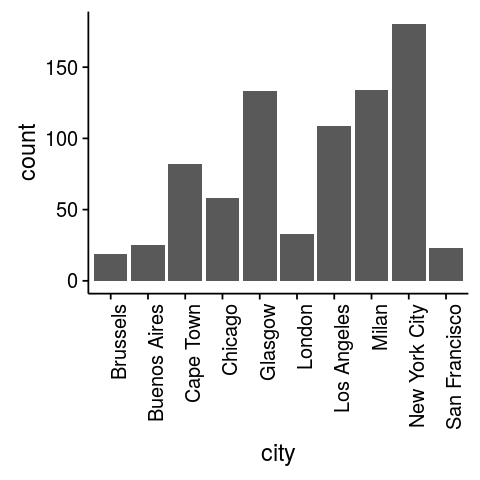

In [430]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(data=cisbat, aes(x=cisbat$city)) + geom_bar()+theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("city")

###### distributions

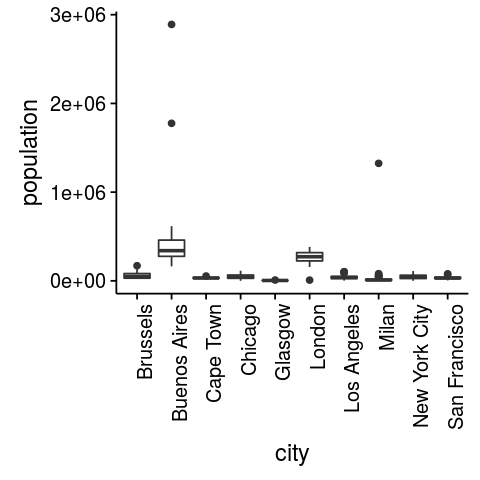

Warning message:
“Removed 26 rows containing non-finite values (stat_boxplot).”

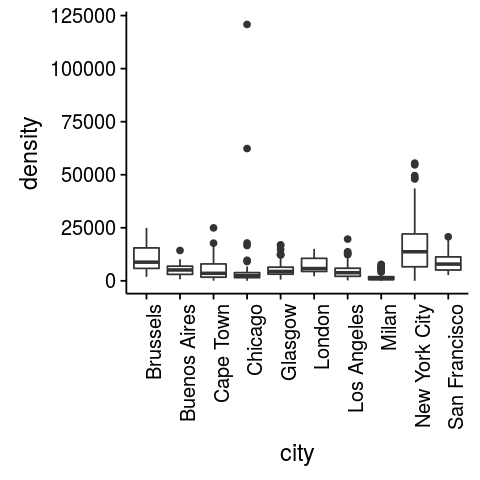

Warning message:
“Removed 371 rows containing non-finite values (stat_boxplot).”

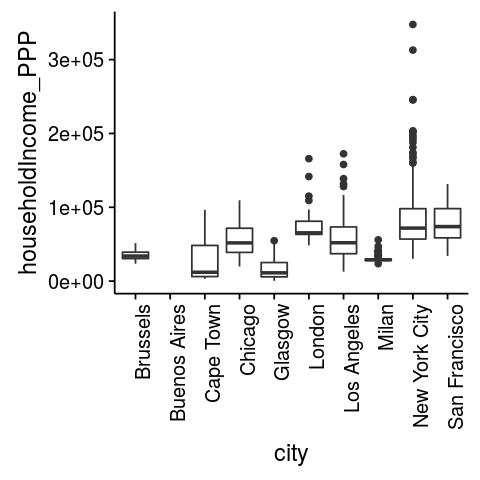

Warning message:
“Removed 371 rows containing non-finite values (stat_boxplot).”

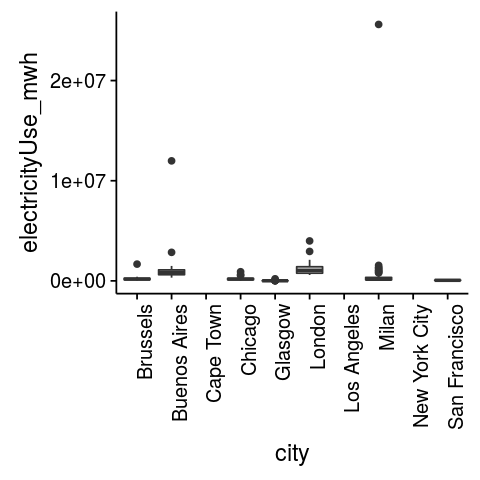

Warning message:
“Removed 261 rows containing non-finite values (stat_boxplot).”

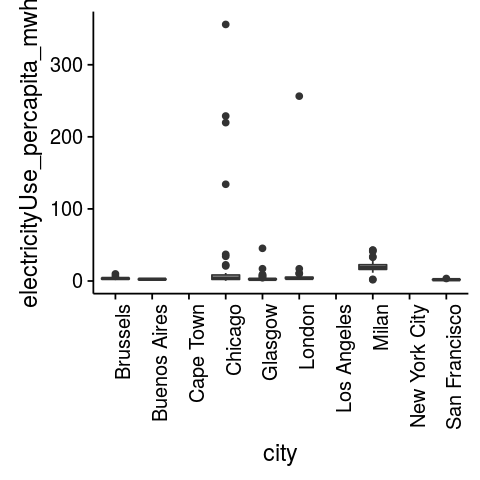

Warning message:
“Removed 261 rows containing non-finite values (stat_boxplot).”

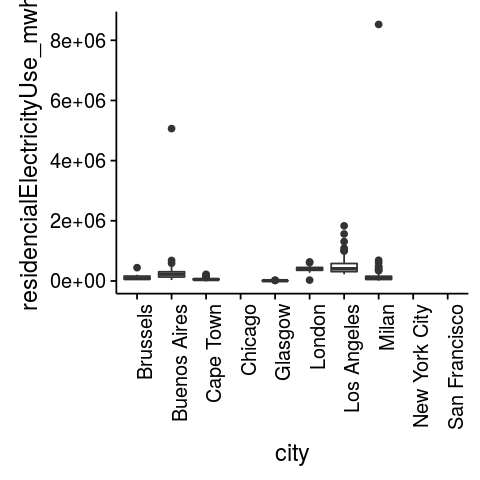

Warning message:
“Removed 350 rows containing non-finite values (stat_boxplot).”

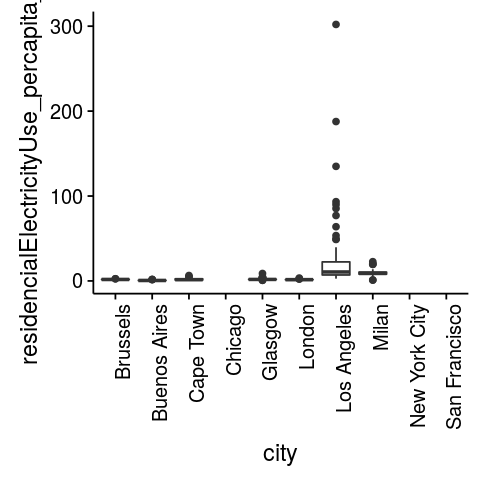

Warning message:
“Removed 350 rows containing non-finite values (stat_boxplot).”

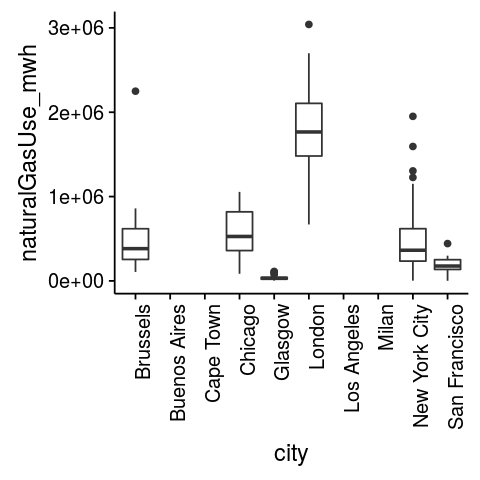

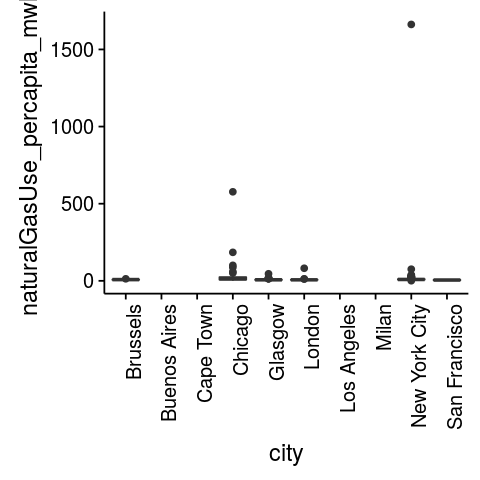

In [119]:
options(repr.plot.width=4, repr.plot.height=4)

#population
ggplot(cisbat, aes(city, population))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#density
ggplot(cisbat, aes(city, density))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#income
ggplot(cisbat, aes(city, householdIncome_PPP))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#electricityUse_mwh
ggplot(cisbat, aes(city, electricityUse_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

#pc
ggplot(cisbat, aes(city, electricityUse_percapita_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))




#residencialElectricityUse_mwh
ggplot(cisbat, aes(city, residencialElectricityUse_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))
#pc
ggplot(cisbat, aes(city, residencialElectricityUse_percapita_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#naturalGasUse_mwh
ggplot(cisbat, aes(city, naturalGasUse_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))
#pc
ggplot(cisbat, aes(city, naturalGasUse_percapita_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


###### correlation

EC    REC   NGC   pop   density income NGCpc ECpc  RECpc
EC       1.00  0.83  0.87  0.80  0.22    0.76   0.21  0.30 -0.08
REC      0.83  1.00  0.98  0.99  0.19    0.74  -0.05  0.01 -0.17
NGC      0.87  0.98  1.00  0.96  0.18    0.76   0.02  0.07 -0.16
pop      0.80  0.99  0.96  1.00  0.19    0.70  -0.07 -0.01 -0.21
density  0.22  0.19  0.18  0.19  1.00    0.24  -0.14 -0.04 -0.18
income   0.76  0.74  0.76  0.70  0.24    1.00   0.28  0.34 -0.08
NGCpc    0.21 -0.05  0.02 -0.07 -0.14    0.28   1.00  0.83  0.46
ECpc     0.30  0.01  0.07 -0.01 -0.04    0.34   0.83  1.00  0.26
RECpc   -0.08 -0.17 -0.16 -0.21 -0.18   -0.08   0.46  0.26  1.00

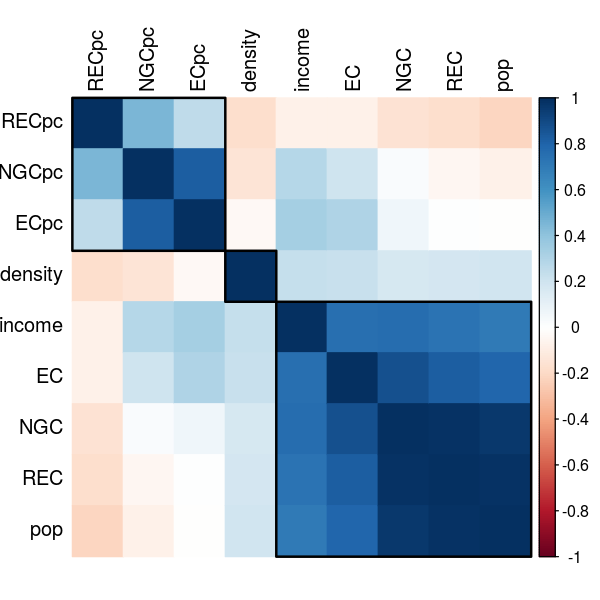

In [133]:
options(repr.plot.width=5, repr.plot.height=5)

cisbat_data <- cisbat[,-c(1,2,8)]

colnames(cisbat_data) <- c(as.character(names[-c(1,2,8),2]))

M <- cor(cisbat_data, use="complete.obs", method="pearson") #generates correlation matrix
write.csv(round(M,2), "cor_total.csv")
res1 <- cor.mtest(cisbat_data,0.95)


corrplot(M, method = "color", tl.col="black", order = "hclust", addrect=3) #order by correlational level
#corrplot.mixed(M,  upper = "color", tl.col="black")
#corrplot(M, p.mat = res1[[1]], insig = "blank")
round(M,2)

[1] "Brussels"


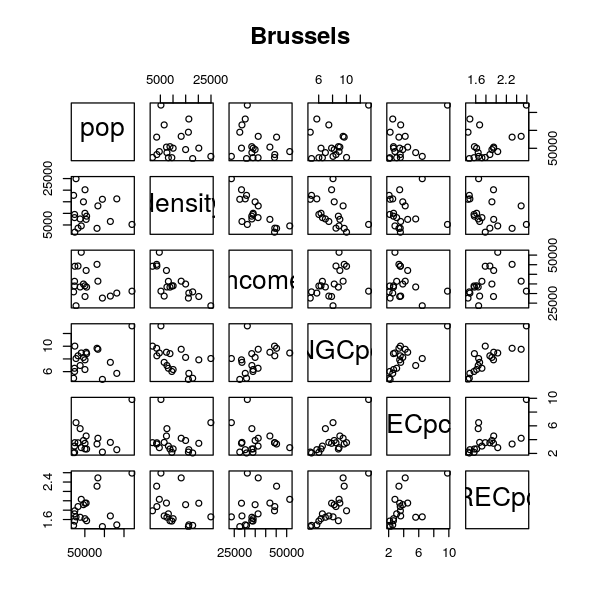

[1] "Milan"


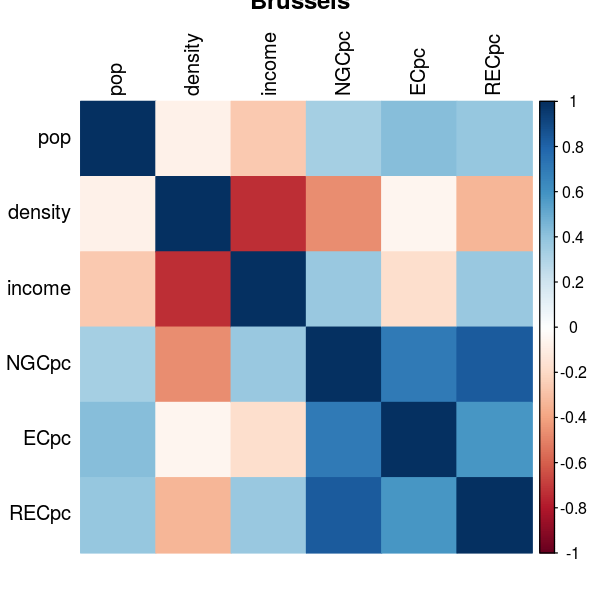

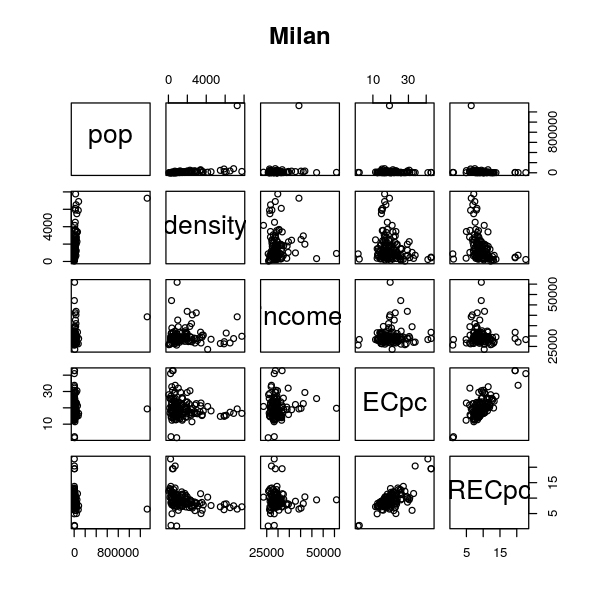

[1] "Cape Town"


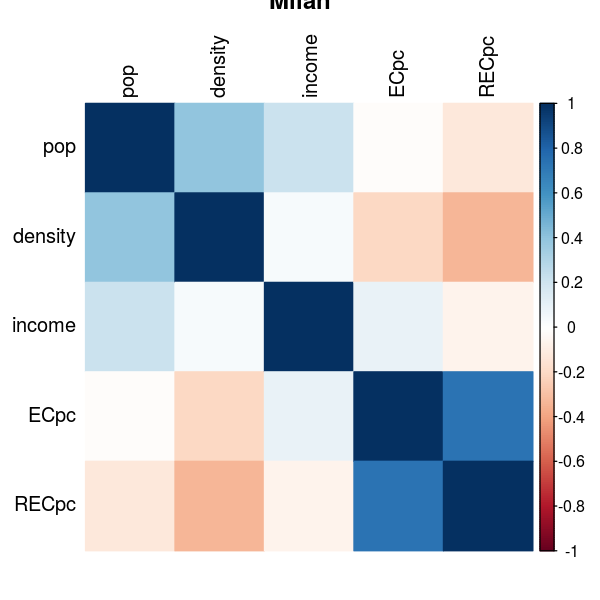

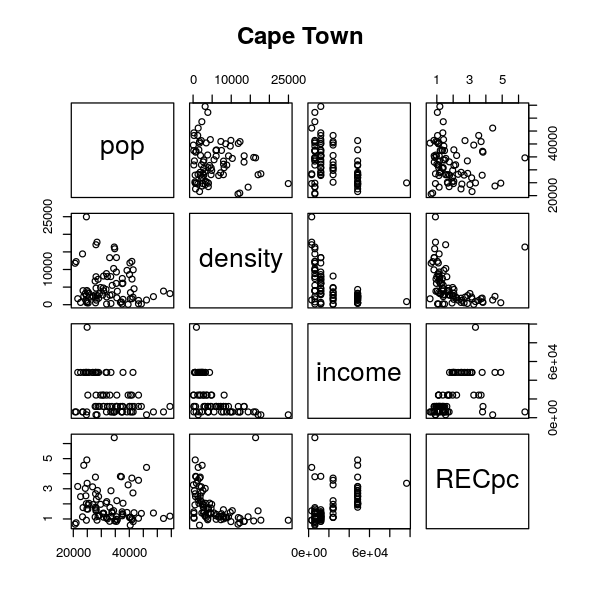

[1] "Buenos Aires"


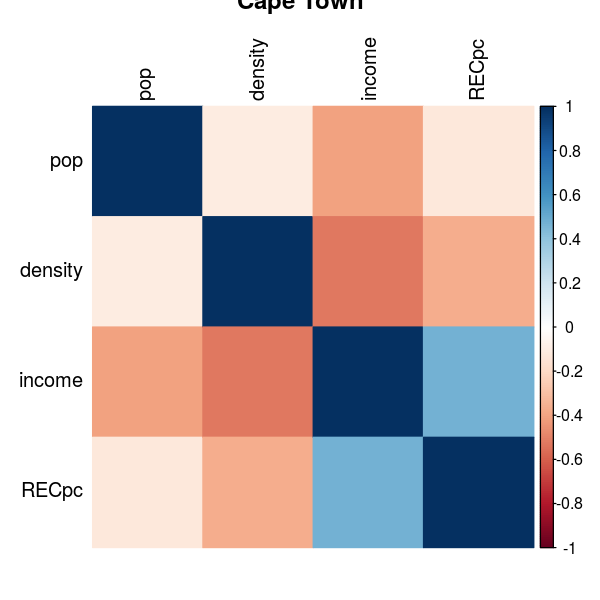

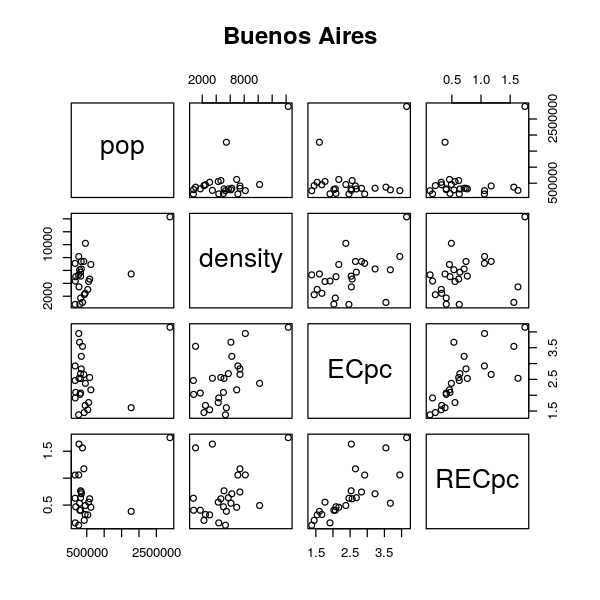

[1] "Chicago"


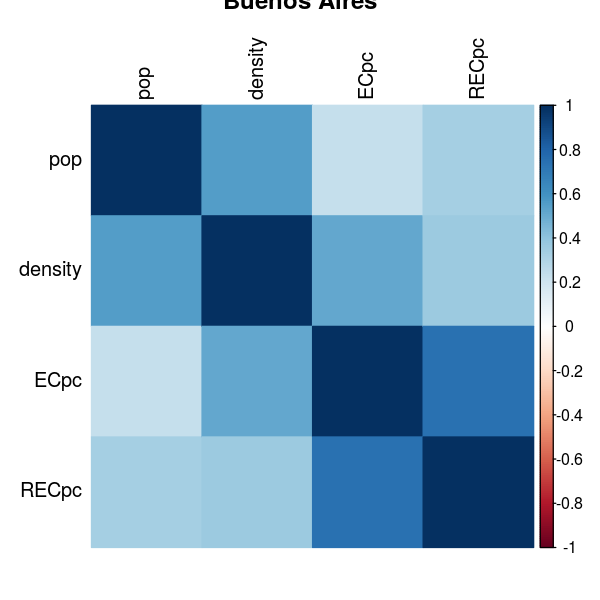

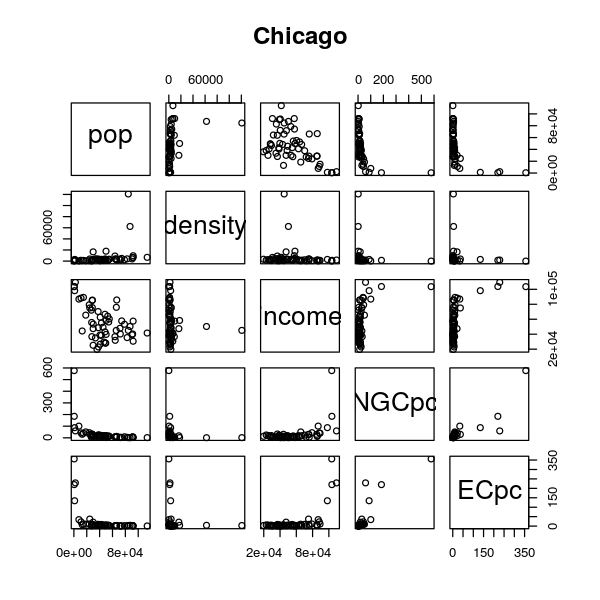

[1] "London"


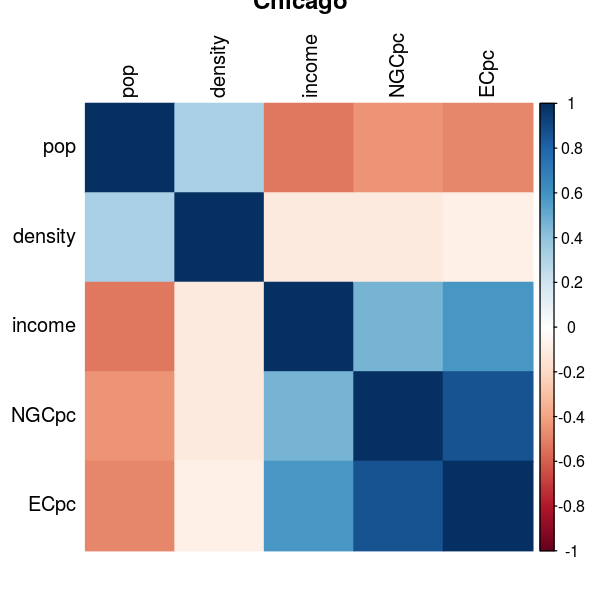

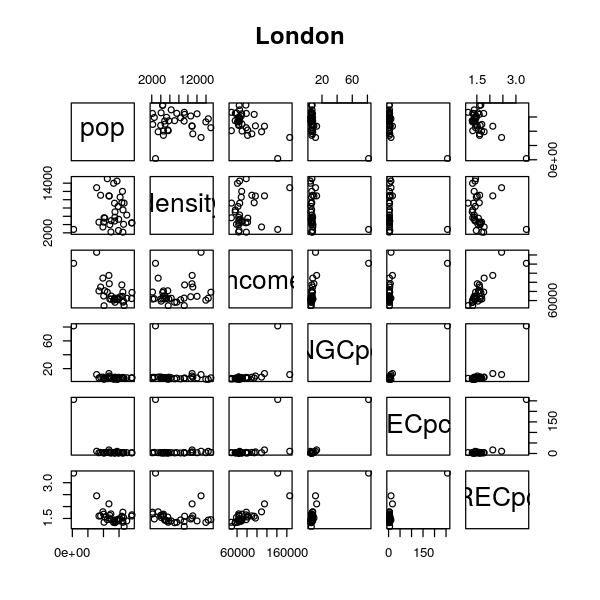

[1] "San Francisco"


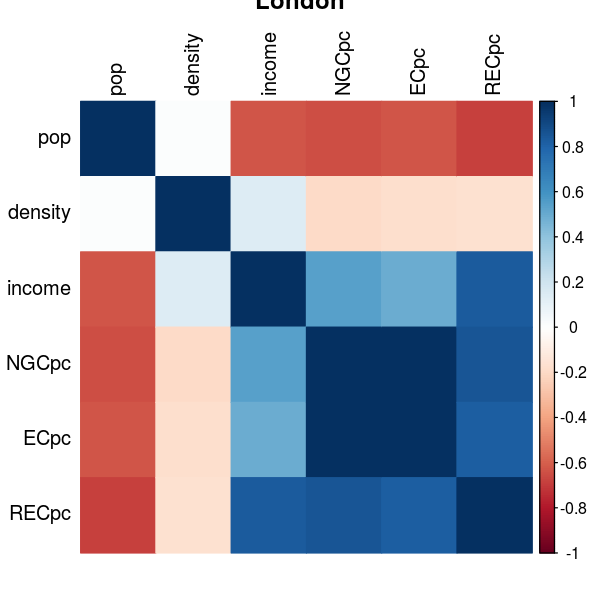

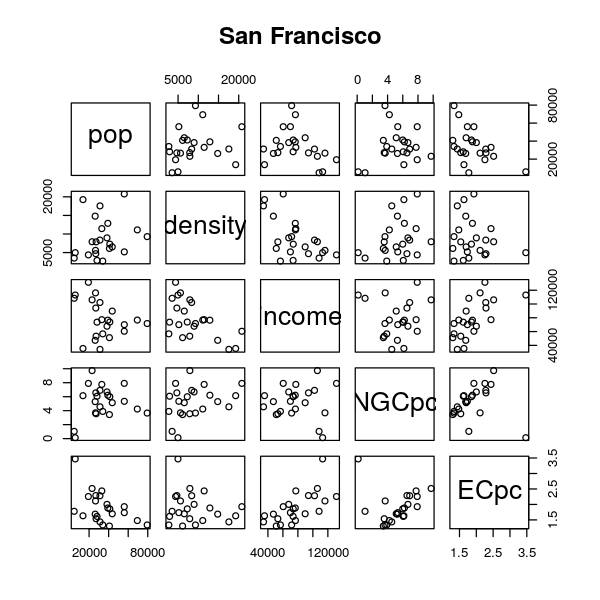

[1] "Los Angeles"


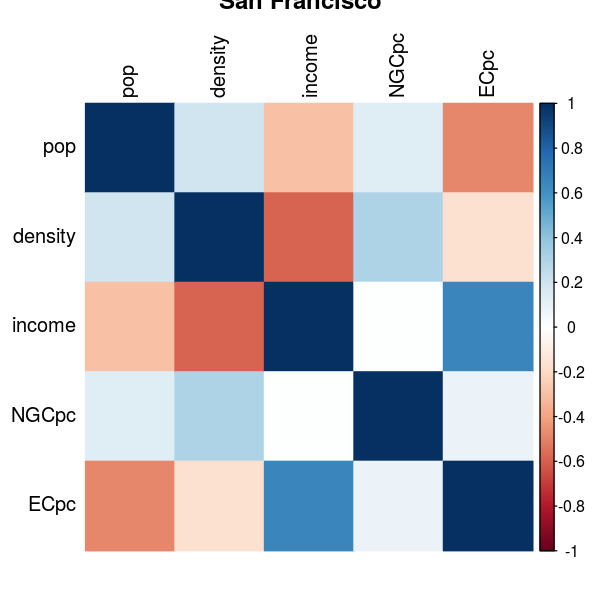

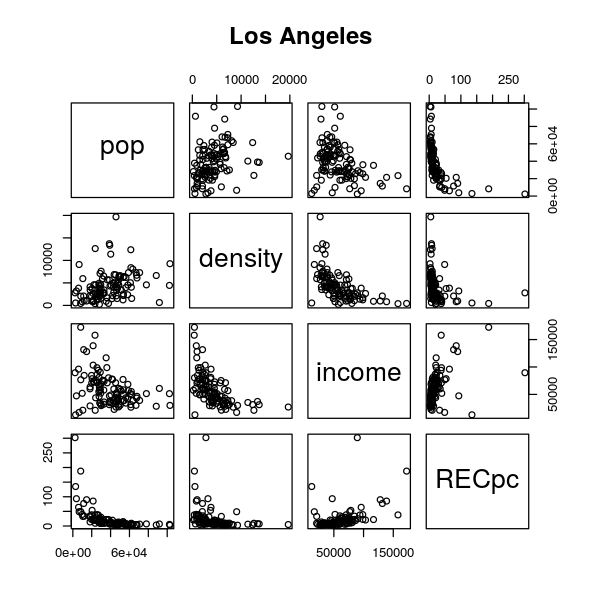

[1] "Glasgow"


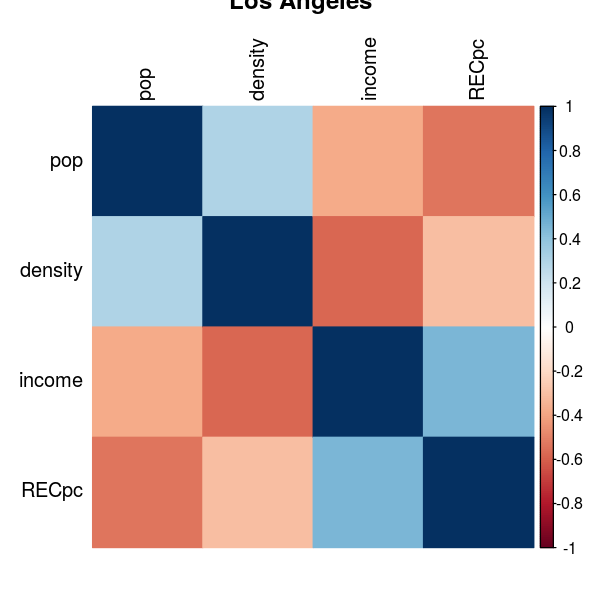

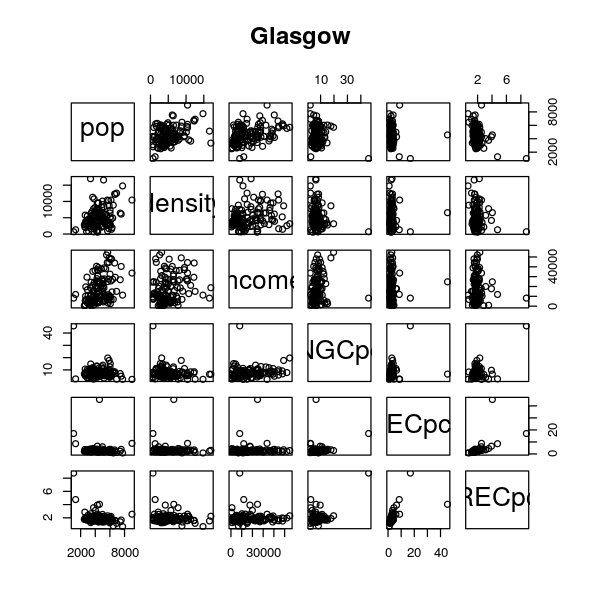

[1] "New York City"


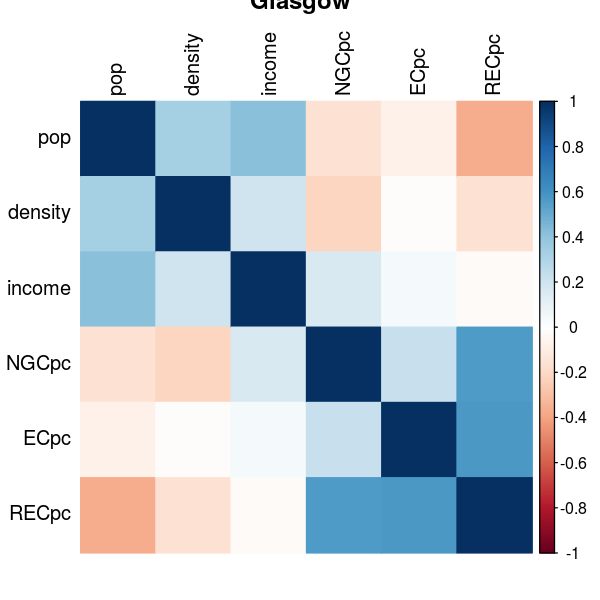

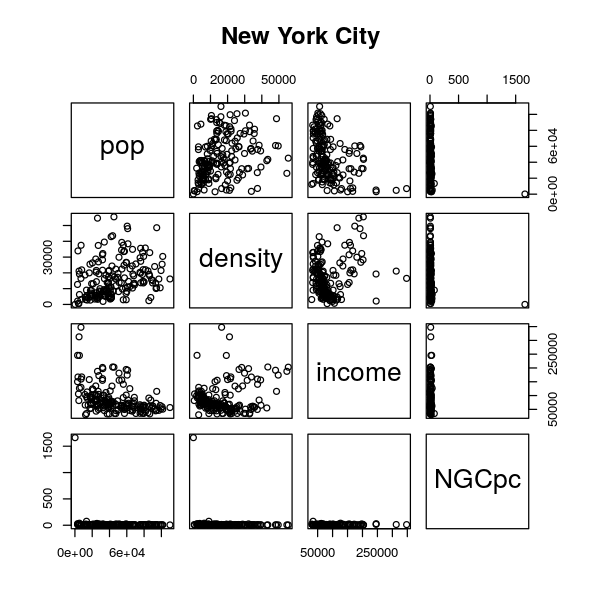

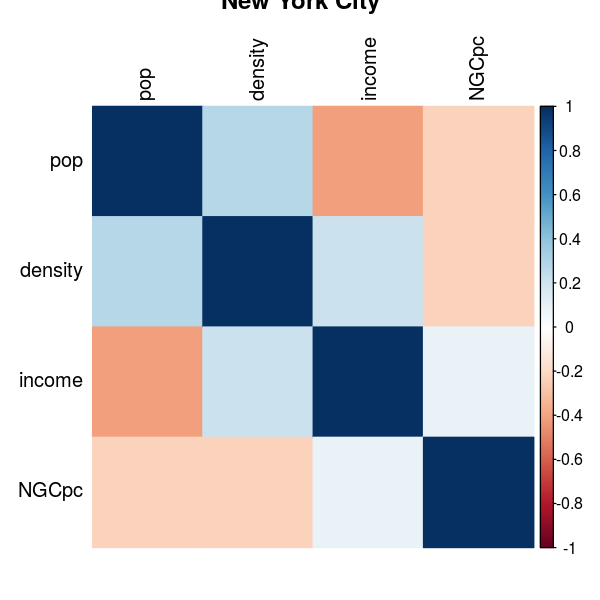

In [134]:
for (cit in unique(cisbat$city)) {
  print(cit)
  data <- cisbat[cisbat$city==cit,]
    

    data2 <- data[,-c(1,2,3,4,5,8)]

    colnames(data2) <- c(as.character(names[-c(1,2,3,4,5,8),2]))
  

  data2 <-  Filter(function(x) !all(is.na(x)), data2)
  # M <- cor(data2, use="complete.obs", method="pearson") #generates correlation matrix
  pairs(data2, main = cit)
  M <- cor(data2, method="pearson", use = "complete.obs") #generates correlation matrix
  write.csv(round(M,2), paste ("cor_", cit, "_ng",".csv",  sep = ""))
  corrplot(M, method = "color", tl.col="black", title=cit) #order by correlational level
}


###### scatter plots

Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”

Warning message:
“Removed 370 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 370 rows containing missing values (geom_point).”

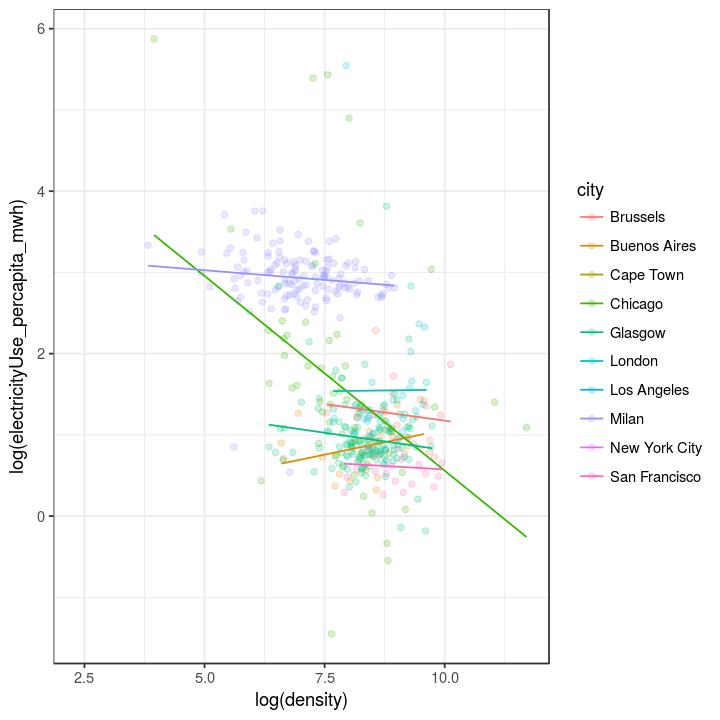

Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”

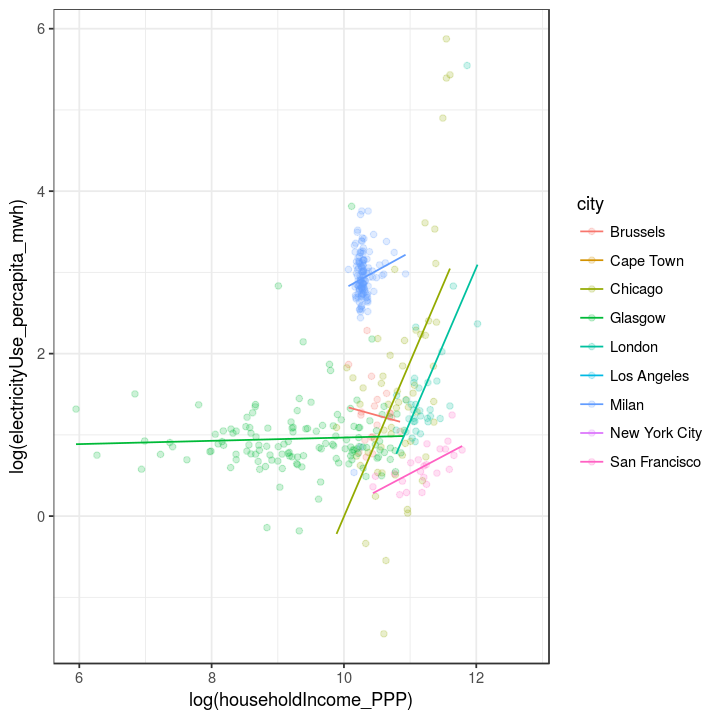

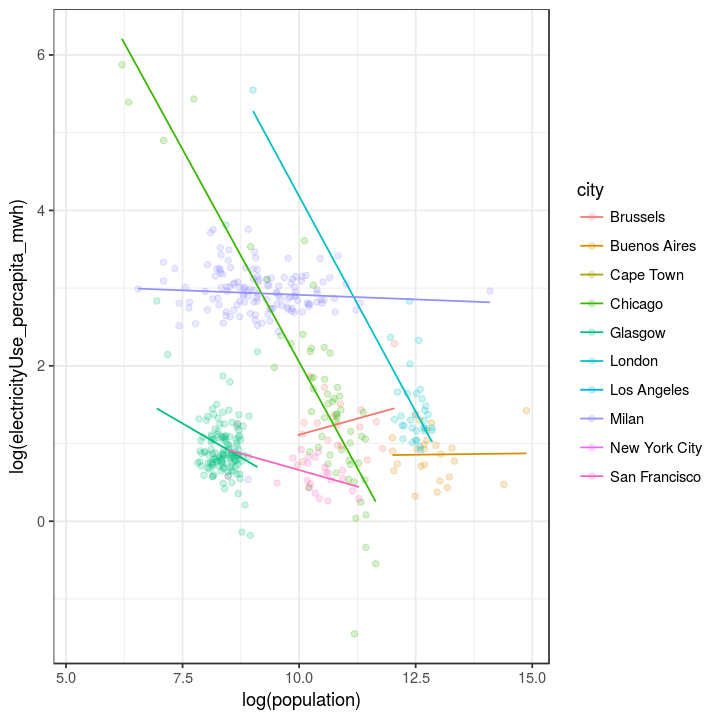

In [128]:
# ECpc
ggplot(cisbat, aes(log(density), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat[cisbat$householdIncome_PPP>1,], aes(log(householdIncome_PPP), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat, aes(log(population), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)



Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”

Warning message:
“Removed 260 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 260 rows containing missing values (geom_point).”

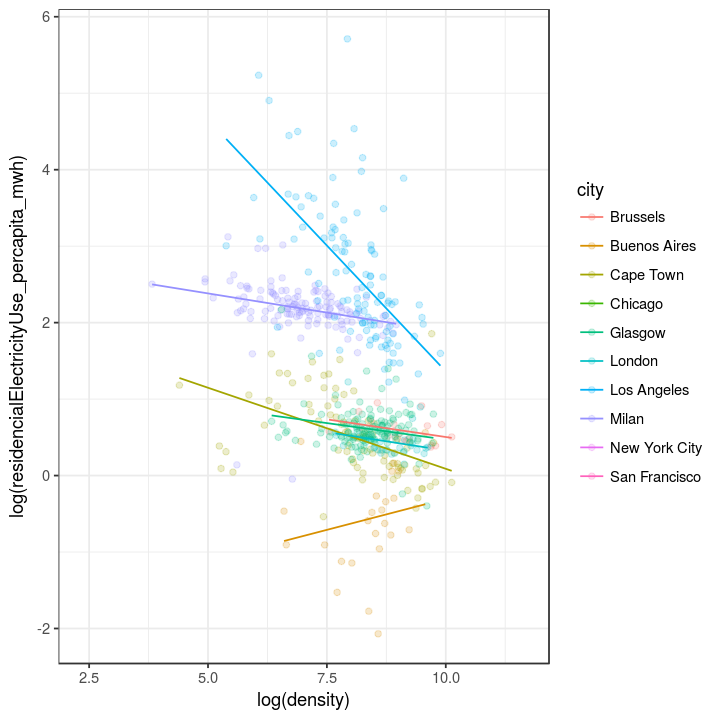

Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”

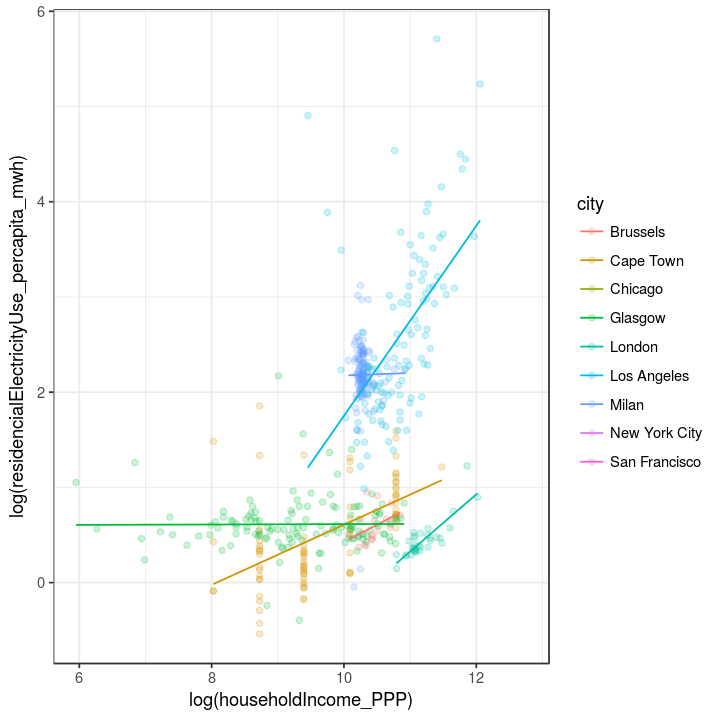

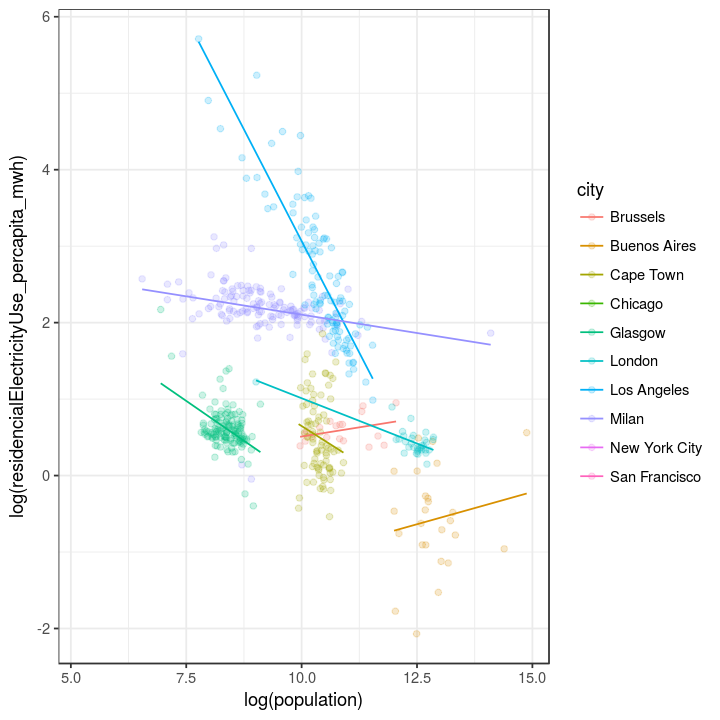

In [129]:
# RECpc
ggplot(cisbat, aes(log(density), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat[cisbat$householdIncome_PPP>1,], aes(log(householdIncome_PPP), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat, aes(log(population), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)


Warning message:
“Removed 260 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 260 rows containing missing values (geom_point).”

Warning message:
“Removed 325 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 325 rows containing missing values (geom_point).”

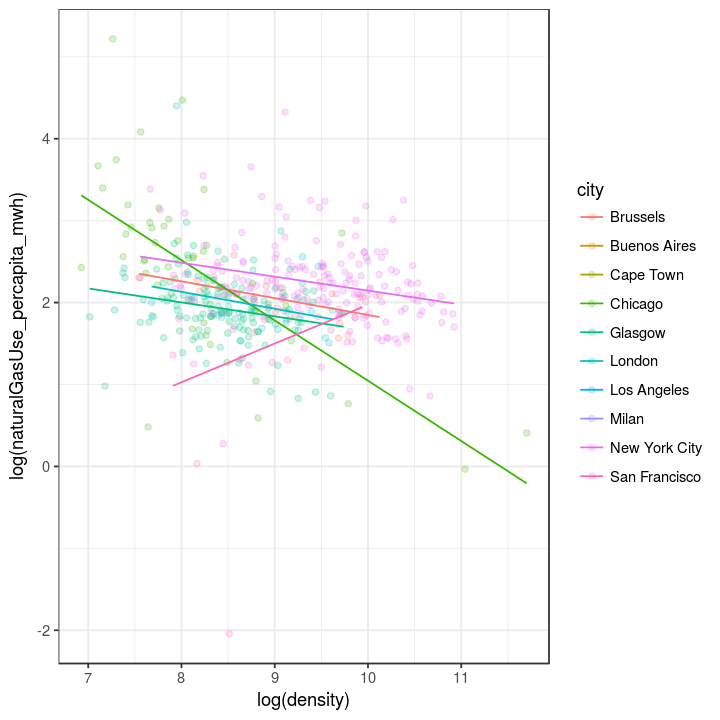

Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”

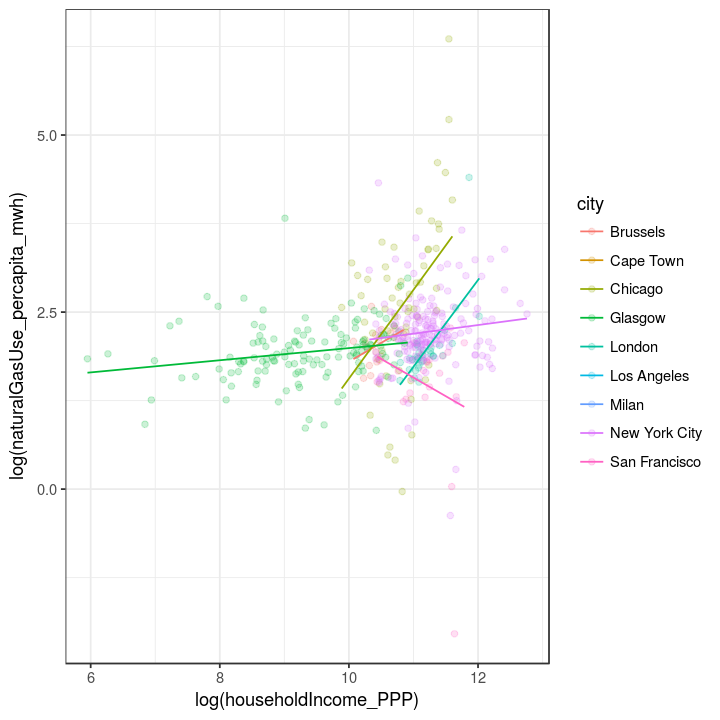

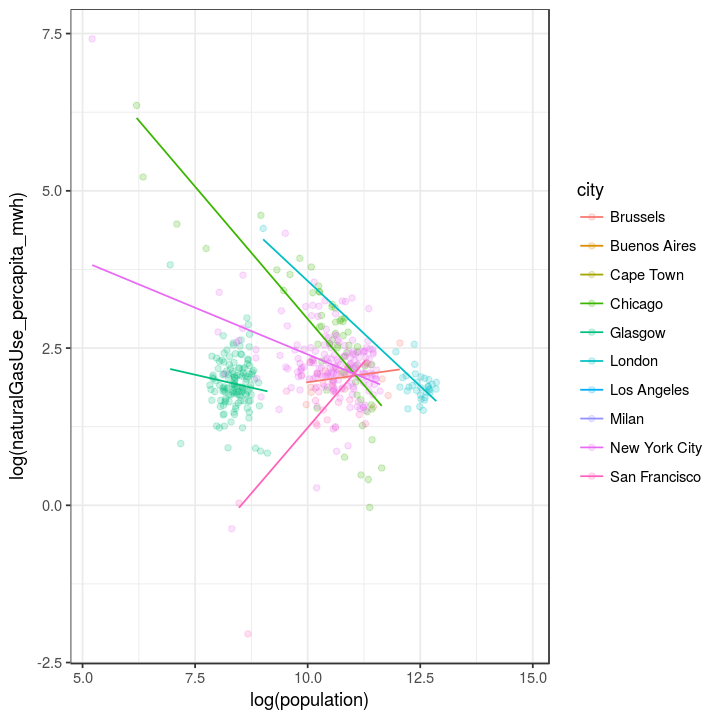

In [130]:
# NGCpc

ggplot(cisbat[cisbat$density>1000,], aes(log(density), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat[cisbat$householdIncome_PPP>1,], aes(log(householdIncome_PPP), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat, aes(log(population), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
#########################

In [131]:
#panel

######### CISBAT #############
et_d <- ggplot(cisbat, aes(log(density), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ylab("log( electricity [MWh] )")+ggtitle("log( density [hab/m2] )")
et_i <- ggplot(cisbat[cisbat$householdIncome_usd>1,], aes(log(householdIncome_usd), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank(),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ggtitle("log( income [USD] )")
et_p <- ggplot(cisbat, aes(log(population), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank(),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ggtitle("log( population [habitants] )")

er_d <- ggplot(cisbat, aes(log(density), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10), plot.title = element_text(hjust = 0.5))+ colScale+ylab("log( res. electricity [MWh] )")
er_i <- ggplot(cisbat[cisbat$householdIncome_usd>1,], aes(log(householdIncome_usd), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
er_p <- ggplot(cisbat, aes(log(population), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale

ng_d <- ggplot(cisbat[cisbat$density>1000,], aes(log(density), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10), plot.title = element_text(hjust = 0.5))+ colScale+ylab("log( nat. gas [MWh] )")
ng_i <- ggplot(cisbat[cisbat$householdIncome_usd>1,], aes(log(householdIncome_usd), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
ng_p <- ggplot(cisbat, aes(log(population), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
#########################



Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”Warning message:
“Removed 370 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 370 rows containing missing values (geom_point).”Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”Warning message:
“Removed 260 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 260 rows containing missing values (geom_point).”Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”Warning message:
“Removed 260 rows containing non-finite values (stat_smooth

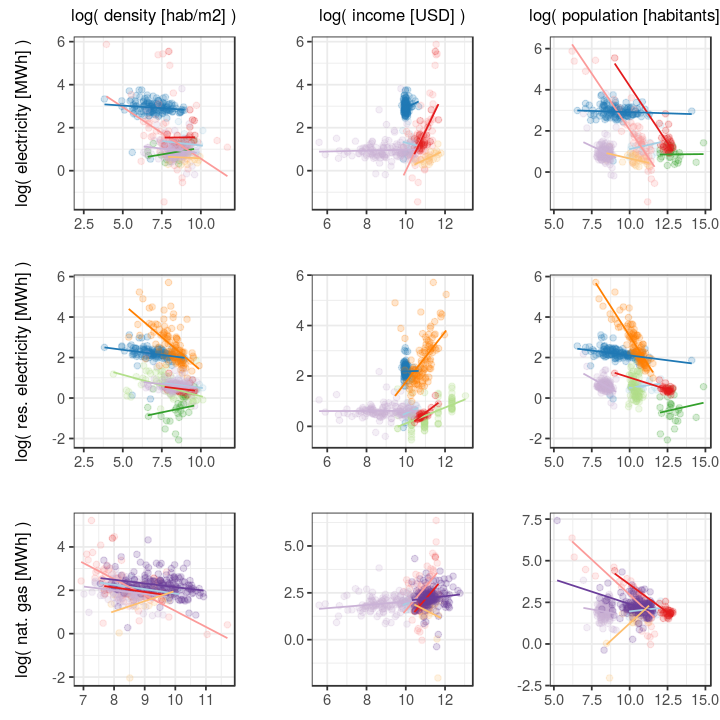

In [132]:
options(repr.plot.width=6, repr.plot.height=6)
plot_grid(et_d, et_i, et_p, er_d, er_i, er_p, ng_d, ng_i, ng_p, 
          align="hv",
          ncol = 3, nrow = 3)

###### regression

In [298]:
all(!is.na(cisbat_clean_pre[cisbat_clean_pre$city==cit,]$electricityUse_percapita_mwh))
cisbat[cisbat$city=="Buenos Aires",] 

[1] TRUE

city         mtu                             electricityUse_mwh
1  Buenos Aires Ciudad Autonoma de Buenos Aires 11984540.9        
2  Buenos Aires Almirante Brown                   977733.8        
3  Buenos Aires Avellaneda                       1105985.1        
4  Buenos Aires Berazategui                       670545.8        
5  Buenos Aires Esteban Echeverría                609923.0        
6  Buenos Aires Ezeiza                            403513.3        
7  Buenos Aires Florencio Varela                  618472.1        
8  Buenos Aires General San Martín               1099995.2        
9  Buenos Aires Hurlingham                        378569.1        
10 Buenos Aires Ituzaingó                         321062.3        
11 Buenos Aires Jose C. Paz                       367222.0        
12 Buenos Aires La Matanza                       2849664.3        
13 Buenos Aires Lanús                            1090600.7        
14 Buenos Aires Lomas de Zamora                  1337076.7        
15 Buenos Aires Malvinas Argentinas               815433.9        
16 Buenos Aires Merlo                             813952.5        
17 Buenos Aires Moreno                            758868.7        
18 Buenos Aires Moron                             861121.6        
19 Buenos Aires Quilmes                          1492090.0        
20 Buenos Aires San Fernando                      477388.9        
21 Buenos Aires San Isidro                       1075772.4        
22 Buenos Aires San Miguel                        700299.3        
23 Buenos Aires Tigre                            1333568.6        
24 Buenos Aires Tres de Febrero                   963054.5        
25 Buenos Aires Vicente López                    1063882.0        
   residencialElectricityUse_mwh naturalGasUse_mwh population density 
1  5065078                       NA                2890151    14307.68
2   306460                       NA                 552902     4286.06
3   243431                       NA                 342677     6230.49
4   130940                       NA                 324244     1724.70
5   121663                       NA                 300959      770.07
6   102733                       NA                 163722      734.18
7    92483                       NA                 426005     2242.13
8   486308                       NA                 414196     7396.36
9    84939                       NA                 181241     5034.47
10   28465                       NA                 167824     4359.06
11   33596                       NA                 265981     5319.62
12  681420                       NA                1775816     5452.14
13  226129                       NA                 459263    10205.84
14  283116                       NA                 616279     6924.48
15  246784                       NA                 322375     5117.06
16  168390                       NA                 528494     3054.88
17  147295                       NA                 452505     2457.00
18  204690                       NA                 321109     5734.09
19  359946                       NA                 582943     4663.54
20  172718                       NA                 163240     7097.39
21  156647                       NA                 292878     6101.63
22  451089                       NA                 276190     3452.38
23  588166                       NA                 376381     1045.50
24  252674                       NA                 340071     7392.85
25  285740                       NA                 269420     8164.24
   householdIncome_usd householdIncome_PPP naturalGasUse_percapita_mwh
1  NA                  NA                  NA                         
2  NA                  NA                  NA                         
3  NA                  NA                  NA                         
4  NA                  NA                  NA                         
5  NA                  NA                  NA               

In [301]:
# ECpc

regression_electrictiyuse_pc <- data.frame(density_intercept= numeric(0), 
                                           density_alpha= numeric(0), 
                                           density_r.squared= numeric(0),
                                           density_p.value= numeric(0),
                                           income_intercept= numeric(0), 
                                           income_alpha= numeric(0), 
                                           income_r.squared= numeric(0),
                                           income_p.value= numeric(0),
                                           population_intercept= numeric(0), 
                                           population_alpha= numeric(0), 
                                           population_r.squared= numeric(0),
                                           population_p.value= numeric(0),
                                        stringsAsFactors=FALSE)

for (cit in unique(cisbat$city)) {
  if (all(!is.na(cisbat[cisbat$city==cit,]$electricityUse_percapita_mwh))) {
    if (all(!is.na(cisbat[cisbat$city==cit,]$population))) {
      
    rg_p <- lm(log(electricityUse_percapita_mwh) ~ log(population), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
    regression_electrictiyuse_pc[cit, "population_r.squared"] <- summary(rg_p)$r.squared
    regression_electrictiyuse_pc[cit, "population_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_electrictiyuse_pc[cit, "population_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_electrictiyuse_pc[cit, "population_intercept"] <- summary(rg_p)$coefficients[1,1] 
    }  else {
      regression_electrictiyuse_pc[cit, "population_r.squared"] <- 0
      regression_electrictiyuse_pc[cit, "population_p.value"] <- 0 
      regression_electrictiyuse_pc[cit, "population_alpha"] <- 0 
      regression_electrictiyuse_pc[cit, "population_intercept"] <- 0 
    }
    
    
    if (all(!is.na(cisbat[cisbat$city==cit,]$density))) {
    rg_d <- lm(log(electricityUse_percapita_mwh) ~ log(density), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
    regression_electrictiyuse_pc[cit, "density_r.squared"] <- summary(rg_d)$r.squared
    regression_electrictiyuse_pc[cit, "density_p.value"] <- summary(rg_d)$coefficients[2,4] 
    regression_electrictiyuse_pc[cit, "density_alpha"] <- summary(rg_d)$coefficients[2,1] 
    regression_electrictiyuse_pc[cit, "density_intercept"] <- summary(rg_d)$coefficients[1,1] 
    }  else {
      regression_electrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "population_intercept"] <- NA 
    }
    
    
    if (all(!is.na(cisbat[cisbat$city==cit,]$householdIncome_PPP))) {
    rg_i <- lm(log(electricityUse_percapita_mwh) ~ log(householdIncome_usd), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
    regression_electrictiyuse_pc[cit, "income_r.squared"] <- summary(rg_i)$r.squared
    regression_electrictiyuse_pc[cit, "income_p.value"] <- summary(rg_i)$coefficients[2,4] 
    regression_electrictiyuse_pc[cit, "income_alpha"] <- summary(rg_i)$coefficients[2,1] 
    regression_electrictiyuse_pc[cit, "income_intercept"] <- summary(rg_i)$coefficients[1,1] 
    }  else {
      regression_electrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "population_intercept"] <- NA 
    }
    
      
  }  else {
    regression_electrictiyuse_pc[cit, "population_r.squared"] <- NA
    regression_electrictiyuse_pc[cit, "population_p.value"] <- NA 
    regression_electrictiyuse_pc[cit, "population_alpha"] <- NA
    regression_electrictiyuse_pc[cit, "population_intercept"] <- NA 
  }
  
}
regression_electrictiyuse_pc$city <- rownames(regression_electrictiyuse_pc)
levels(regression_electrictiyuse_pc$city) <- unique(regression_electrictiyuse_pc$city)

regression_electrictiyuse_pc


density_intercept density_alpha density_r.squared density_p.value
Brussels       1.9906476        -0.081559125  1.954399e-02      0.568122445    
Milan          3.2656698        -0.047747976  1.372568e-02      0.177617203    
Cape Town             NA                  NA            NA               NA    
Buenos Aires  -0.1628044         0.122589645  9.001831e-02      0.145070172    
Chicago        5.3535126        -0.479482012  1.636709e-01      0.001633663    
London         1.4821437         0.007383101  2.407969e-05      0.978378091    
San Francisco  0.9102409        -0.033524285  6.514821e-03      0.714287262    
Los Angeles           NA                  NA            NA               NA    
Glasgow        1.6660864        -0.085315768  1.656205e-02      0.139862312    
New York City         NA                  NA            NA               NA    
              income_intercept income_alpha income_r.squared income_p.value
Brussels        3.5580150      -0.22558455  0.012745935      6.453887e-01  
Milan          -1.5574396       0.44810409  0.017552131      1.270135e-01  
Cape Town              NA               NA           NA                NA  
Buenos Aires           NA               NA           NA                NA  
Chicago       -19.0563068       1.90506515  0.324633414      3.040195e-06  
London        -19.0285440       1.89672158  0.394192347      9.177181e-05  
San Francisco  -4.2109812       0.43046820  0.426381768      7.305341e-04  
Los Angeles            NA               NA           NA                NA  
Glasgow         0.7722908       0.02024979  0.002110656      5.995111e-01  
New York City          NA               NA           NA                NA  
              population_intercept population_alpha population_r.squared
Brussels      -0.5504528            0.1663442       0.069183966         
Milan          3.1462264           -0.0233304       0.003857566         
Cape Town             NA                   NA                NA         
Buenos Aires          NA                   NA                NA         
Chicago       12.9908002           -1.0940193       0.792875910         
London        15.2690450           -1.1086020       0.731329305         
San Francisco  2.3584854           -0.1699780       0.226669022         
Los Angeles           NA                   NA                NA         
Glasgow        3.8803522           -0.3496063       0.060117577         
New York City         NA                   NA                NA         
              population_p.value city         
Brussels      2.766039e-01       Brussels     
Milan         4.758951e-01       Milan        
Cape Town               NA       Cape Town    
Buenos Aires            NA       Buenos Aires 
Chicago       8.488414e-21       Chicago      
London        2.338301e-10       London       
San Francisco 2.164872e-02       San Francisco
Los Angeles             NA       Los Angeles  
Glasgow       4.447864e-03       Glasgow      
New York City           NA       New York City

In [302]:
# RECpc

regression_residentialelectrictiyuse_pc <- data.frame(density_intercept= numeric(0), 
                                           density_alpha= numeric(0), 
                                           density_r.squared= numeric(0),
                                           density_p.value= numeric(0),
                                           income_intercept= numeric(0), 
                                           income_alpha= numeric(0), 
                                           income_r.squared= numeric(0),
                                           income_p.value= numeric(0),
                                           population_intercept= numeric(0), 
                                           population_alpha= numeric(0), 
                                           population_r.squared= numeric(0),
                                           population_p.value= numeric(0),
                                           stringsAsFactors=FALSE)

for (cit in unique(cisbat$city)) {
  if (all(!is.na(cisbat[cisbat$city==cit,]$residencialElectricityUse_percapita_mwh))) {
    if (all(!is.na(cisbat[cisbat$city==cit,]$population))) {
      rg_p <- lm(log(residencialElectricityUse_percapita_mwh) ~ log(population), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
      regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- summary(rg_p)$r.squared
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- summary(rg_p)$coefficients[2,4] 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- summary(rg_p)$coefficients[2,1] 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- summary(rg_p)$coefficients[1,1] 
    }  else {
      regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
    }
    
    
    if (all(!is.na(cisbat[cisbat$city==cit,]$density))) {
      rg_d <- lm(log(residencialElectricityUse_percapita_mwh) ~ log(density), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
      regression_residentialelectrictiyuse_pc[cit, "density_r.squared"] <- summary(rg_d)$r.squared
      regression_residentialelectrictiyuse_pc[cit, "density_p.value"] <- summary(rg_d)$coefficients[2,4] 
      regression_residentialelectrictiyuse_pc[cit, "density_alpha"] <- summary(rg_d)$coefficients[2,1] 
      regression_residentialelectrictiyuse_pc[cit, "density_intercept"] <- summary(rg_d)$coefficients[1,1] 
    }  else {
      regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
    }
    
    
    if (all(!is.na(cisbat[cisbat$city==cit,]$householdIncome_usd))) {
      rg_i <- lm(log(residencialElectricityUse_percapita_mwh) ~ log(householdIncome_PPP), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
      regression_residentialelectrictiyuse_pc[cit, "income_r.squared"] <- summary(rg_i)$r.squared
      regression_residentialelectrictiyuse_pc[cit, "income_p.value"] <- summary(rg_i)$coefficients[2,4] 
      regression_residentialelectrictiyuse_pc[cit, "income_alpha"] <- summary(rg_i)$coefficients[2,1] 
      regression_residentialelectrictiyuse_pc[cit, "income_intercept"] <- summary(rg_i)$coefficients[1,1] 
    }  else {
      regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
    }
    
    
  }  else {
    regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- NA
    regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
    regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
    regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
  }
  
}
regression_residentialelectrictiyuse_pc$city <- rownames(regression_residentialelectrictiyuse_pc)
levels(regression_residentialelectrictiyuse_pc$city) <- unique(regression_residentialelectrictiyuse_pc$city)

regression_residentialelectrictiyuse_pc

density_intercept density_alpha density_r.squared density_p.value
Brussels       1.426639         -0.09225326   0.13408453        1.231006e-01   
Milan          2.883171         -0.10024660   0.06870752        2.216876e-03   
Cape Town      2.208298         -0.21199128   0.24121262        2.800974e-06   
Buenos Aires  -1.923594          0.16180590   0.03404679        3.772514e-01   
Chicago              NA                  NA           NA                  NA   
London         1.288668         -0.09607734   0.07332688        1.274524e-01   
San Francisco        NA                  NA           NA                  NA   
Los Angeles    7.944687         -0.65821955   0.35824563        6.258998e-12   
Glasgow        1.332235         -0.08615739   0.04344245        1.606090e-02   
New York City        NA                  NA           NA                  NA   
              income_intercept income_alpha income_r.squared income_p.value
Brussels      -3.1103752       0.361834853  1.758413e-01     7.390953e-02  
Milan          1.9155493       0.026684467  7.068549e-05     9.231923e-01  
Cape Town     -3.0439104       0.315824957  2.884226e-01     1.975538e-07  
Buenos Aires          NA                NA            NA               NA  
Chicago               NA                NA            NA               NA  
London        -6.0618563       0.600099977  7.095717e-01     7.927274e-10  
San Francisco         NA                NA            NA               NA  
Los Angeles   -8.2249060       0.997678640  2.711909e-01     6.446227e-09  
Glasgow        0.5951286       0.001959269  5.082040e-05     9.350930e-01  
New York City         NA                NA            NA               NA  
              population_intercept population_alpha population_r.squared
Brussels      -0.4543712            0.09643757      0.12468945          
Milan          3.0632160           -0.09592818      0.07406324          
Cape Town      4.4847799           -0.38371819      0.02619468          
Buenos Aires          NA                    NA              NA          
Chicago               NA                    NA              NA          
London         3.3793615           -0.23682639      0.60016393          
San Francisco         NA                    NA              NA          
Los Angeles   14.7473545           -1.16806336      0.77715337          
Glasgow        4.1011844           -0.41670285      0.21966938          
New York City         NA                    NA              NA          
              population_p.value city         
Brussels      1.380862e-01       Brussels     
Milan         1.467361e-03       Milan        
Cape Town     1.463098e-01       Cape Town    
Buenos Aires            NA       Buenos Aires 
Chicago                 NA       Chicago      
London        1.214522e-07       London       
San Francisco           NA       San Francisco
Los Angeles   1.143326e-36       Los Angeles  
Glasgow       1.273271e-08       Glasgow      
New York City           NA       New York City

In [303]:
regression_naturalgasuse_pc <- data.frame(density_intercept= numeric(0), 
                                                      density_alpha= numeric(0), 
                                                      density_r.squared= numeric(0),
                                                      density_p.value= numeric(0),
                                                      income_intercept= numeric(0), 
                                                      income_alpha= numeric(0), 
                                                      income_r.squared= numeric(0),
                                                      income_p.value= numeric(0),
                                                      population_intercept= numeric(0), 
                                                      population_alpha= numeric(0), 
                                                      population_r.squared= numeric(0),
                                                      population_p.value= numeric(0),
                                                      stringsAsFactors=FALSE)

for (cit in unique(cisbat$city)) {
  if (all(!is.na(cisbat[cisbat$city==cit,]$naturalGasUse_percapita_mwh))) {
    if (all(!is.na(cisbat[cisbat$city==cit,]$population))) {
      
      rg_p <- lm(log(naturalGasUse_percapita_mwh) ~ log(population), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
      regression_naturalgasuse_pc[cit, "population_r.squared"] <- summary(rg_p)$r.squared
      regression_naturalgasuse_pc[cit, "population_p.value"] <- summary(rg_p)$coefficients[2,4] 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- summary(rg_p)$coefficients[2,1] 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- summary(rg_p)$coefficients[1,1] 
    }
    else {
      regression_naturalgasuse_pc[cit, "population_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "population_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- NA 
    }
    
    if (all(!is.na(cisbat[cisbat$city==cit,]$density))) {
      rg_d <- lm(log(naturalGasUse_percapita_mwh) ~ log(density), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
      regression_naturalgasuse_pc[cit, "density_r.squared"] <- summary(rg_d)$r.squared
      regression_naturalgasuse_pc[cit, "density_p.value"] <- summary(rg_d)$coefficients[2,4] 
      regression_naturalgasuse_pc[cit, "density_alpha"] <- summary(rg_d)$coefficients[2,1] 
      regression_naturalgasuse_pc[cit, "density_intercept"] <- summary(rg_d)$coefficients[1,1] 
    }    else {
      regression_naturalgasuse_pc[cit, "population_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "population_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- NA 
    }
    
    if (all(!is.na(cisbat[cisbat$city==cit,]$householdIncome_usd))) {
      rg_i <- lm(log(naturalGasUse_percapita_mwh) ~ log(householdIncome_PPP), na.action=na.exclude, data = cisbat[cisbat$city==cit,])
      regression_naturalgasuse_pc[cit, "income_r.squared"] <- summary(rg_i)$r.squared
      regression_naturalgasuse_pc[cit, "income_p.value"] <- summary(rg_i)$coefficients[2,4] 
      regression_naturalgasuse_pc[cit, "income_alpha"] <- summary(rg_i)$coefficients[2,1] 
      regression_naturalgasuse_pc[cit, "income_intercept"] <- summary(rg_i)$coefficients[1,1] 
    }    else {
      regression_naturalgasuse_pc[cit, "population_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "population_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- NA 
    }
    
  } else {
    
    regression_naturalgasuse_pc[cit, "population_r.squared"] <- NA
    regression_naturalgasuse_pc[cit, "population_p.value"] <- NA
    regression_naturalgasuse_pc[cit, "population_alpha"] <- NA
    regression_naturalgasuse_pc[cit, "population_intercept"] <- NA
    
  }
}
regression_naturalgasuse_pc$city <- rownames(regression_naturalgasuse_pc)
levels(regression_naturalgasuse_pc$city) <- unique(regression_naturalgasuse_pc$city)


regression_naturalgasuse_pc

density_intercept density_alpha density_r.squared density_p.value
Brussels       3.900020         -0.2051027    0.29509600        1.623109e-02   
Milan                NA                 NA            NA                  NA   
Cape Town            NA                 NA            NA                  NA   
Buenos Aires         NA                 NA            NA                  NA   
Chicago        8.296902         -0.7262983    0.53700855        6.176182e-11   
London         3.780997         -0.2062366    0.05511196        1.884907e-01   
San Francisco -2.755345          0.4728514    0.09379627        1.552318e-01   
Los Angeles          NA                 NA            NA                  NA   
Glasgow        3.051620         -0.1339562    0.04591458        1.326134e-02   
New York City  4.851908         -0.2767854    0.17447831        5.411651e-09   
              income_intercept income_alpha income_r.squared income_p.value
Brussels       -3.396224        0.53156948  0.16897616       8.039390e-02  
Milan                 NA                NA          NA                 NA  
Cape Town             NA                NA          NA                 NA  
Buenos Aires          NA                NA          NA                 NA  
Chicago       -10.976652        1.25373807  0.20105339       4.157161e-04  
London        -11.307535        1.22456030  0.48195042       7.426955e-06  
San Francisco   7.353841       -0.52534336  0.04595743       3.259700e-01  
Los Angeles           NA                NA          NA                 NA  
Glasgow         1.165034        0.08577942  0.04259046       1.715929e-02  
New York City         NA                NA          NA                 NA  
              population_intercept population_alpha population_r.squared
Brussels       0.9711577            0.09869597      0.05814887          
Milan                 NA                    NA              NA          
Cape Town             NA                    NA              NA          
Buenos Aires          NA                    NA              NA          
Chicago       11.3739613           -0.84109061      0.67013923          
London        10.2573208           -0.66901232      0.78121556          
San Francisco -7.1108697            0.83446973      0.39534924          
Los Angeles           NA                    NA              NA          
Glasgow        3.3085416           -0.16432660      0.01493579          
New York City         NA                    NA              NA          
              population_p.value city         
Brussels      3.199661e-01       Brussels     
Milan                   NA       Milan        
Cape Town               NA       Cape Town    
Buenos Aires            NA       Buenos Aires 
Chicago       4.192473e-15       Chicago      
London        9.397480e-12       London       
San Francisco 1.310840e-03       San Francisco
Los Angeles             NA       Los Angeles  
Glasgow       1.611025e-01       Glasgow      
New York City           NA       New York City

In [ ]:
# plot slopes

Warning message:
“Removed 3 rows containing missing values (position_stack).”

Warning message:
“Removed 3 rows containing missing values (position_stack).”

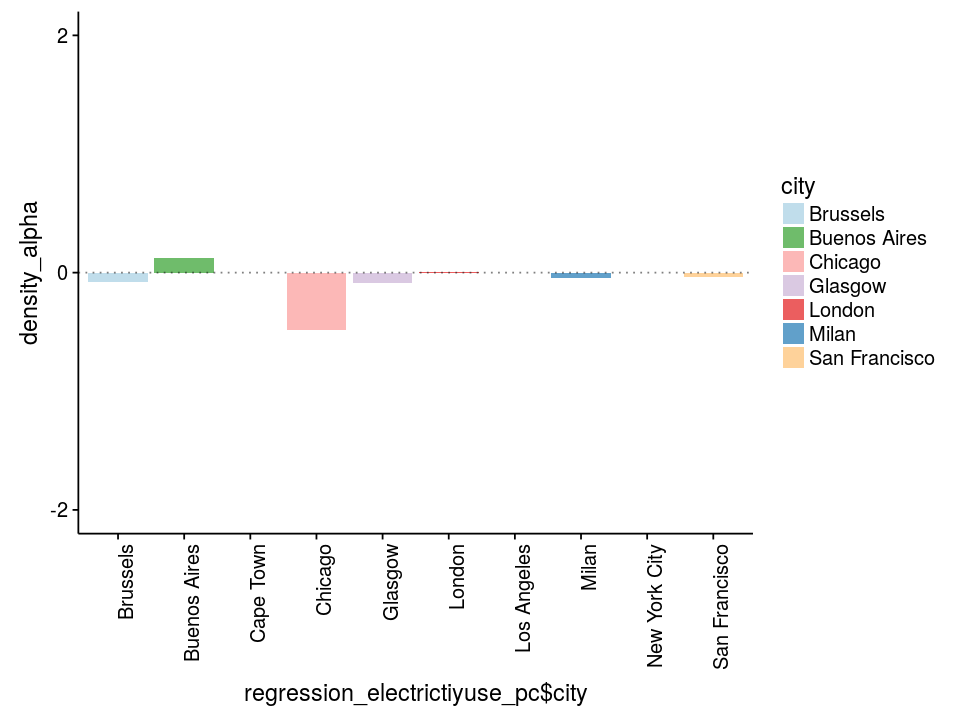

Warning message:
“Removed 4 rows containing missing values (position_stack).”

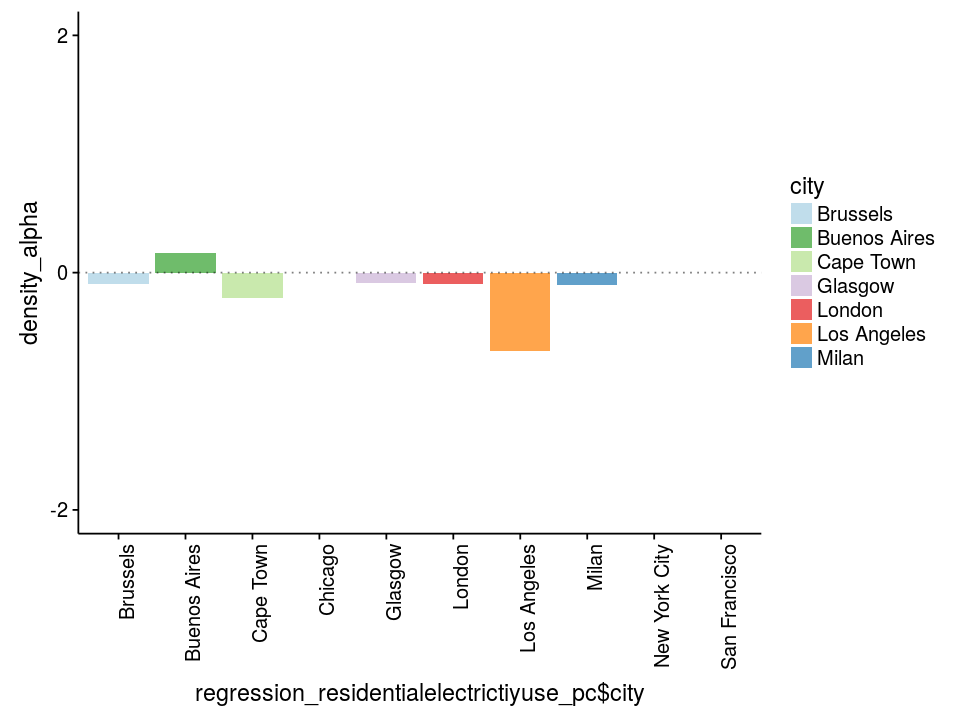

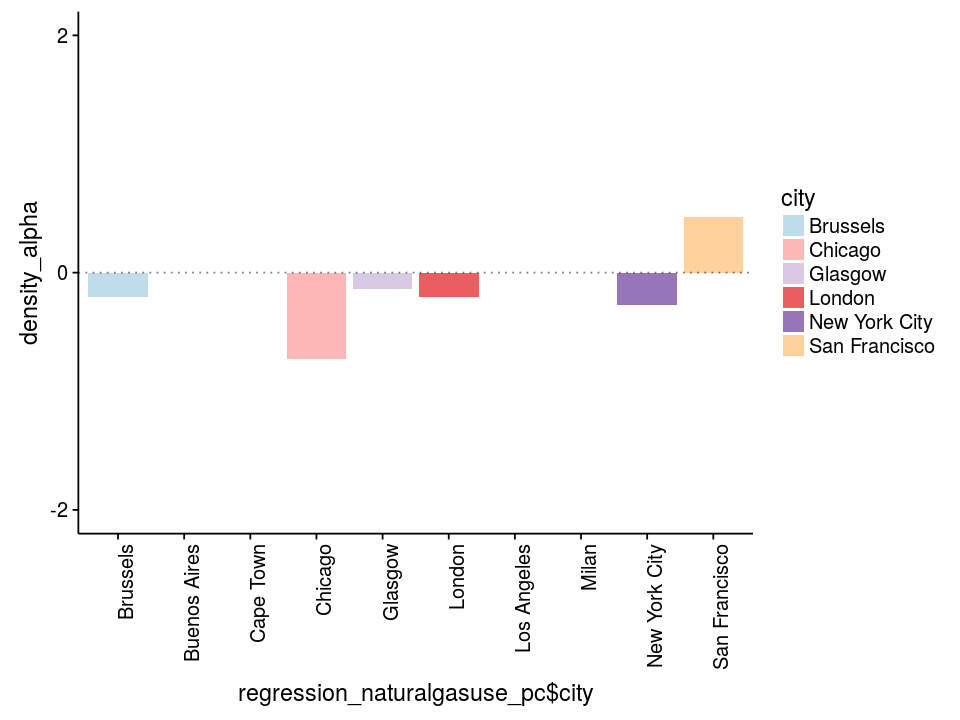

In [304]:
#density

options(repr.plot.width=8, repr.plot.height=6)

ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, density_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, density_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, density_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale


Warning message:
“Removed 4 rows containing missing values (position_stack).”

Warning message:
“Removed 4 rows containing missing values (position_stack).”

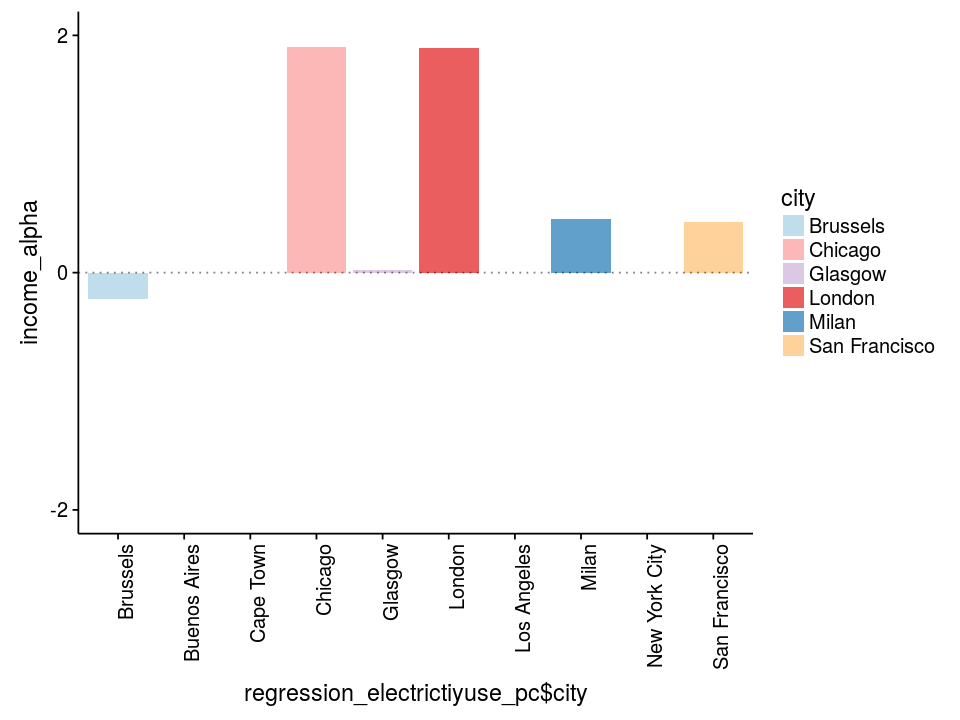

Warning message:
“Removed 5 rows containing missing values (position_stack).”

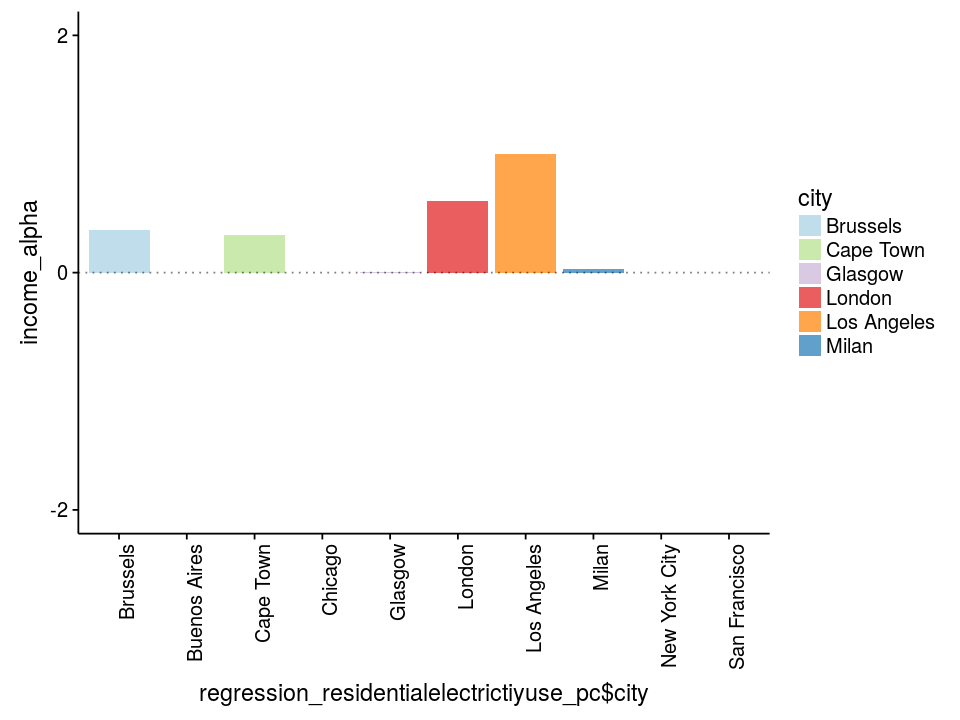

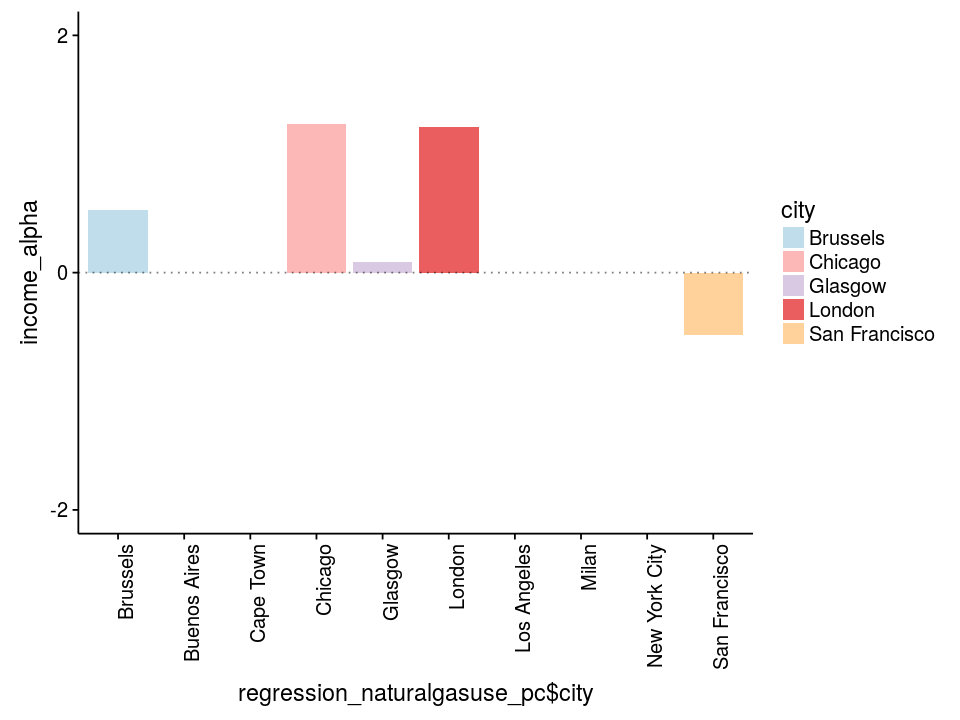

In [148]:
# income

ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, income_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, income_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, income_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale


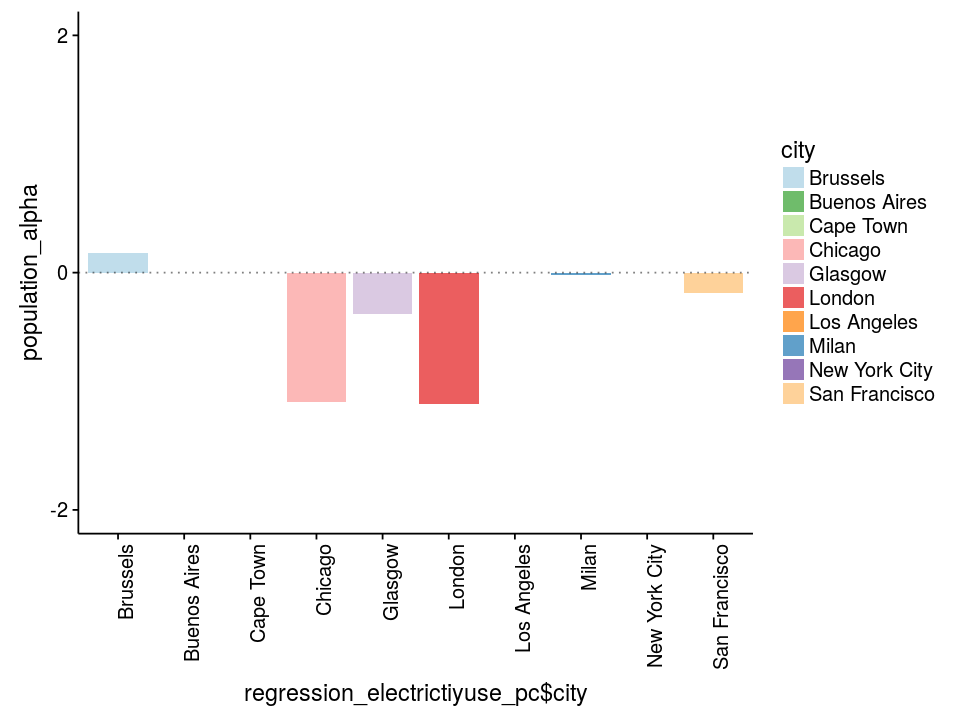

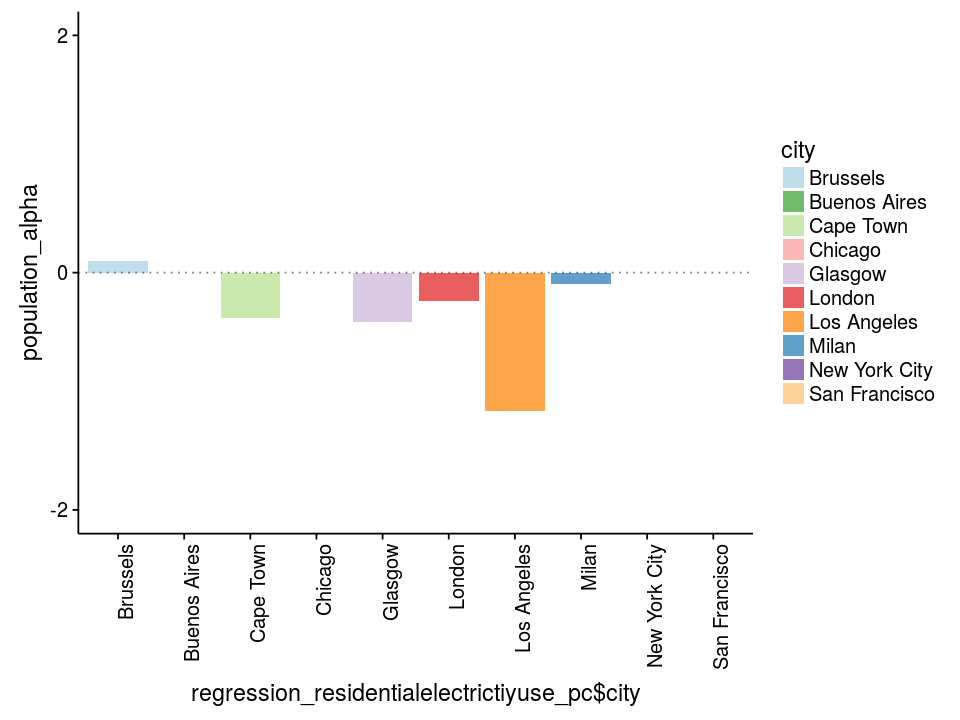

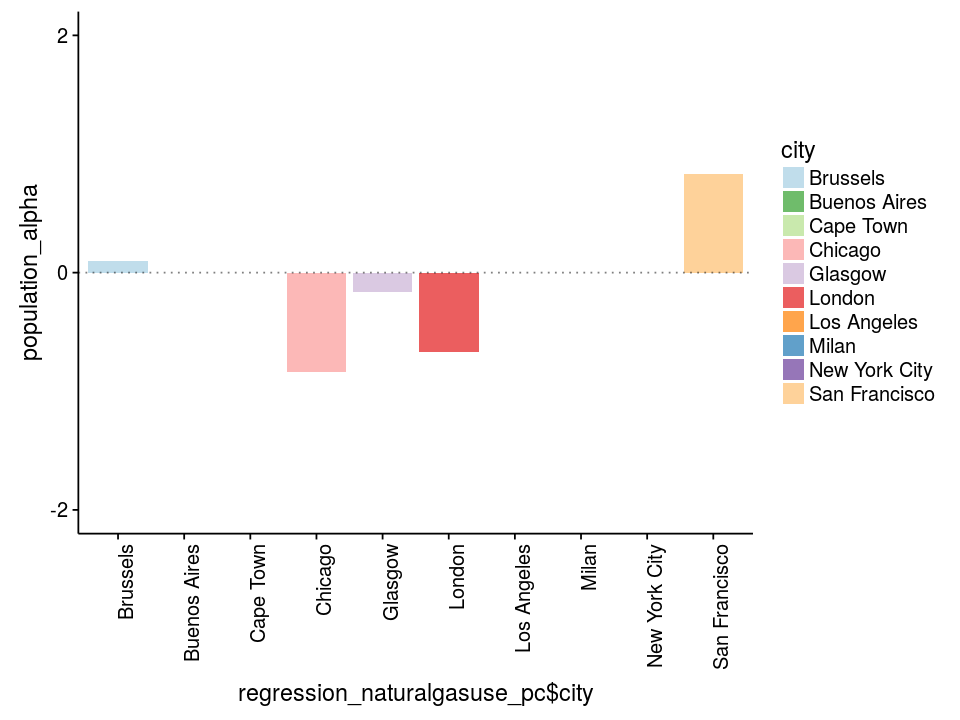

In [149]:
#population 

ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, population_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, population_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, population_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale


In [ ]:
#panel

######### CISBAT #############
et_d <- ggplot(cisbat, aes(log(density), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ylab("log( electricity [MWh] )")+ggtitle("log( density [hab/m2] )")
et_i <- ggplot(cisbat[cisbat$householdIncome_usd>1,], aes(log(householdIncome_usd), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank(),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ggtitle("log( income [USD] )")
et_p <- ggplot(cisbat, aes(log(population), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank(),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ggtitle("log( population [habitants] )")

er_d <- ggplot(cisbat, aes(log(density), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10), plot.title = element_text(hjust = 0.5))+ colScale+ylab("log( res. electricity [MWh] )")
er_i <- ggplot(cisbat[cisbat$householdIncome_usd>1,], aes(log(householdIncome_usd), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
er_p <- ggplot(cisbat, aes(log(population), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale

ng_d <- ggplot(cisbat[cisbat$density>1000,], aes(log(density), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10), plot.title = element_text(hjust = 0.5))+ colScale+ylab("log( nat. gas [MWh] )")
ng_i <- ggplot(cisbat[cisbat$householdIncome_usd>1,], aes(log(householdIncome_usd), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
ng_p <- ggplot(cisbat, aes(log(population), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
#########################



In [150]:
et_d_i <- ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, density_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
et_i_i <- ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, income_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
et_p_i <- ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, population_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale

er_d_i <- ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, density_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
er_i_i <- ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, income_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
er_p_i <- ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, population_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale

ng_d_i <- ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, density_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
ng_i_i <- ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, income_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
ng_p_i <- ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, population_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale


Warning message:
“Removed 3 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 3 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 5 rows containing missing values (position_stack).”

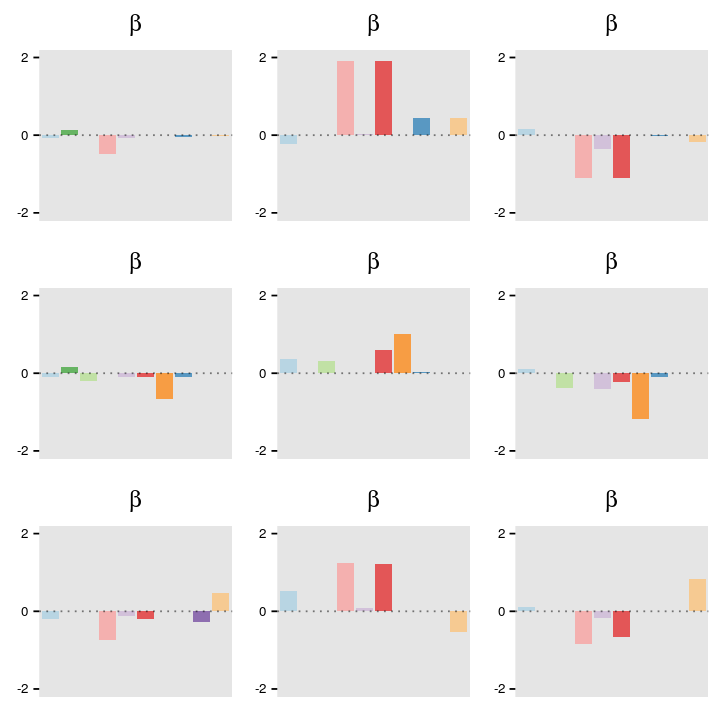

In [141]:
options(repr.plot.width=6, repr.plot.height=6)
plot_grid(et_d_i, et_i_i, et_p_i, er_d_i, er_i_i, er_p_i, ng_d_i, ng_i_i, ng_p_i, 
          align="hv",
          ncol = 3, nrow = 3)

In [ ]:
# multilinear

In [408]:
str(cisbat)

Classes ‘data.table’ and 'data.frame':	796 obs. of  12 variables:
 $ city                                   : atomic  Brussels Brussels Brussels Brussels ...
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr  "Anderlecht" "Auderghem" "Berchem-Sainte-Agathe" "Bruxelles" ...
 $ electricityUse_mwh                     : num  414529 115318 72618 1673883 179947 ...
 $ residencialElectricityUse_mwh          : num  193107 61108 40777 441543 88999 ...
 $ naturalGasUse_mwh                      : num  859392 276504 154773 2249191 382527 ...
 $ population                             : num  115178 32560 23690 170407 46427 ...
 $ density                                : num  6507 3618 8169 5227 14976 ...
 $ householdIncome_usd                    : num  22887 35382 29020 24930 27891 ...
 $ householdIncome_PPP                    : num  28672 44326 36355 31232 34941 ...
 $ naturalGasUse_percapita_mwh            : num  7.46 8.

In [410]:
rg_ec <- lm(electricityUse_mwh ~ population+density+householdIncome_PPP, na.action=na.exclude, data = cisbat)
summary(rg_ec)


Call:
lm(formula = electricityUse_mwh ~ population + density + householdIncome_PPP, 
    data = cisbat, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-2811795   -89219    90747   186963 10402356 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.431e+05  7.092e+04   2.018   0.0443 *  
population           1.167e+01  4.344e-01  26.862  < 2e-16 ***
density             -1.183e+01  5.202e+00  -2.275   0.0234 *  
householdIncome_PPP -7.754e+00  1.646e+00  -4.712 3.41e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 788700 on 396 degrees of freedom
  (396 observations deleted due to missingness)
Multiple R-squared:  0.6538,	Adjusted R-squared:  0.6512 
F-statistic: 249.3 on 3 and 396 DF,  p-value: < 2.2e-16


In [411]:
rg_rec <- lm(residencialElectricityUse_mwh ~ population+density+householdIncome_PPP, na.action=na.exclude, data = cisbat)
summary(rg_rec)


Call:
lm(formula = residencialElectricityUse_mwh ~ population + density + 
    householdIncome_PPP, data = cisbat, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-870649  -65552   -8016   69164 3969798 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         13189.8831 27255.7594   0.484    0.629    
population              3.4177     0.1624  21.047  < 2e-16 ***
density               -14.5027     3.3658  -4.309 1.97e-05 ***
householdIncome_PPP     3.1566     0.5339   5.912 6.21e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 292700 on 506 degrees of freedom
  (286 observations deleted due to missingness)
Multiple R-squared:  0.5567,	Adjusted R-squared:  0.554 
F-statistic: 211.8 on 3 and 506 DF,  p-value: < 2.2e-16


In [412]:
rg_ngc <- lm(naturalGasUse_mwh ~ population+density+householdIncome_PPP, na.action=na.exclude, data = cisbat)
summary(rg_ngc)


Call:
lm(formula = naturalGasUse_mwh ~ population + density + householdIncome_PPP, 
    data = cisbat, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-660508  -96979  -62719   68204 1336343 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         75280.4283 19723.3477   3.817 0.000155 ***
population              6.5029     0.1612  40.341  < 2e-16 ***
density                -4.7484     1.0409  -4.562 6.58e-06 ***
householdIncome_PPP     1.3275     0.2560   5.185 3.30e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 234100 on 441 degrees of freedom
  (351 observations deleted due to missingness)
Multiple R-squared:  0.7961,	Adjusted R-squared:  0.7948 
F-statistic: 574.1 on 3 and 441 DF,  p-value: < 2.2e-16


In [432]:
apsrtable(rg_ec, rg_rec, rg_ngc, digits=1, align="center", 
               stars="default", model.counter=0, order="rl")

\begin{table}[!ht]
\caption{}
\label{} 
\begin{tabular}{ c D{.}{.}{-1}D{.}{.}{-1}D{.}{.}{-1} } 
\hline 
  & \multicolumn{ 1 }{ c }{ Model 0 } & \multicolumn{ 1 }{ c }{ Model 1 } & \multicolumn{ 1 }{ c }{ Model 2 } \\ \hline
 %                     & Model 0        & Model 1        & Model 2       \\ 
(Intercept)           & 143115.9 ^*    & 13189.9        & 75280.4 ^{***}\\ 
                      & (70925.0)      & (27255.8)      & (19723.3)     \\ 
population            & 11.7 ^{***}    & 3.4 ^{***}     & 6.5 ^{***}    \\ 
                      & (0.4)          & (0.2)          & (0.2)         \\ 
density               & -11.8 ^*       & -14.5 ^{***}   & -4.7 ^{***}   \\ 
                      & (5.2)          & (3.4)          & (1.0)         \\ 
householdIncome\_PPP & -7.8 ^{***}    & 3.2 ^{***}     & 1.3 ^{***}    \\ 
                      & (1.6)          & (0.5)          & (0.3)          \\
 $N$                   & 400            & 510            & 445           \\ 
$R^2$          

### No Outliers

In [11]:
str(cisbat)
cisbat_clean_pre <- cisbat 

Classes ‘data.table’ and 'data.frame':	796 obs. of  12 variables:
 $ city                                   : atomic  Brussels Brussels Brussels Brussels ...
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr  "Anderlecht" "Auderghem" "Berchem-Sainte-Agathe" "Bruxelles" ...
 $ electricityUse_mwh                     : num  414529 115318 72618 1673883 179947 ...
 $ residencialElectricityUse_mwh          : num  193107 61108 40777 441543 88999 ...
 $ naturalGasUse_mwh                      : num  859392 276504 154773 2249191 382527 ...
 $ population                             : num  115178 32560 23690 170407 46427 ...
 $ density                                : num  6507 3618 8169 5227 14976 ...
 $ householdIncome_usd                    : num  22887 35382 29020 24930 27891 ...
 $ householdIncome_PPP                    : num  28672 44326 36355 31232 34941 ...
 $ naturalGasUse_percapita_mwh            : num  7.46 8.

In [10]:
remove_outliers <- function(x, na.rm = TRUE, ...) {
  qnt <- quantile(x, probs=c(.25, .75), na.rm = na.rm, ...)
  H <- 1.5 * IQR(x, na.rm = na.rm)
  y <- x
  y[x < (qnt[1] - H)] <- NA
  y[x > (qnt[2] + H)] <- NA
  y
}

In [12]:
cisbat_clean <- subset(cisbat_clean_pre, FALSE)
str(cisbat_clean)

Classes ‘data.table’ and 'data.frame':	0 obs. of  12 variables:
 $ city                                   : atomic  
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr 
 $ electricityUse_mwh                     : num 
 $ residencialElectricityUse_mwh          : num 
 $ naturalGasUse_mwh                      : num 
 $ population                             : num 
 $ density                                : num 
 $ householdIncome_usd                    : num 
 $ householdIncome_PPP                    : num 
 $ naturalGasUse_percapita_mwh            : num 
 $ electricityUse_percapita_mwh           : num 
 $ residencialElectricityUse_percapita_mwh: num 
 - attr(*, ".internal.selfref")=<externalptr> 


In [13]:


for (cit in unique(cisbat_clean_pre$city)) {
  print(cit)

  data <- cisbat_clean_pre[cisbat_clean_pre$city==cit,]
    print(nrow(data))
    data$electricityUse_mwh <- remove_outliers(data$electricityUse_mwh)
    data$naturalGasUse_mwh <- remove_outliers(data$naturalGasUse_mwh)
    data$population <- remove_outliers(data$population)
    data$density <- remove_outliers(data$density)
    data$householdIncome_usd <- remove_outliers(data$householdIncome_usd)
    data$householdIncome_PPP <- remove_outliers(data$householdIncome_PPP)
    data$naturalGasUse_percapita_mwh <- remove_outliers(data$naturalGasUse_percapita_mwh)
    data$electricityUse_percapita_mwh <- remove_outliers(data$electricityUse_percapita_mwh)
    data$residencialElectricityUse_percapita_mwh <- remove_outliers(data$residencialElectricityUse_percapita_mwh)

    cisbat_clean <- rbind(cisbat_clean,data)
    print(nrow(cisbat_clean))
}

[1] "Brussels"
[1] 19
[1] 19
[1] "Milan"
[1] 134
[1] 153
[1] "Cape Town"
[1] 82
[1] 235
[1] "Buenos Aires"
[1] 25
[1] 260
[1] "Chicago"
[1] 58
[1] 318
[1] "London"
[1] 33
[1] 351
[1] "San Francisco"
[1] 23
[1] 374
[1] "Los Angeles"
[1] 109
[1] 483
[1] "Glasgow"
[1] 133
[1] 616
[1] "New York City"
[1] 180
[1] 796


In [30]:
######################################
####   Set the Cities as Levels   ####
######################################


levels(cisbat_clean$city) <- unique(cisbat_clean$city)

myColors <- brewer.pal(10,"Paired")
names(myColors) <- levels(cisbat_clean$city)
colScale <- scale_colour_manual(name = "city",values = myColors)
filScale <- scale_fill_manual(name = "city",values = myColors)

In [21]:
str(cisbat_clean)

Classes ‘data.table’ and 'data.frame':	796 obs. of  12 variables:
 $ city                                   : atomic  Brussels Brussels Brussels Brussels ...
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr  "Anderlecht" "Auderghem" "Berchem-Sainte-Agathe" "Bruxelles" ...
 $ electricityUse_mwh                     : num  414529 115318 72618 NA 179947 ...
 $ residencialElectricityUse_mwh          : num  193107 61108 40777 441543 88999 ...
 $ naturalGasUse_mwh                      : num  859392 276504 154773 NA 382527 ...
 $ population                             : num  115178 32560 23690 NA 46427 ...
 $ density                                : num  6507 3618 8169 5227 14976 ...
 $ householdIncome_usd                    : num  22887 35382 29020 24930 27891 ...
 $ householdIncome_PPP                    : num  28672 44326 36355 31232 34941 ...
 $ naturalGasUse_percapita_mwh            : num  7.46 8.49 6.53 NA 8.2

Warning message:
“Removed 20 rows containing non-finite values (stat_density).”

Warning message:
“Removed 36 rows containing non-finite values (stat_density).”

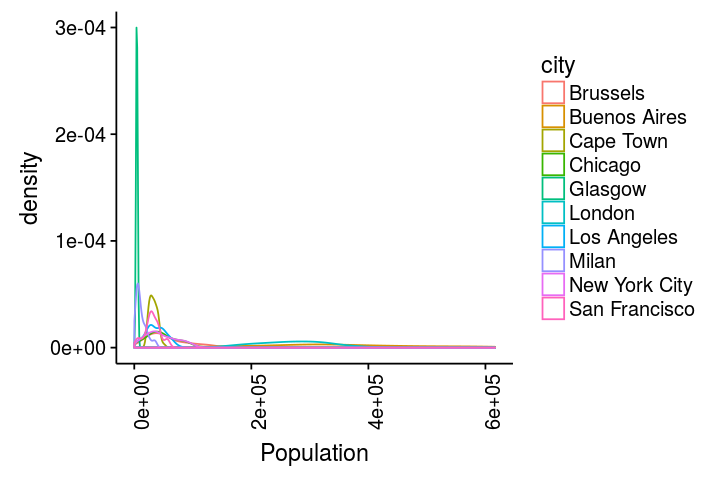

Warning message:
“Removed 67 rows containing non-finite values (stat_density).”

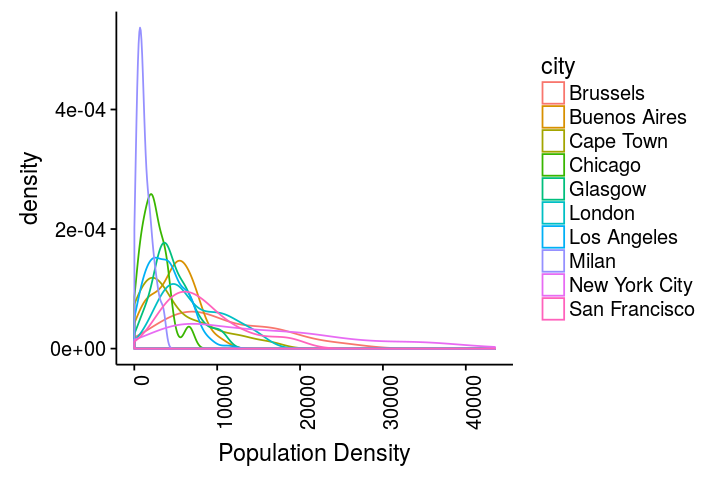

Warning message:
“Removed 385 rows containing non-finite values (stat_density).”

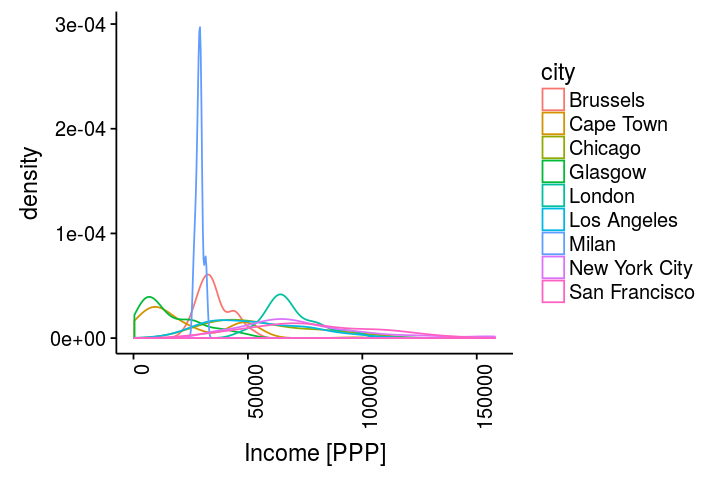

Warning message:
“Removed 400 rows containing non-finite values (stat_density).”

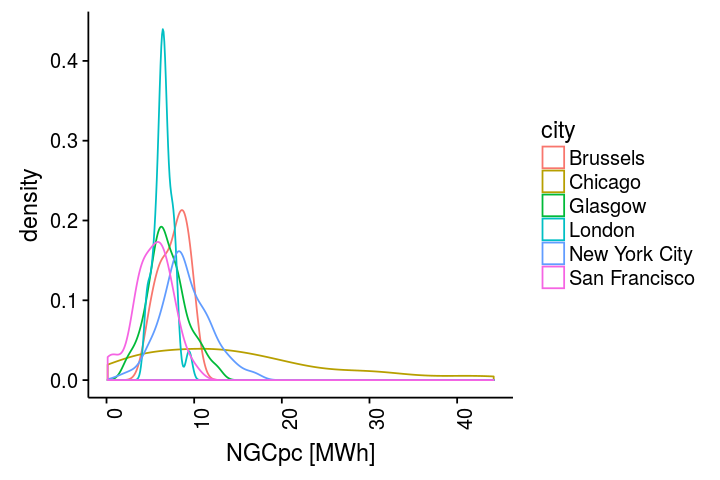

Warning message:
“Removed 299 rows containing non-finite values (stat_density).”

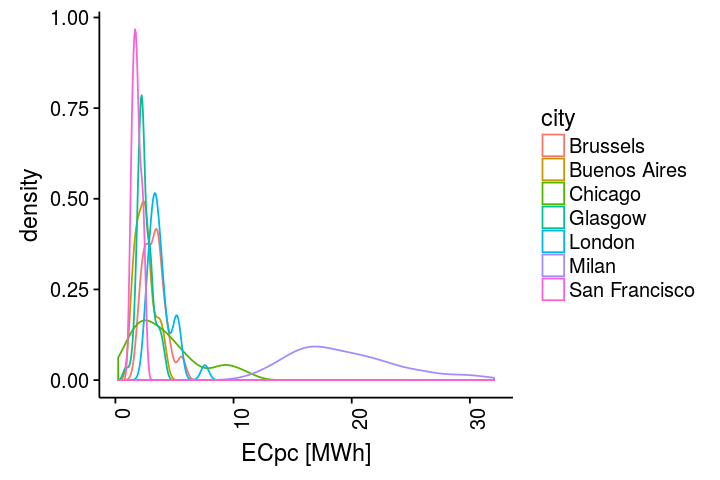

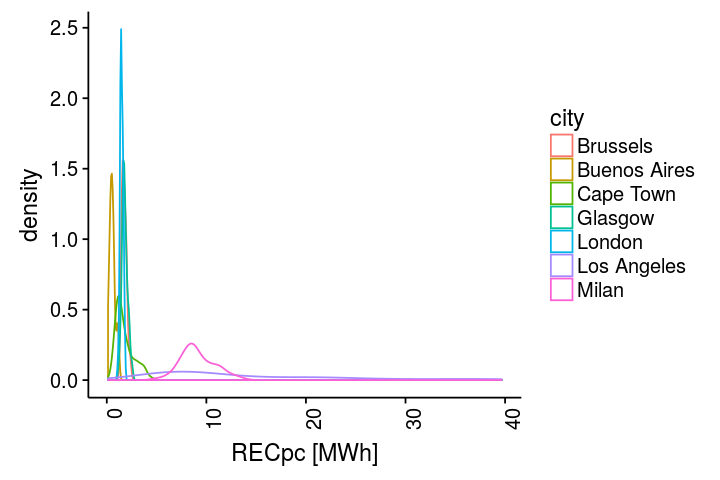

In [31]:
options(repr.plot.width=6, repr.plot.height=4)

ggplot(cisbat_clean)+geom_density(aes(population, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("Population")

ggplot(cisbat_clean)+geom_density(aes(density, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("Population Density")

ggplot(cisbat_clean)+geom_density(aes(householdIncome_PPP, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("Income [PPP]")

ggplot(cisbat_clean)+geom_density(aes(naturalGasUse_percapita_mwh, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("NGCpc [MWh]")

ggplot(cisbat_clean)+geom_density(aes(electricityUse_percapita_mwh, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("ECpc [MWh]")

ggplot(cisbat_clean)+geom_density(aes(residencialElectricityUse_percapita_mwh, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+xlab("RECpc [MWh]")


Warning message:
“Removed 20 rows containing non-finite values (stat_density).”

Warning message:
“Removed 36 rows containing non-finite values (stat_density).”

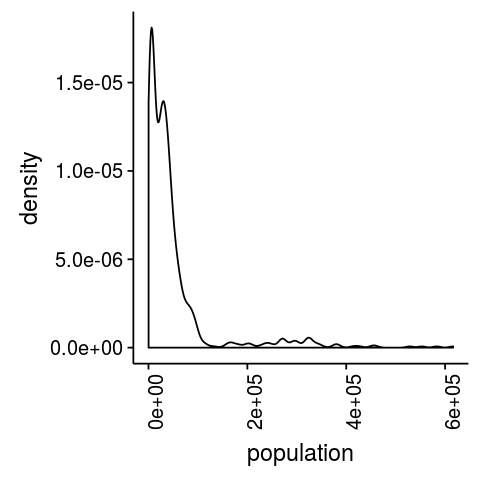

Warning message:
“Removed 67 rows containing non-finite values (stat_density).”

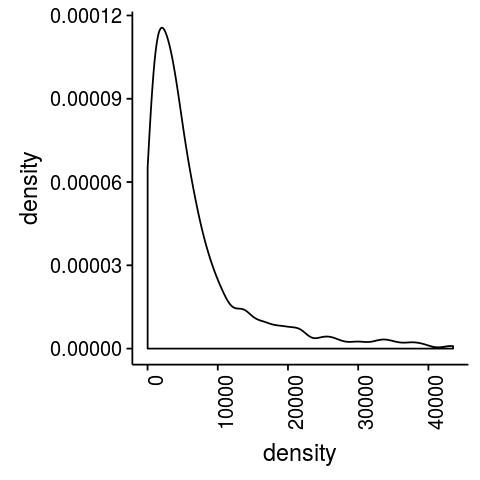

Warning message:
“Removed 385 rows containing non-finite values (stat_density).”

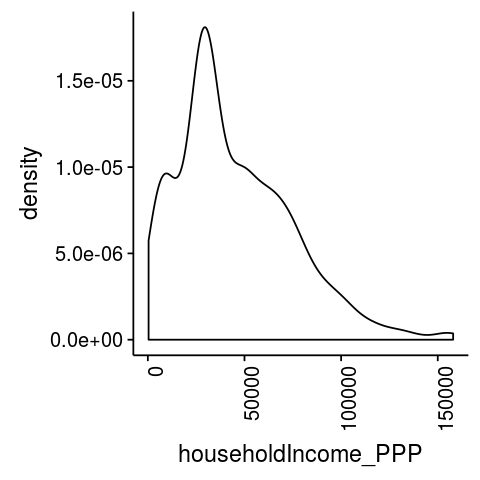

Warning message:
“Removed 400 rows containing non-finite values (stat_density).”

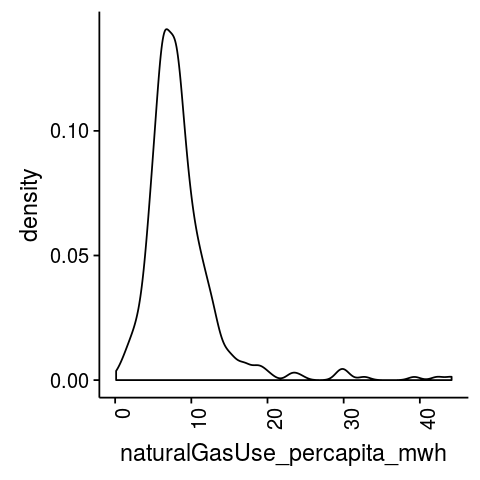

Warning message:
“Removed 299 rows containing non-finite values (stat_density).”

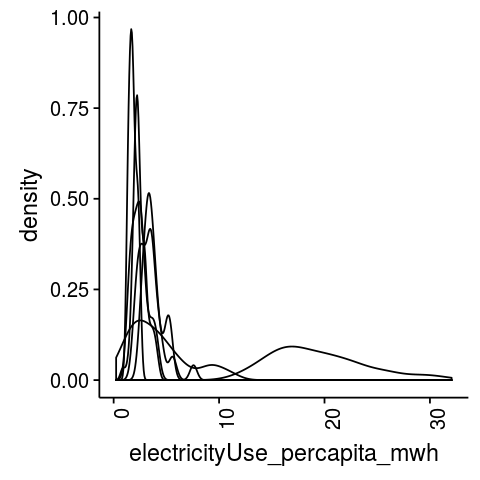

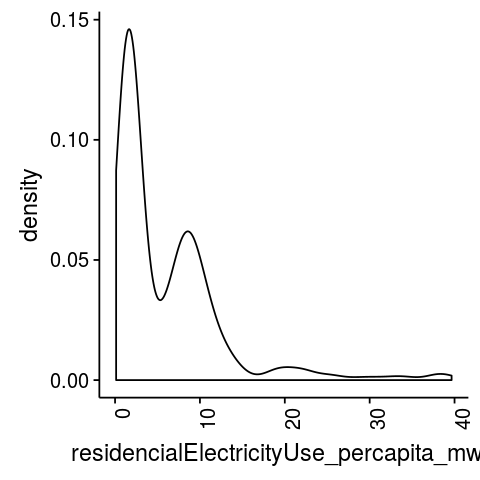

In [23]:
ggplot(cisbat_clean)+geom_density(aes(population))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(cisbat_clean)+geom_density(aes(density))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(cisbat_clean)+geom_density(aes(householdIncome_PPP))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(cisbat_clean)+geom_density(aes(naturalGasUse_percapita_mwh))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(cisbat_clean)+geom_density(aes(electricityUse_percapita_mwh, group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(cisbat_clean)+geom_density(aes(residencialElectricityUse_percapita_mwh))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


Warning message:
“Removed 20 rows containing non-finite values (stat_boxplot).”

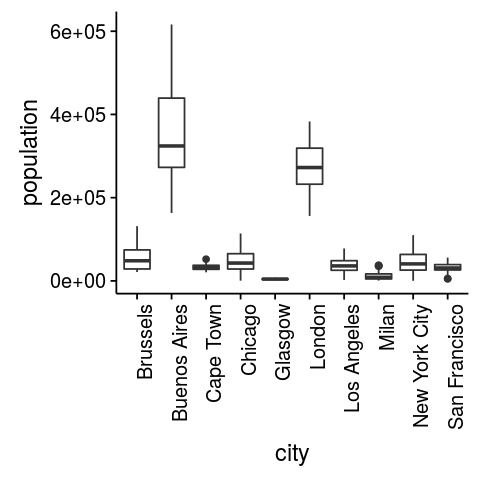

Warning message:
“Removed 36 rows containing non-finite values (stat_boxplot).”

Warning message:
“Removed 67 rows containing non-finite values (stat_boxplot).”

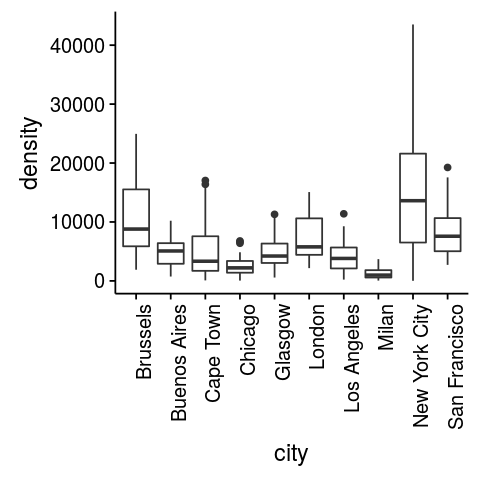

Warning message:
“Removed 395 rows containing non-finite values (stat_boxplot).”

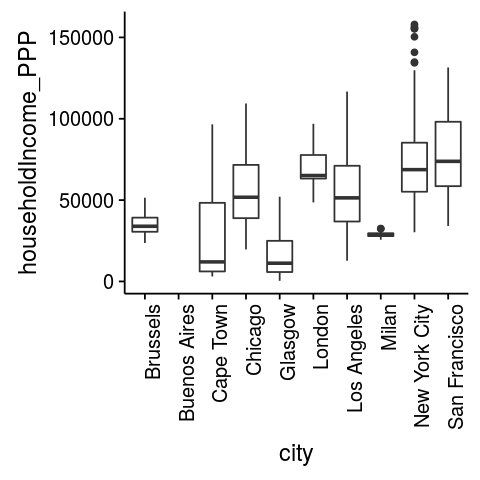

Warning message:
“Removed 400 rows containing non-finite values (stat_boxplot).”

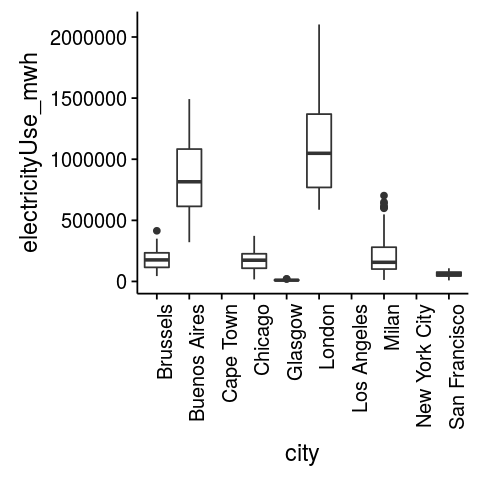

Warning message:
“Removed 261 rows containing non-finite values (stat_boxplot).”

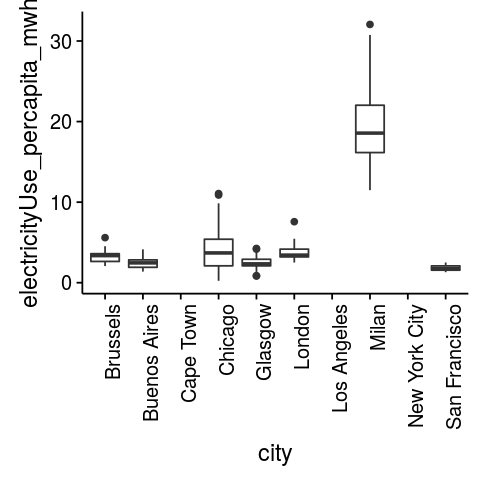

Warning message:
“Removed 299 rows containing non-finite values (stat_boxplot).”

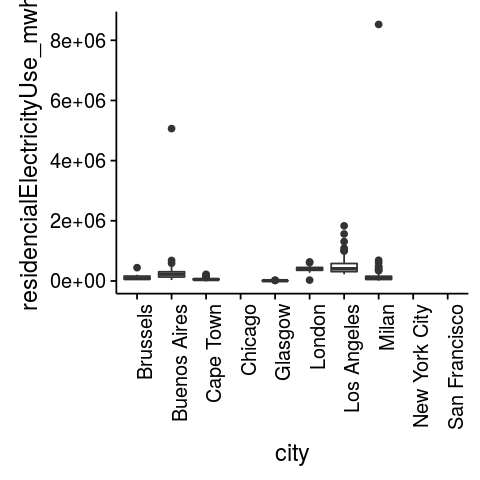

Warning message:
“Removed 361 rows containing non-finite values (stat_boxplot).”

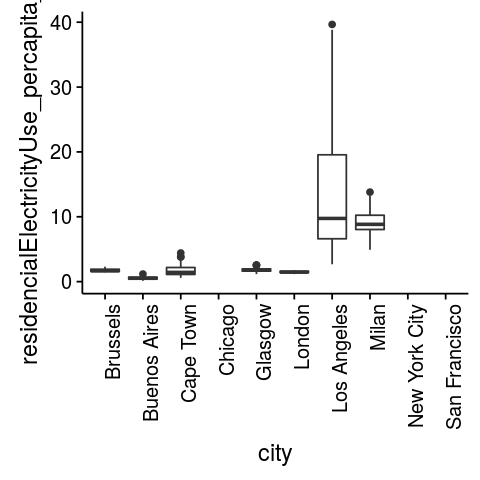

Warning message:
“Removed 385 rows containing non-finite values (stat_boxplot).”

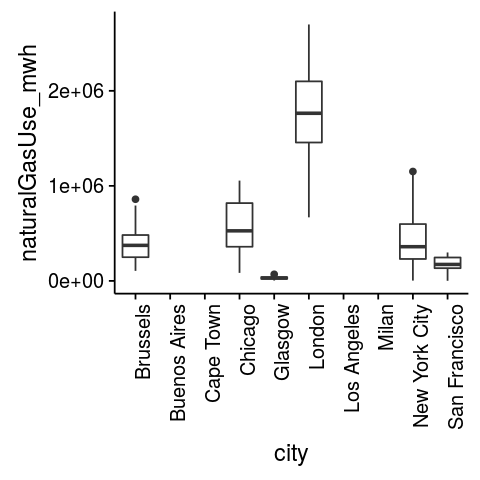

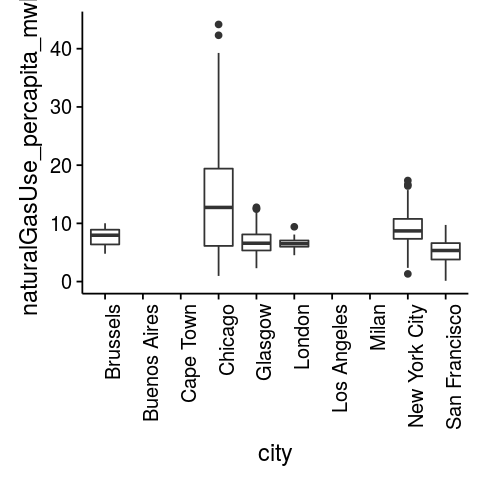

In [15]:
options(repr.plot.width=4, repr.plot.height=4)

#population
ggplot(cisbat_clean, aes(city, population))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))



#density
ggplot(cisbat_clean, aes(city, density))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#income
ggplot(cisbat_clean, aes(city, householdIncome_PPP))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#electricityUse_mwh
ggplot(cisbat_clean, aes(city, electricityUse_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

#pc
ggplot(cisbat_clean, aes(city, electricityUse_percapita_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))




#residencialElectricityUse_mwh
ggplot(cisbat_clean, aes(city, residencialElectricityUse_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))
#pc
ggplot(cisbat_clean, aes(city, residencialElectricityUse_percapita_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


#naturalGasUse_mwh
ggplot(cisbat_clean, aes(city, naturalGasUse_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))
#pc
ggplot(cisbat_clean, aes(city, naturalGasUse_percapita_mwh))+geom_boxplot()+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))


In [ ]:
###### correlation

EC    REC   NGC   pop   density income NGCpc ECpc RECpc
EC       1.00  0.95  0.97  0.96  0.25    0.80  -0.07 0.67 -0.43
REC      0.95  1.00  0.99  0.99  0.22    0.82  -0.10 0.53 -0.40
NGC      0.97  0.99  1.00  0.99  0.21    0.83  -0.06 0.58 -0.41
pop      0.96  0.99  0.99  1.00  0.23    0.81  -0.12 0.53 -0.44
density  0.25  0.22  0.21  0.23  1.00    0.30  -0.17 0.25 -0.14
income   0.80  0.82  0.83  0.81  0.30    1.00   0.10 0.54 -0.31
NGCpc   -0.07 -0.10 -0.06 -0.12 -0.17    0.10   1.00 0.20  0.29
ECpc     0.67  0.53  0.58  0.53  0.25    0.54   0.20 1.00  0.09
RECpc   -0.43 -0.40 -0.41 -0.44 -0.14   -0.31   0.29 0.09  1.00

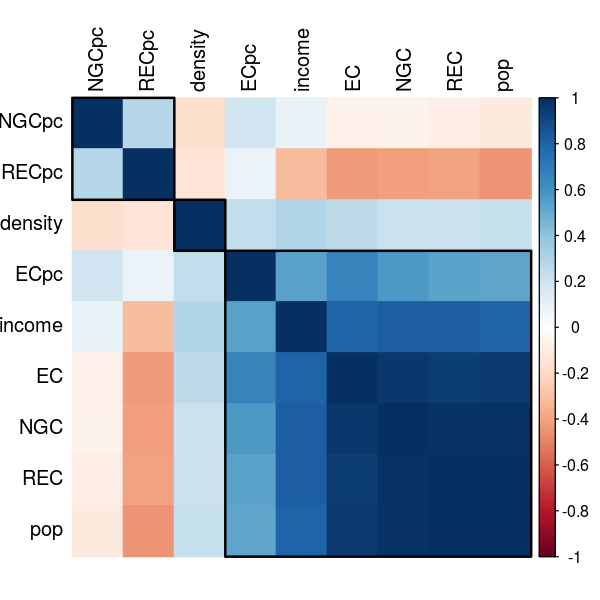

In [224]:
options(repr.plot.width=5, repr.plot.height=5)

cisbat_clean_data <- cisbat_clean[,-c(1,2,8)]

colnames(cisbat_clean_data) <- c(as.character(names[-c(1,2,8),2]))

M <- cor(cisbat_clean_data, use="complete.obs", method="pearson") #generates correlation matrix
write.csv(round(M,2), "cor_total.csv")
res1 <- cor.mtest(cisbat_clean_data,0.95)


corrplot(M, method = "color", tl.col="black", order = "hclust", addrect=3) #order by correlational level
#corrplot.mixed(M,  upper = "color", tl.col="black")
#corrplot(M, p.mat = res1[[1]], insig = "blank")
round(M,2)

[1] "Brussels"


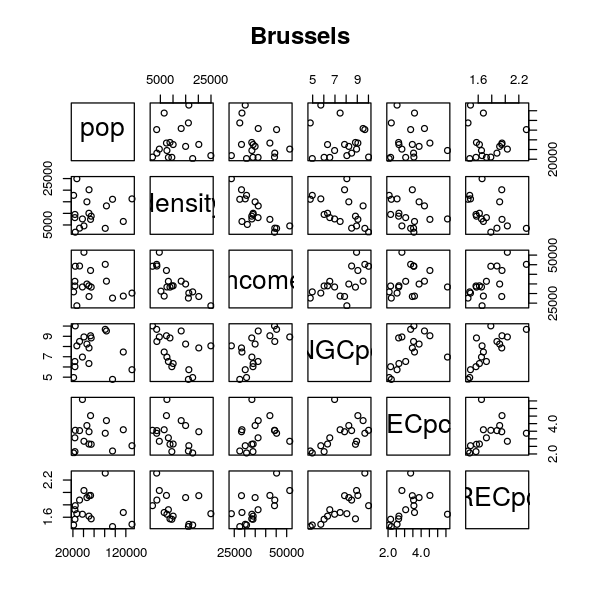

[1] "Milan"


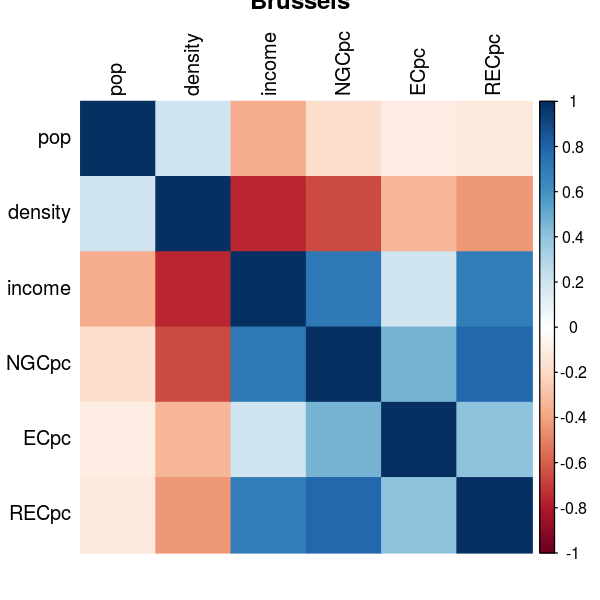

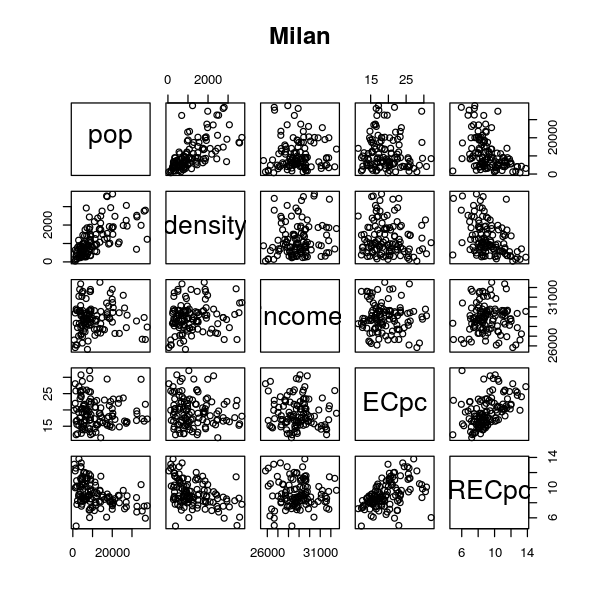

[1] "Cape Town"


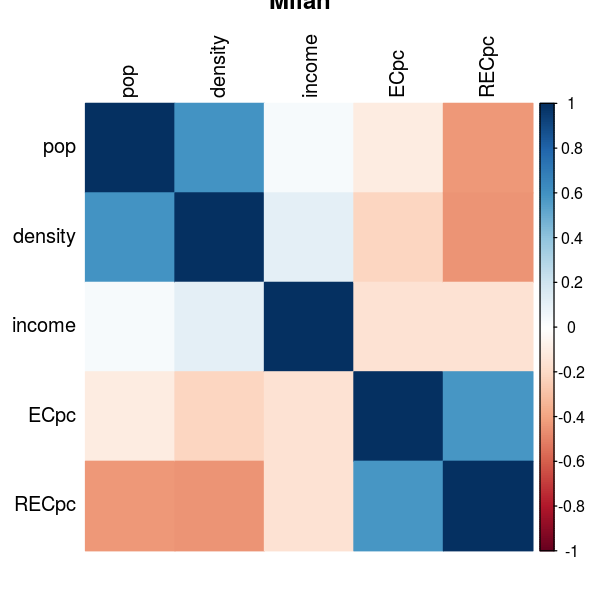

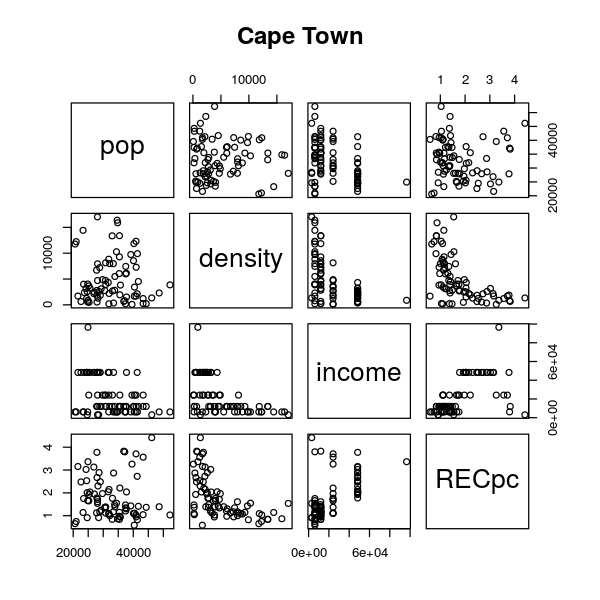

[1] "Buenos Aires"


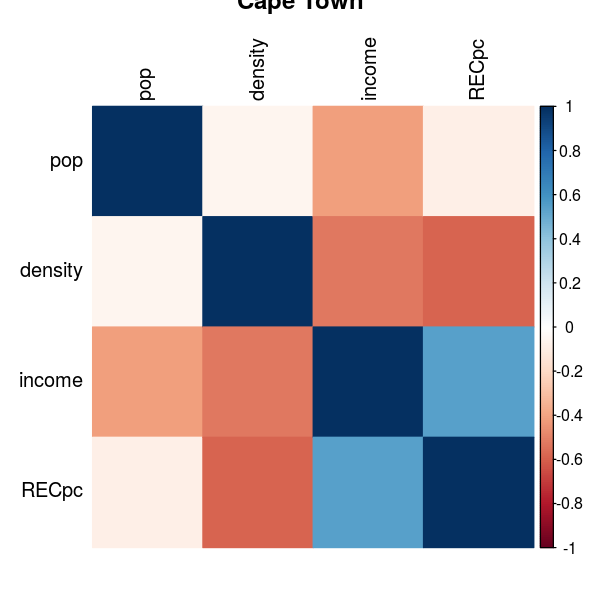

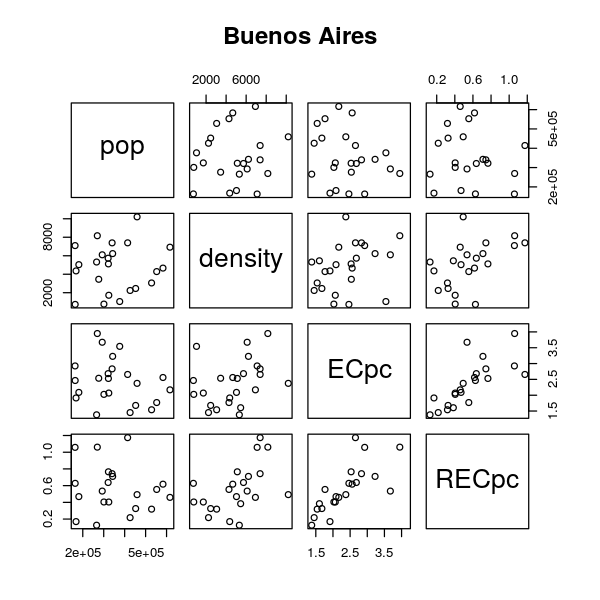

[1] "Chicago"


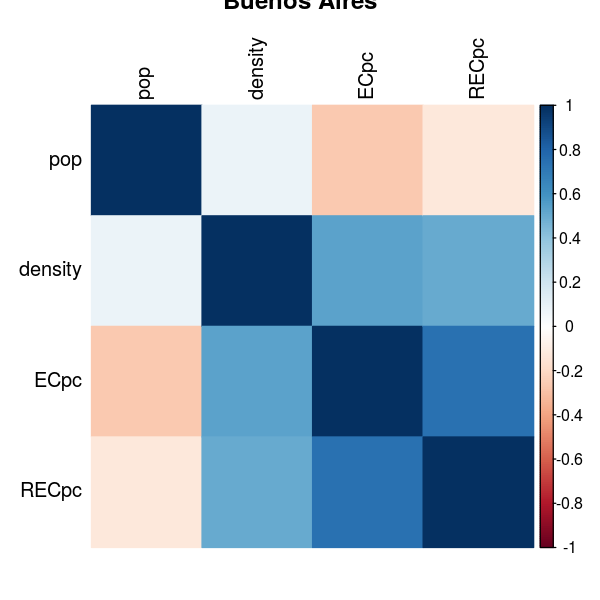

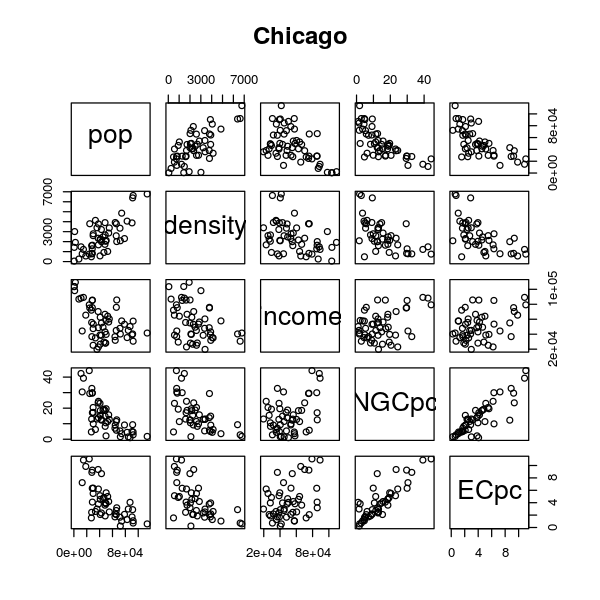

[1] "London"


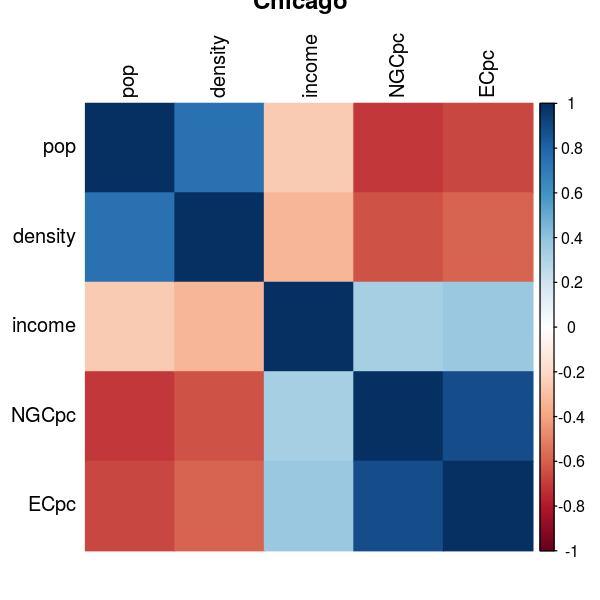

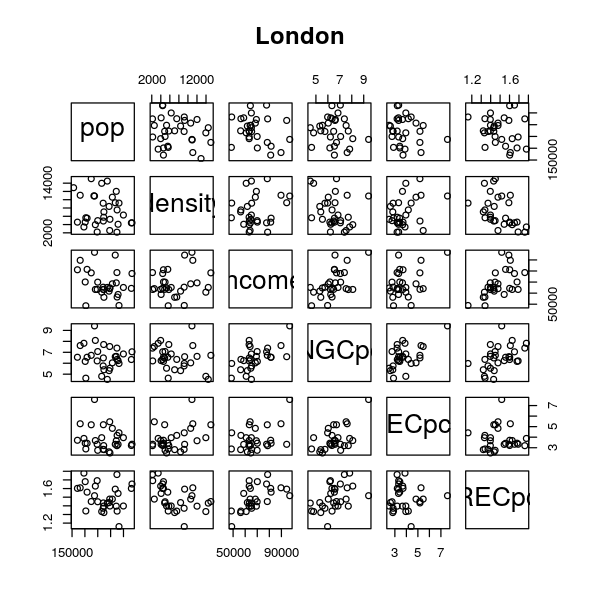

[1] "San Francisco"


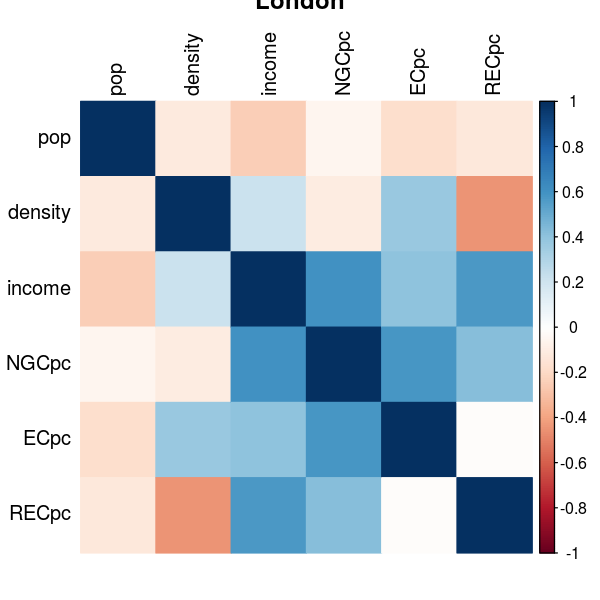

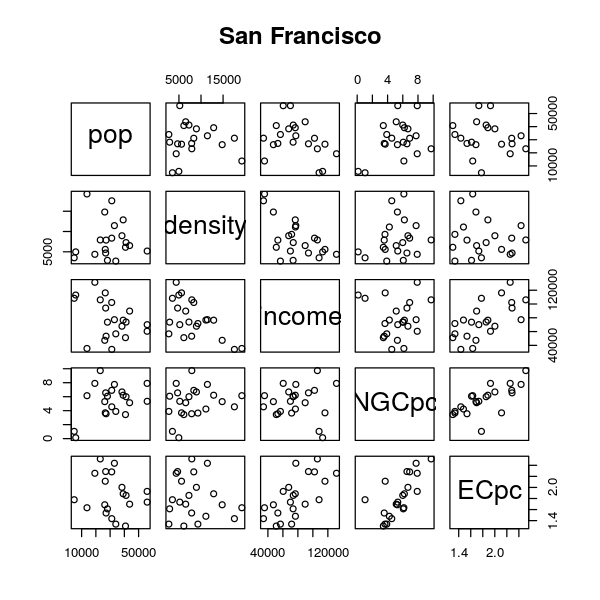

[1] "Los Angeles"


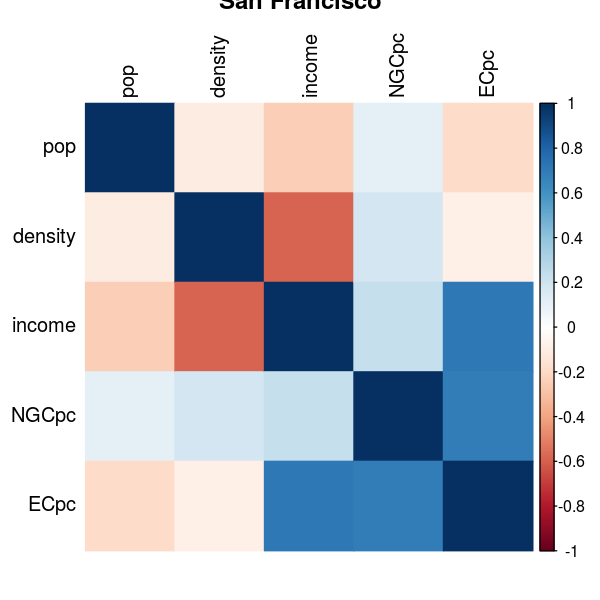

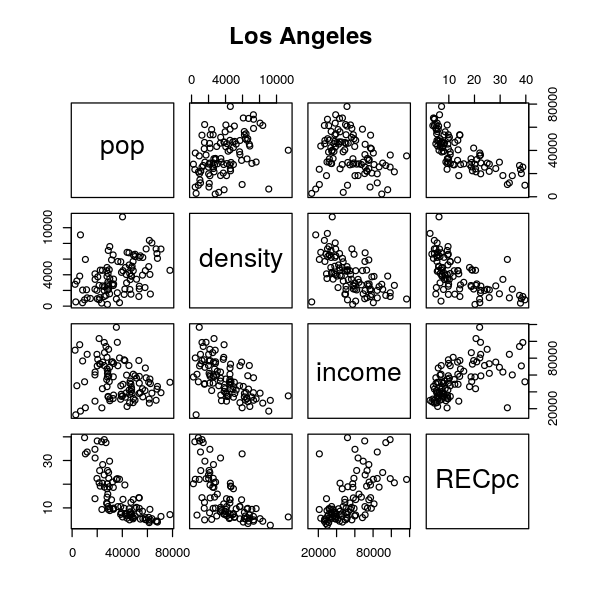

[1] "Glasgow"


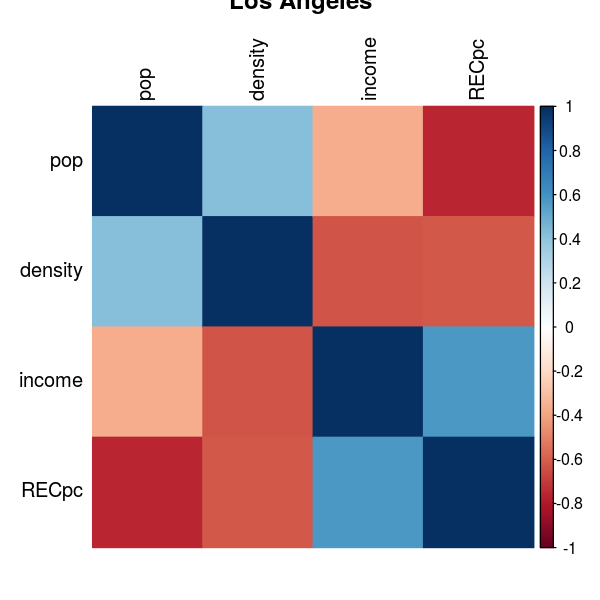

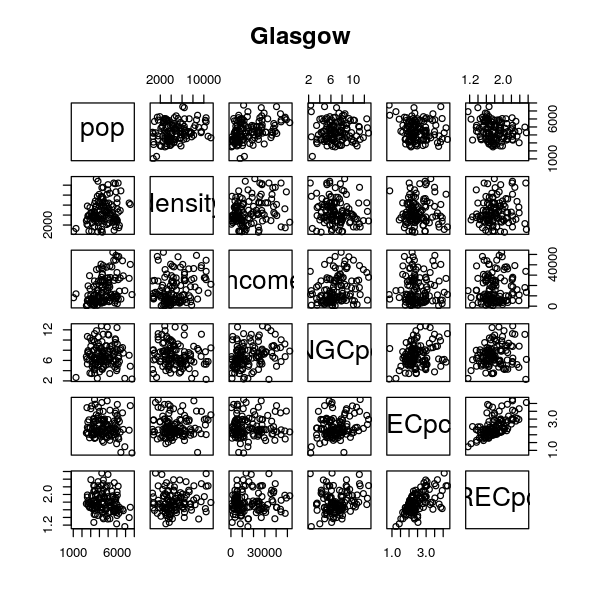

[1] "New York City"


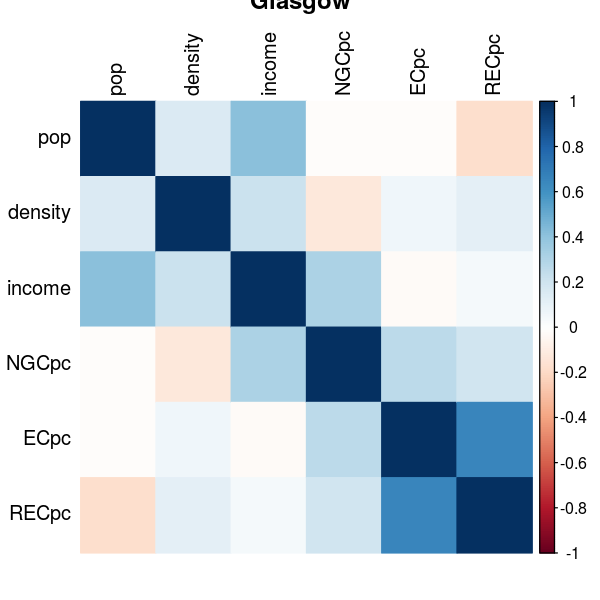

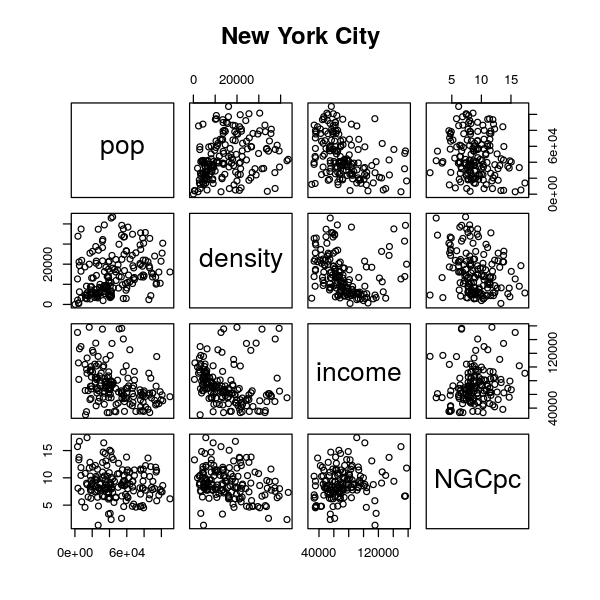

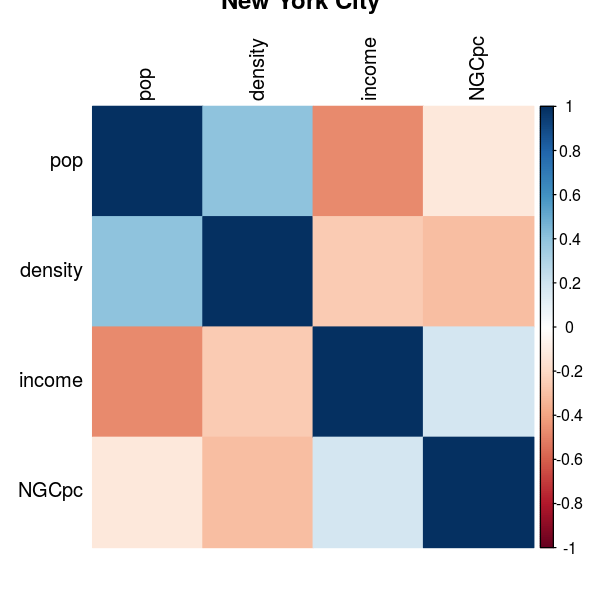

In [225]:
for (cit in unique(cisbat_clean$city)) {
  print(cit)
  data <- cisbat_clean[cisbat_clean$city==cit,]
    

    data2 <- data[,-c(1,2,3,4,5,8)]

    colnames(data2) <- c(as.character(names[-c(1,2,3,4,5,8),2]))
  

  data2 <-  Filter(function(x) !all(is.na(x)), data2)
  # M <- cor(data2, use="complete.obs", method="pearson") #generates correlation matrix
  pairs(data2, main = cit)
  M <- cor(data2, method="pearson", use = "complete.obs") #generates correlation matrix
  write.csv(round(M,2), paste ("cor_", cit, "_ng",".csv",  sep = ""))
  corrplot(M, method = "color", tl.col="black", title=cit) #order by correlational level
}


###### scatter plots

Warning message:
“Removed 423 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 423 rows containing missing values (geom_point).”

Warning message:
“Removed 373 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 373 rows containing missing values (geom_point).”

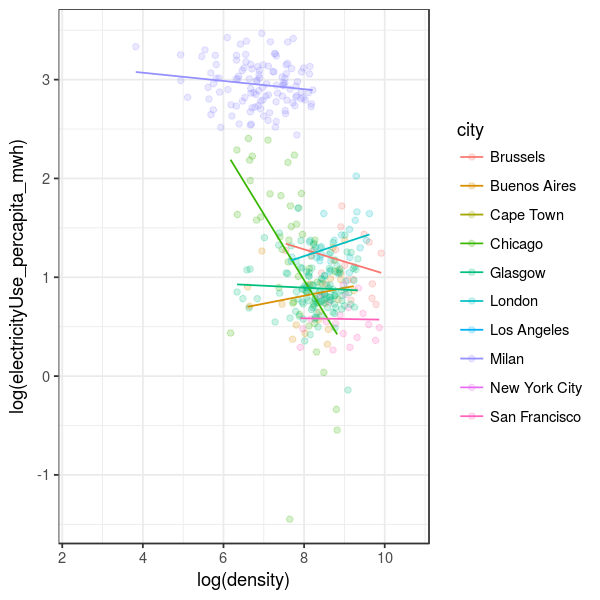

Warning message:
“Removed 412 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 412 rows containing missing values (geom_point).”

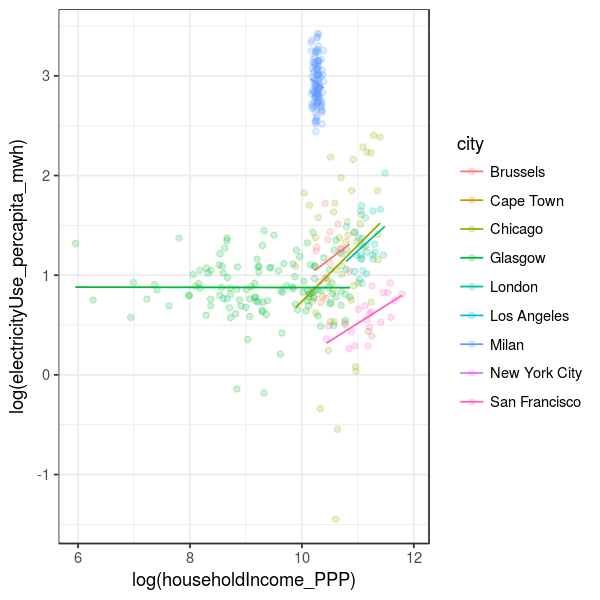

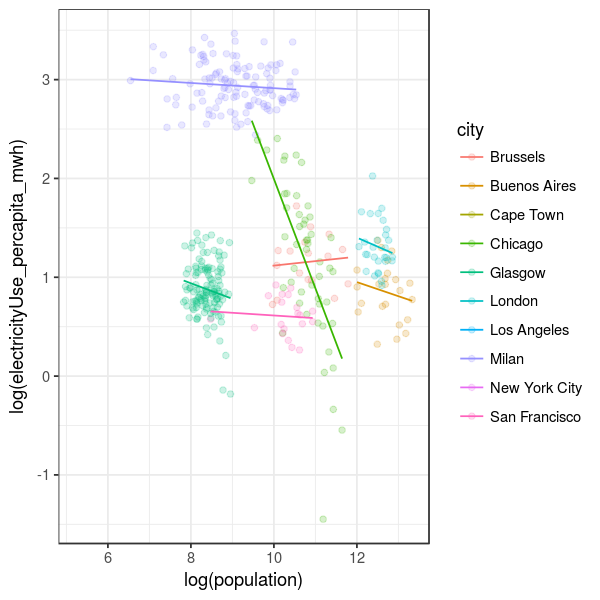

In [227]:
# ECpc
ggplot(cisbat_clean, aes(log(density), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat_clean[cisbat_clean$householdIncome_PPP>1,], aes(log(householdIncome_PPP), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat_clean, aes(log(population), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)



Warning message:
“Removed 321 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 321 rows containing missing values (geom_point).”

Warning message:
“Removed 270 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 270 rows containing missing values (geom_point).”

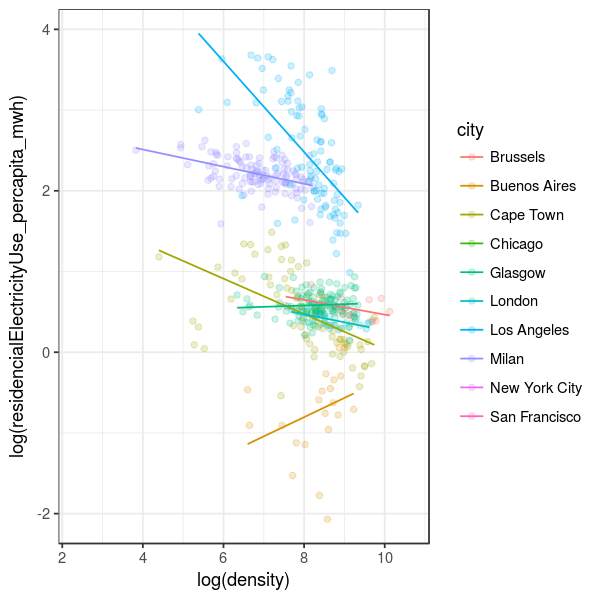

Warning message:
“Removed 314 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 314 rows containing missing values (geom_point).”

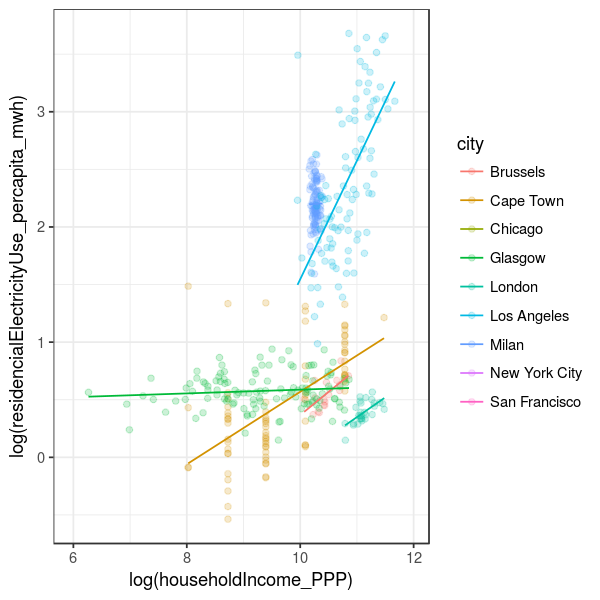

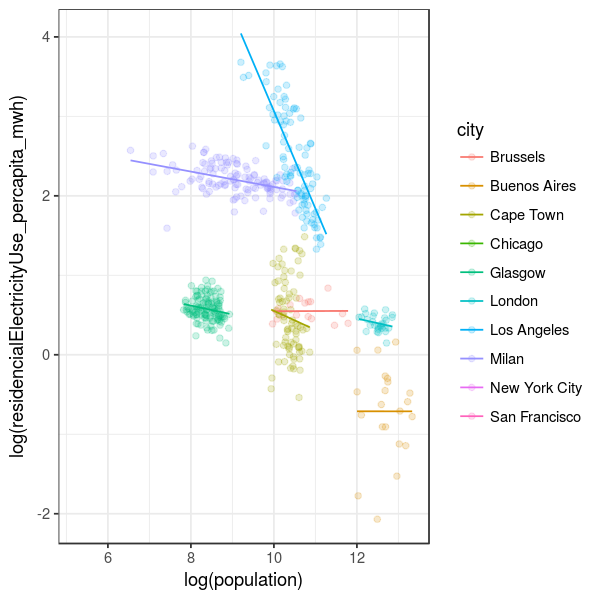

In [228]:
# RECpc
ggplot(cisbat_clean, aes(log(density), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat_clean[cisbat_clean$householdIncome_PPP>1,], aes(log(householdIncome_PPP), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat_clean, aes(log(population), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)


Warning message:
“Removed 271 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 271 rows containing missing values (geom_point).”

Warning message:
“Removed 334 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 334 rows containing missing values (geom_point).”

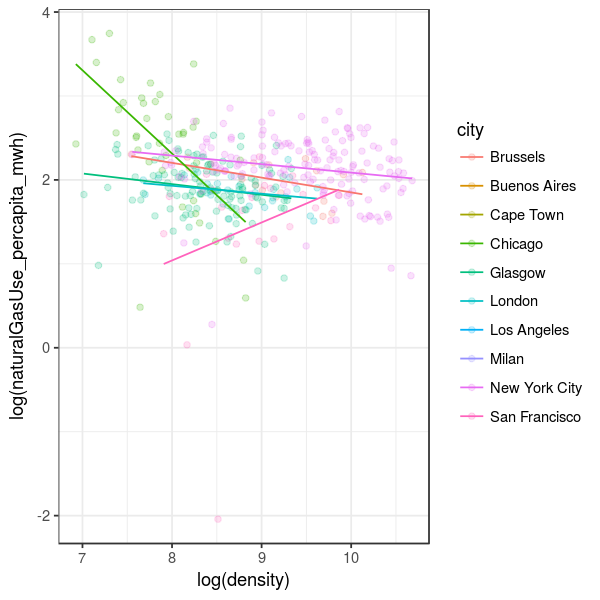

Warning message:
“Removed 388 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 388 rows containing missing values (geom_point).”

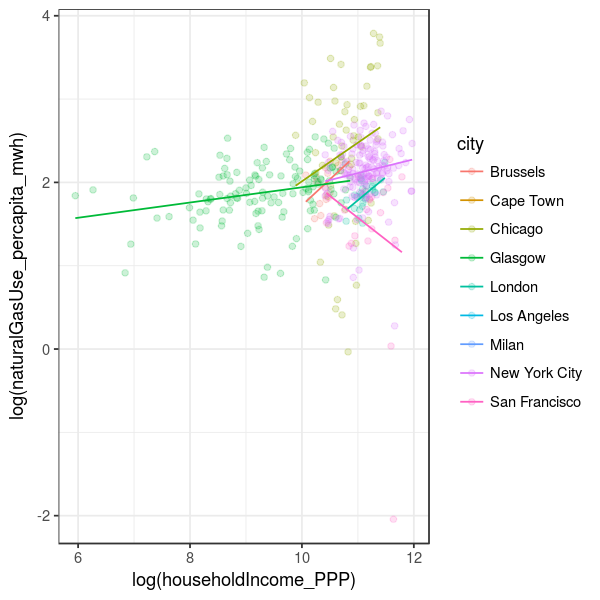

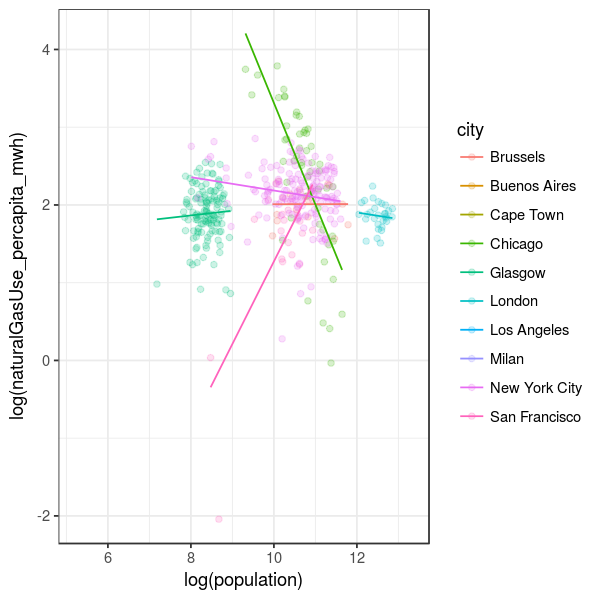

In [229]:
# NGCpc

ggplot(cisbat_clean[cisbat_clean$density>1000,], aes(log(density), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat_clean[cisbat_clean$householdIncome_PPP>1,], aes(log(householdIncome_PPP), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
ggplot(cisbat_clean, aes(log(population), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)
#########################

In [398]:
#panel

######### cisbat_clean #############
et_d <- ggplot(cisbat_clean, aes(log(density), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ylab("log( electricity [MWh] )")+ggtitle("log( density [hab/m2] )")
et_i <- ggplot(cisbat_clean[cisbat_clean$householdIncome_usd>1,], aes(log(householdIncome_usd), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank(),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ggtitle("log( income [USD] )")
et_p <- ggplot(cisbat_clean, aes(log(population), log(electricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank(),plot.title = element_text(size = 10,hjust = 0.5))+ colScale+ggtitle("log( population [habitants] )")

er_d <- ggplot(cisbat_clean, aes(log(density), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10), plot.title = element_text(hjust = 0.5))+ colScale+ylab("log( res. electricity [MWh] )")
er_i <- ggplot(cisbat_clean[cisbat_clean$householdIncome_usd>1,], aes(log(householdIncome_usd), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
er_p <- ggplot(cisbat_clean, aes(log(population), log(residencialElectricityUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale

ng_d <- ggplot(cisbat_clean[cisbat_clean$density>1000,], aes(log(density), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title.x=element_blank(),axis.title=element_text(size=10), plot.title = element_text(hjust = 0.5))+ colScale+ylab("log( nat. gas [MWh] )")
ng_i <- ggplot(cisbat_clean[cisbat_clean$householdIncome_usd>1,], aes(log(householdIncome_usd), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
ng_p <- ggplot(cisbat_clean, aes(log(population), log(naturalGasUse_percapita_mwh), group=city, col=city))+geom_point(alpha=0.2)+theme_bw()+ geom_line(stat='smooth', method = "lm", se=FALSE, alpha=1)+ theme(legend.position="none", axis.title=element_blank())+ colScale
#########################

Warning message:
“Removed 423 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 423 rows containing missing values (geom_point).”Warning message:
“Removed 373 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 373 rows containing missing values (geom_point).”Warning message:
“Removed 412 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 412 rows containing missing values (geom_point).”Warning message:
“Removed 321 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 321 rows containing missing values (geom_point).”Warning message:
“Removed 270 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 270 rows containing missing values (geom_point).”Warning message:
“Removed 314 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 314 rows containing missing values (geom_point).”Warning message:
“Removed 271 rows containing non-finite values (stat_smooth

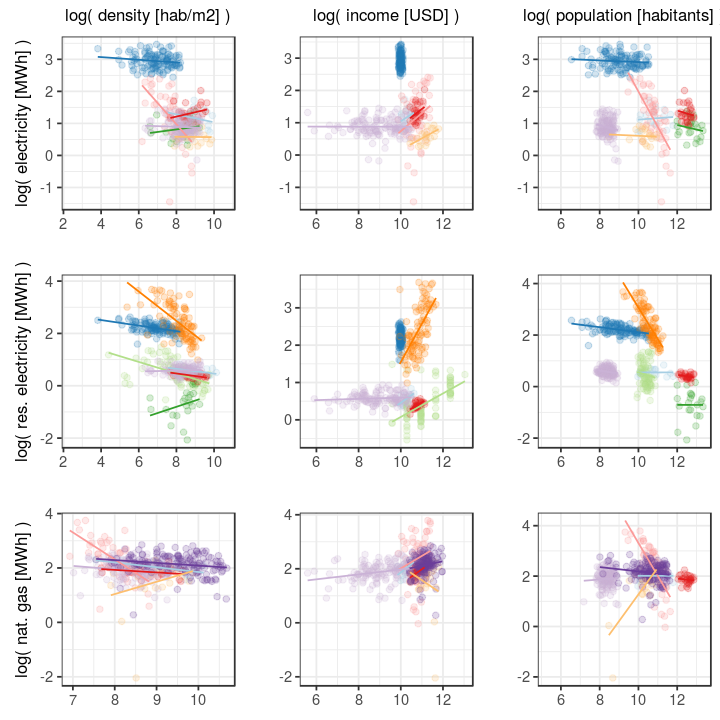

In [399]:
options(repr.plot.width=6, repr.plot.height=6)
plot_grid(et_d, et_i, et_p, er_d, er_i, er_p, ng_d, ng_i, ng_p, 
          align="hv",
          ncol = 3, nrow = 3)

###### regression

In [389]:
# ECpc

regression_electrictiyuse_pc <- data.frame(density_intercept= numeric(0), 
                                           density_alpha= numeric(0), 
                                           density_r.squared= numeric(0),
                                           density_p.value= numeric(0),
                                           income_intercept= numeric(0), 
                                           income_alpha= numeric(0), 
                                           income_r.squared= numeric(0),
                                           income_p.value= numeric(0),
                                           population_intercept= numeric(0), 
                                           population_alpha= numeric(0), 
                                           population_r.squared= numeric(0),
                                           population_p.value= numeric(0),
                                        stringsAsFactors=FALSE)

for (cit in unique(cisbat_clean$city)) {
   
    
    ### population
  if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$electricityUse_percapita_mwh))) {
      regression_electrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "population_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$population))) {
    regression_electrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "population_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(electricityUse_percapita_mwh) ~ log(population), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$electricityUse_percapita_mwh),])
    regression_electrictiyuse_pc[cit, "population_r.squared"] <- summary(rg_p)$r.squared
    regression_electrictiyuse_pc[cit, "population_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_electrictiyuse_pc[cit, "population_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_electrictiyuse_pc[cit, "population_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
    
    
    
    ### density
      if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$electricityUse_percapita_mwh))) {
      regression_electrictiyuse_pc[cit, "density_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "density_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "density_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "density_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$density))) {
      regression_electrictiyuse_pc[cit, "density_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "population_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(electricityUse_percapita_mwh) ~ log(density), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$electricityUse_percapita_mwh),])
    regression_electrictiyuse_pc[cit, "density_r.squared"] <- summary(rg_p)$r.squared
    regression_electrictiyuse_pc[cit, "density_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_electrictiyuse_pc[cit, "density_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_electrictiyuse_pc[cit, "density_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
    
    
        ### income
      if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$electricityUse_percapita_mwh))) {
      regression_electrictiyuse_pc[cit, "income_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "income_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "income_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "income_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$householdIncome_PPP))) {
      regression_electrictiyuse_pc[cit, "income_r.squared"] <- NA
      regression_electrictiyuse_pc[cit, "income_p.value"] <- NA 
      regression_electrictiyuse_pc[cit, "income_alpha"] <- NA 
      regression_electrictiyuse_pc[cit, "income_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(electricityUse_percapita_mwh) ~ log(householdIncome_PPP), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$electricityUse_percapita_mwh),])
    regression_electrictiyuse_pc[cit, "income_r.squared"] <- summary(rg_p)$r.squared
    regression_electrictiyuse_pc[cit, "income_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_electrictiyuse_pc[cit, "income_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_electrictiyuse_pc[cit, "income_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
  
    
    }


regression_electrictiyuse_pc$city <- rownames(regression_electrictiyuse_pc)
levels(regression_electrictiyuse_pc$city) <- unique(regression_electrictiyuse_pc$city)


 regression_electrictiyuse_pc    

density_intercept density_alpha density_r.squared density_p.value
Brussels      2.2735817         -0.123897736  0.0871077303      2.501222e-01   
Milan         3.2365460         -0.041660064  0.0219980869      1.105079e-01   
Cape Town            NA                   NA            NA                NA   
Buenos Aires  0.1764159          0.079533053  0.0391063937      3.543082e-01   
Chicago       6.3161821         -0.668186055  0.3084228715      7.501654e-05   
London        0.1288585          0.135592171  0.0771768755      1.445288e-01   
San Francisco 0.6404013         -0.006966057  0.0003546069      9.354283e-01   
Los Angeles          NA                   NA            NA                NA   
Glasgow       1.0542594         -0.019961977  0.0023763093      5.969954e-01   
New York City        NA                   NA            NA                NA   
              income_intercept income_alpha income_r.squared income_p.value
Brussels      -3.3154583        0.426447784 8.020848e-02     0.270673838   
Milan          6.8316651       -0.380467924 7.365394e-03     0.363928475   
Cape Town             NA                 NA           NA              NA   
Buenos Aires          NA                 NA           NA              NA   
Chicago       -4.8890874        0.562626620 7.034734e-02     0.062670456   
London        -4.3638407        0.509878145 1.140469e-01     0.078821799   
San Francisco -3.3913555        0.355349263 4.061979e-01     0.001421126   
Los Angeles           NA                 NA           NA              NA   
Glasgow        0.8871009       -0.001084529 1.592602e-05     0.964769077   
New York City         NA                 NA           NA              NA   
              population_intercept population_alpha population_r.squared
Brussels       0.6663467            0.04517740      0.008700283         
Milan          3.1765849           -0.02630122      0.009749413         
Cape Town             NA                    NA               NA         
Buenos Aires   2.6624631           -0.14262354      0.038159966         
Chicago       13.0597366           -1.10649432      0.467661058         
London         3.5944530           -0.18277275      0.024373834         
San Francisco  0.8849702           -0.02716216      0.005785336         
Los Angeles           NA                    NA               NA         
Glasgow        2.2000841           -0.15759770      0.024001752         
New York City         NA                    NA               NA         
              population_p.value city         
Brussels      7.217897e-01       Brussels     
Milan         2.853579e-01       Milan        
Cape Town               NA       Cape Town    
Buenos Aires  3.717232e-01       Buenos Aires 
Chicago       4.397550e-08       Chicago      
London        4.186684e-01       London       
San Francisco 7.499416e-01       San Francisco
Los Angeles             NA       Los Angeles  
Glasgow       8.324302e-02       Glasgow      
New York City           NA       New York City

In [390]:
# RECpc

regression_residentialelectrictiyuse_pc <- data.frame(density_intercept= numeric(0), 
                                           density_alpha= numeric(0), 
                                           density_r.squared= numeric(0),
                                           density_p.value= numeric(0),
                                           income_intercept= numeric(0), 
                                           income_alpha= numeric(0), 
                                           income_r.squared= numeric(0),
                                           income_p.value= numeric(0),
                                           population_intercept= numeric(0), 
                                           population_alpha= numeric(0), 
                                           population_r.squared= numeric(0),
                                           population_p.value= numeric(0),
                                        stringsAsFactors=FALSE)

for (cit in unique(cisbat_clean$city)) {
   
    
    ### population
  if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$residencialElectricityUse_percapita_mwh))) {
      regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$population))) {
    regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(residencialElectricityUse_percapita_mwh) ~ log(population), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$residencialElectricityUse_percapita_mwh),])
    regression_residentialelectrictiyuse_pc[cit, "population_r.squared"] <- summary(rg_p)$r.squared
    regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
    
    
    
    ### density
      if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$residencialElectricityUse_percapita_mwh))) {
      regression_residentialelectrictiyuse_pc[cit, "density_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "density_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "density_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "density_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$density))) {
      regression_residentialelectrictiyuse_pc[cit, "density_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "population_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "population_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(residencialElectricityUse_percapita_mwh) ~ log(density), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$residencialElectricityUse_percapita_mwh),])
    regression_residentialelectrictiyuse_pc[cit, "density_r.squared"] <- summary(rg_p)$r.squared
    regression_residentialelectrictiyuse_pc[cit, "density_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_residentialelectrictiyuse_pc[cit, "density_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_residentialelectrictiyuse_pc[cit, "density_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
    
    
        ### income
      if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$residencialElectricityUse_percapita_mwh))) {
      regression_residentialelectrictiyuse_pc[cit, "income_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "income_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "income_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "income_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$householdIncome_PPP))) {
      regression_residentialelectrictiyuse_pc[cit, "income_r.squared"] <- NA
      regression_residentialelectrictiyuse_pc[cit, "income_p.value"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "income_alpha"] <- NA 
      regression_residentialelectrictiyuse_pc[cit, "income_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(residencialElectricityUse_percapita_mwh) ~ log(householdIncome_PPP), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$residencialElectricityUse_percapita_mwh),])
    regression_residentialelectrictiyuse_pc[cit, "income_r.squared"] <- summary(rg_p)$r.squared
    regression_residentialelectrictiyuse_pc[cit, "income_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_residentialelectrictiyuse_pc[cit, "income_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_residentialelectrictiyuse_pc[cit, "income_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
  
    
    }

regression_residentialelectrictiyuse_pc$city <- rownames(regression_residentialelectrictiyuse_pc)
levels(regression_residentialelectrictiyuse_pc$city) <- unique(regression_residentialelectrictiyuse_pc$city)

 regression_residentialelectrictiyuse_pc    

density_intercept density_alpha density_r.squared density_p.value
Brussels       1.3738166        -0.09081337   0.24495663        4.339612e-02   
Milan          2.9366512        -0.10622707   0.20548460        2.541469e-07   
Cape Town      2.2267592        -0.21918866   0.29332616        3.650197e-07   
Buenos Aires  -2.7092023         0.23810936   0.08763756        1.809948e-01   
Chicago               NA                 NA           NA                  NA   
London         1.2618607        -0.09899448   0.30127727        1.683835e-03   
San Francisco         NA                 NA           NA                  NA   
Los Angeles    6.9709933        -0.56132750   0.39997925        1.047186e-11   
Glasgow        0.4465323         0.01654198   0.00473401        4.591022e-01   
New York City         NA                 NA           NA                  NA   
              income_intercept income_alpha income_r.squared income_p.value
Brussels      -3.6518845       0.40187607   4.234149e-01     4.673989e-03  
Milan          1.9087799       0.02838590   5.430347e-05     9.376988e-01  
Cape Town     -2.5779824       0.31470643   3.353150e-01     2.264484e-08  
Buenos Aires          NA               NA             NA               NA  
Chicago               NA               NA             NA               NA  
London        -3.4286328       0.34342548   3.932390e-01     2.721941e-04  
San Francisco         NA               NA             NA               NA  
Los Angeles   -8.7495669       1.02953896   3.827244e-01     1.449780e-11  
Glasgow        0.4243381       0.01632203   1.084155e-02     2.537286e-01  
New York City         NA               NA             NA               NA  
              population_intercept population_alpha population_r.squared
Brussels       0.5273492            0.0020928296    8.535506e-05        
Milan          3.0794935           -0.0967765125    1.934721e-01        
Cape Town      2.9490226           -0.2396231184    1.125700e-02        
Buenos Aires  -0.7097507           -0.0001256553    8.084506e-09        
Chicago               NA                      NA              NA        
London         1.8718347           -0.1179355133    6.799549e-02        
San Francisco         NA                      NA              NA        
Los Angeles   15.3321546           -1.2265028373    6.515421e-01        
Glasgow        1.5124140           -0.1116483782    3.683219e-02        
New York City         NA                      NA              NA        
              population_p.value city         
Brussels      9.719271e-01       Brussels     
Milan         4.992737e-07       Milan        
Cape Town     3.552127e-01       Cape Town    
Buenos Aires  9.996914e-01       Buenos Aires 
Chicago                 NA       Chicago      
London        1.639934e-01       London       
San Francisco           NA       San Francisco
Los Angeles   8.879111e-23       Los Angeles  
Glasgow       3.420058e-02       Glasgow      
New York City           NA       New York City

In [404]:
# NGCpc


regression_naturalgasuse_pc <- data.frame(density_intercept= numeric(0), 
                                           density_alpha= numeric(0), 
                                           density_r.squared= numeric(0),
                                           density_p.value= numeric(0),
                                           income_intercept= numeric(0), 
                                           income_alpha= numeric(0), 
                                           income_r.squared= numeric(0),
                                           income_p.value= numeric(0),
                                           population_intercept= numeric(0), 
                                           population_alpha= numeric(0), 
                                           population_r.squared= numeric(0),
                                           population_p.value= numeric(0),
                                        stringsAsFactors=FALSE)

for (cit in unique(cisbat_clean$city)) {
   
    
    ### population
  if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$naturalGasUse_percapita_mwh))) {
      regression_naturalgasuse_pc[cit, "population_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "population_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$population))) {
    regression_naturalgasuse_pc[cit, "population_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "population_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(naturalGasUse_percapita_mwh) ~ log(population), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$naturalGasUse_percapita_mwh),])
    regression_naturalgasuse_pc[cit, "population_r.squared"] <- summary(rg_p)$r.squared
    regression_naturalgasuse_pc[cit, "population_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_naturalgasuse_pc[cit, "population_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_naturalgasuse_pc[cit, "population_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
    
    
    
    ### density
      if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$naturalGasUse_percapita_mwh))) {
      regression_naturalgasuse_pc[cit, "density_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "density_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "density_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "density_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$density))) {
      regression_naturalgasuse_pc[cit, "density_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "population_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "population_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "population_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(naturalGasUse_percapita_mwh) ~ log(density), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$naturalGasUse_percapita_mwh),])
    regression_naturalgasuse_pc[cit, "density_r.squared"] <- summary(rg_p)$r.squared
    regression_naturalgasuse_pc[cit, "density_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_naturalgasuse_pc[cit, "density_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_naturalgasuse_pc[cit, "density_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
    
    
        ### income
      if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$naturalGasUse_percapita_mwh))) {
      regression_naturalgasuse_pc[cit, "income_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "income_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "income_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "income_intercept"] <- NA 
 
    } 
    else if (all(is.na(cisbat_clean[cisbat_clean$city==cit,]$householdIncome_PPP))) {
      regression_naturalgasuse_pc[cit, "income_r.squared"] <- NA
      regression_naturalgasuse_pc[cit, "income_p.value"] <- NA 
      regression_naturalgasuse_pc[cit, "income_alpha"] <- NA 
      regression_naturalgasuse_pc[cit, "income_intercept"] <- NA 
      }
    else{
     rg_p <- lm(log(naturalGasUse_percapita_mwh) ~ log(householdIncome_PPP), na.action=na.exclude, data = cisbat_clean[cisbat_clean$city==cit & complete.cases(cisbat_clean$naturalGasUse_percapita_mwh),])
    regression_naturalgasuse_pc[cit, "income_r.squared"] <- summary(rg_p)$r.squared
    regression_naturalgasuse_pc[cit, "income_p.value"] <- summary(rg_p)$coefficients[2,4] 
    regression_naturalgasuse_pc[cit, "income_alpha"] <- summary(rg_p)$coefficients[2,1] 
    regression_naturalgasuse_pc[cit, "income_intercept"] <- summary(rg_p)$coefficients[1,1] 
   
  }
  
    
    }


regression_naturalgasuse_pc$city <- rownames(regression_naturalgasuse_pc)
levels(regression_naturalgasuse_pc$city) <- unique(regression_naturalgasuse_pc$city)

 regression_naturalgasuse_pc    

density_intercept density_alpha density_r.squared density_p.value
Brussels       3.611381         -0.17603663   0.284236237       2.270924e-02   
Milan                NA                  NA            NA                 NA   
Cape Town            NA                  NA            NA                 NA   
Buenos Aires         NA                  NA            NA                 NA   
Chicago        7.710023         -0.67444346   0.306061745       6.676826e-05   
London         2.685627         -0.09445637   0.094539998       9.835934e-02   
San Francisco -2.578296          0.45231092   0.074974558       2.175491e-01   
Los Angeles          NA                  NA            NA                 NA   
Glasgow        2.284257         -0.04712369   0.007786419       3.378703e-01   
New York City  3.138943         -0.10539163   0.048822779       5.420185e-03   
              income_intercept income_alpha income_r.squared income_p.value
Brussels      -4.519458         0.62436042  0.31013007       0.016366039   
Milan                NA                 NA          NA                NA   
Cape Town            NA                 NA          NA                NA   
Buenos Aires         NA                 NA          NA                NA   
Chicago       -2.625955         0.46385706  0.03738927       0.169607140   
London        -4.338554         0.55676136  0.32984004       0.001121817   
San Francisco  7.353841        -0.52534336  0.04595743       0.325969970   
Los Angeles          NA                 NA          NA                NA   
Glasgow        1.027292         0.09139375  0.06778937       0.003235724   
New York City  0.284599         0.16608468  0.02403720       0.060784579   
              population_intercept population_alpha population_r.squared
Brussels       2.002403             0.000706325     3.136023e-06        
Milan                NA                      NA               NA        
Cape Town            NA                      NA               NA        
Buenos Aires         NA                      NA               NA        
Chicago       16.381168            -1.306931667     5.471623e-01        
London         2.907532            -0.083731153     1.181337e-02        
San Francisco -9.343255             1.061666619     5.169662e-01        
Los Angeles          NA                      NA               NA        
Glasgow        1.378735             0.060778147     2.584757e-03        
New York City  3.043577            -0.085801155     2.806836e-02        
              population_p.value city         
Brussels      9.944358e-01       Brussels     
Milan                   NA       Milan        
Cape Town               NA       Cape Town    
Buenos Aires            NA       Buenos Aires 
Chicago       3.742170e-10       Chicago      
London        5.675130e-01       London       
San Francisco 2.400086e-04       San Francisco
Los Angeles             NA       Los Angeles  
Glasgow       5.733886e-01       Glasgow      
New York City 3.309246e-02       New York City

In [ ]:
# plot slopes

Warning message:
“Removed 3 rows containing missing values (position_stack).”

Warning message:
“Removed 3 rows containing missing values (position_stack).”

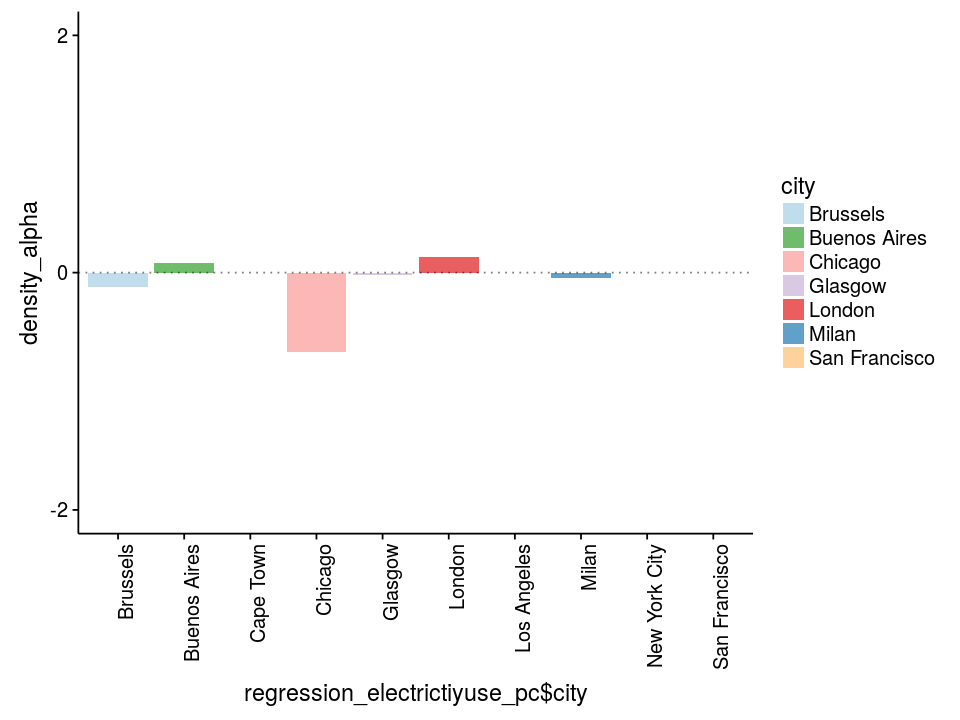

Warning message:
“Removed 4 rows containing missing values (position_stack).”

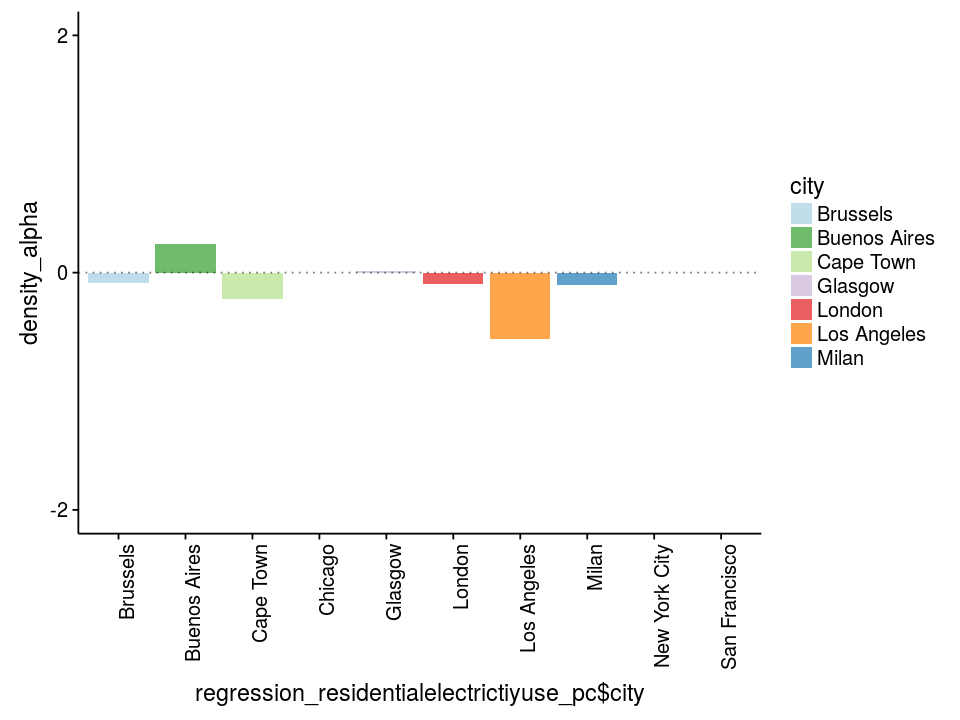

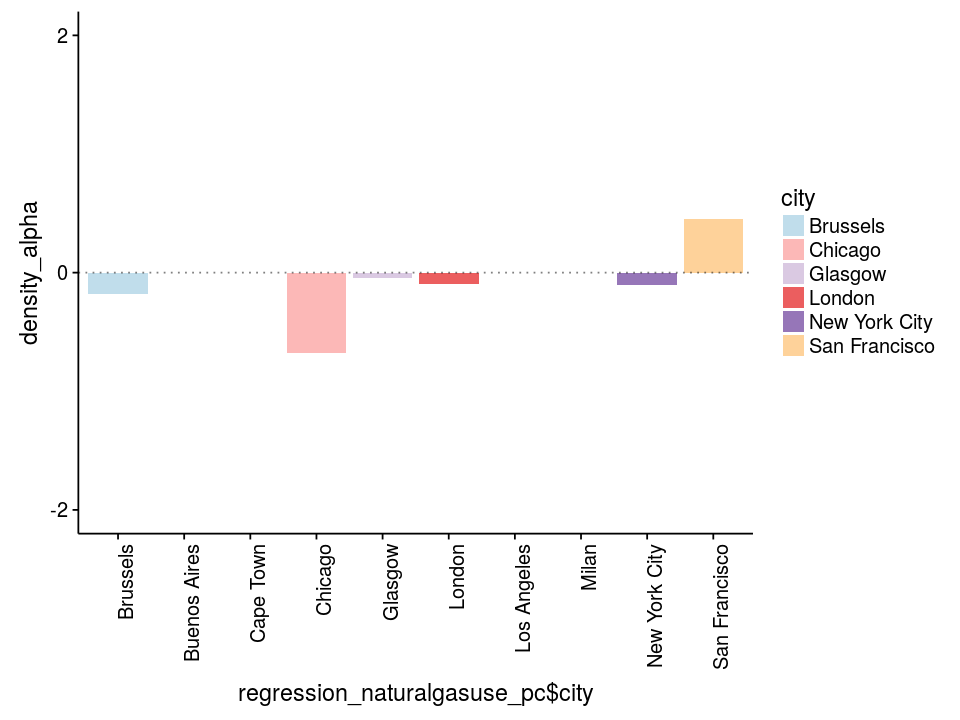

In [405]:
#density

options(repr.plot.width=8, repr.plot.height=6)

ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, density_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, density_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, density_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale


Warning message:
“Removed 3 rows containing missing values (position_stack).”

Warning message:
“Removed 3 rows containing missing values (position_stack).”

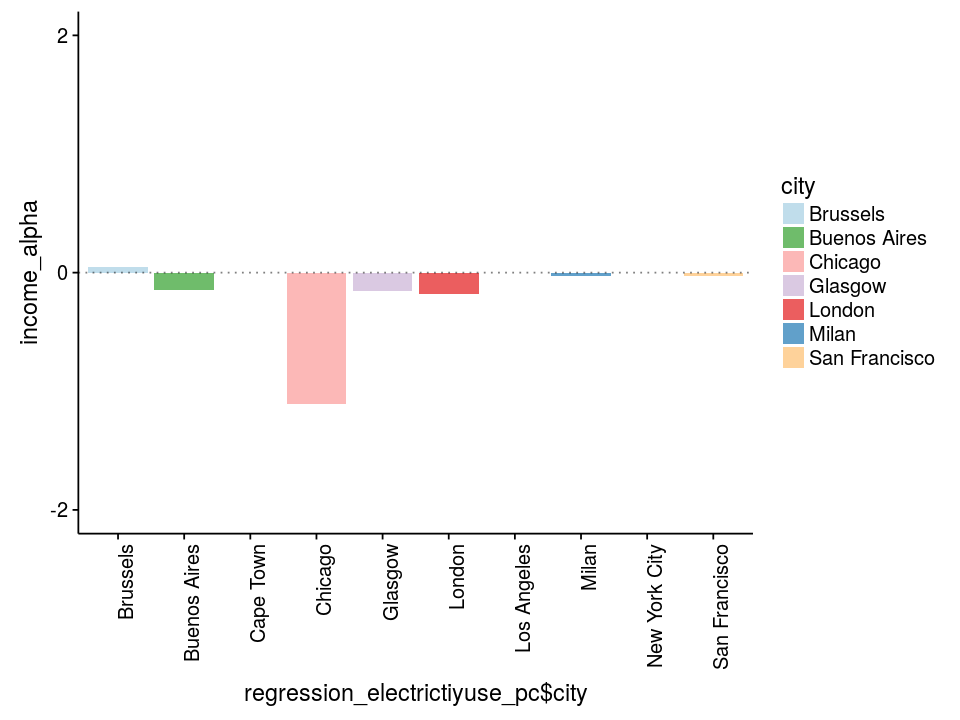

Warning message:
“Removed 4 rows containing missing values (position_stack).”

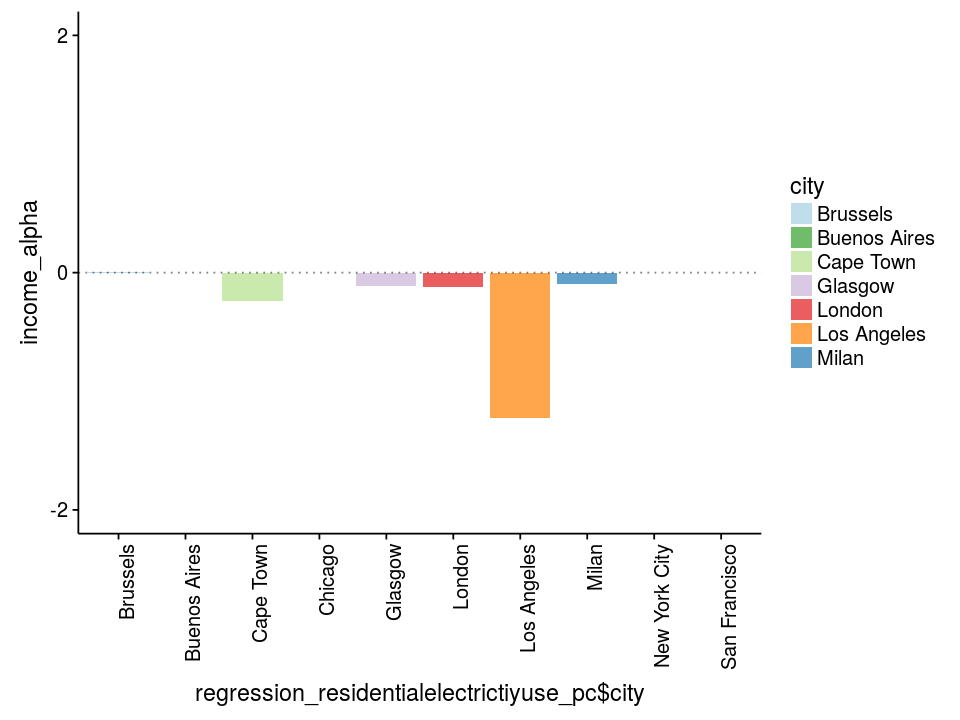

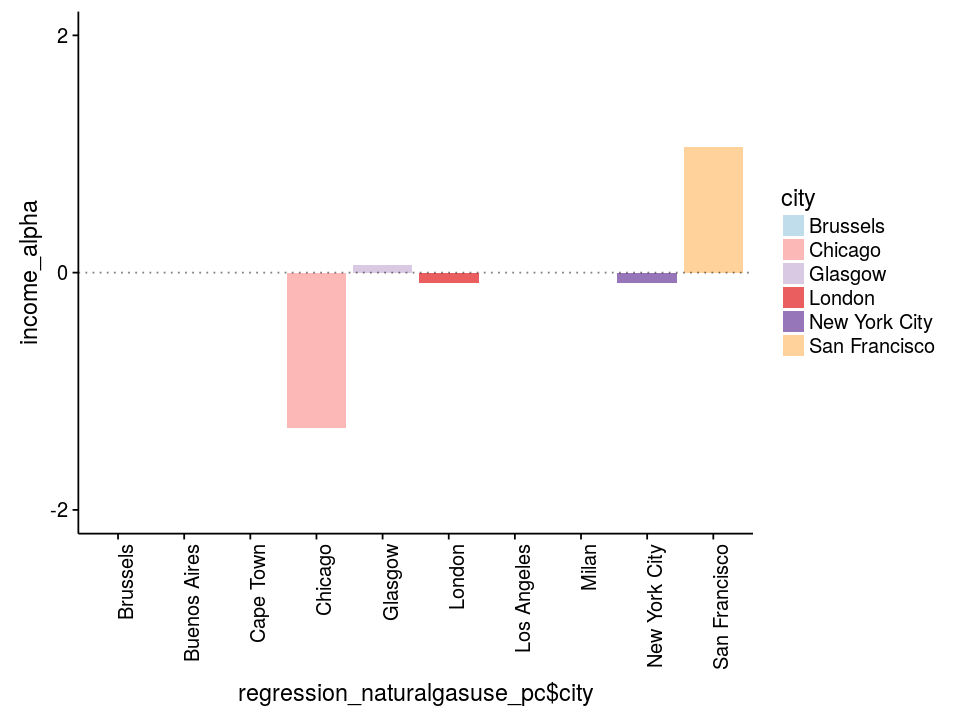

In [374]:
# income

ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, income_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, income_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, income_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale


Warning message:
“Removed 3 rows containing missing values (position_stack).”

Warning message:
“Removed 3 rows containing missing values (position_stack).”

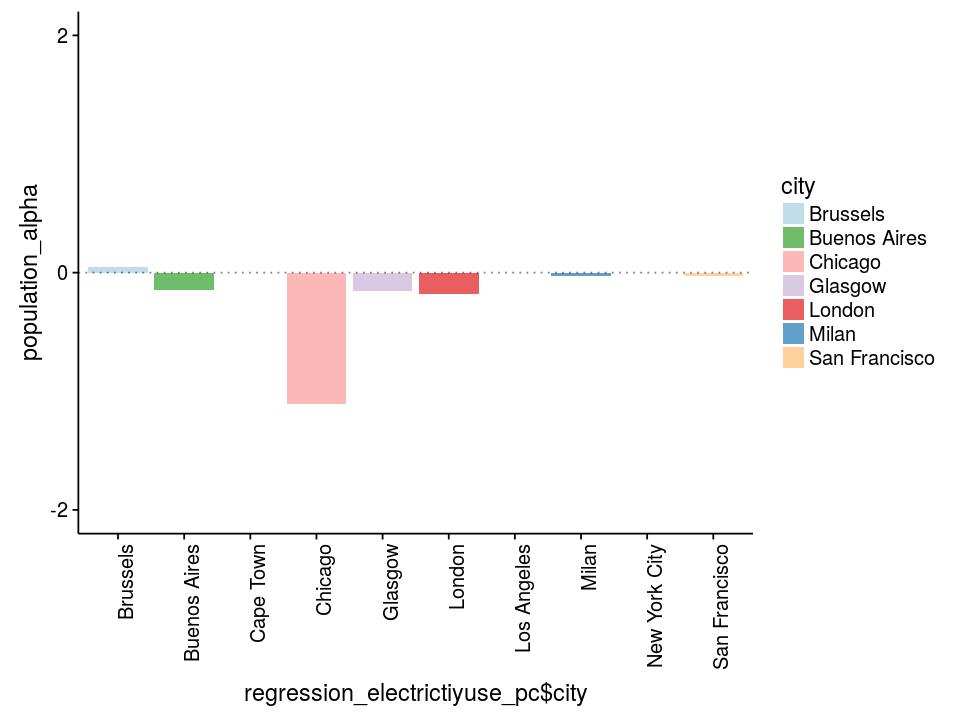

Warning message:
“Removed 4 rows containing missing values (position_stack).”

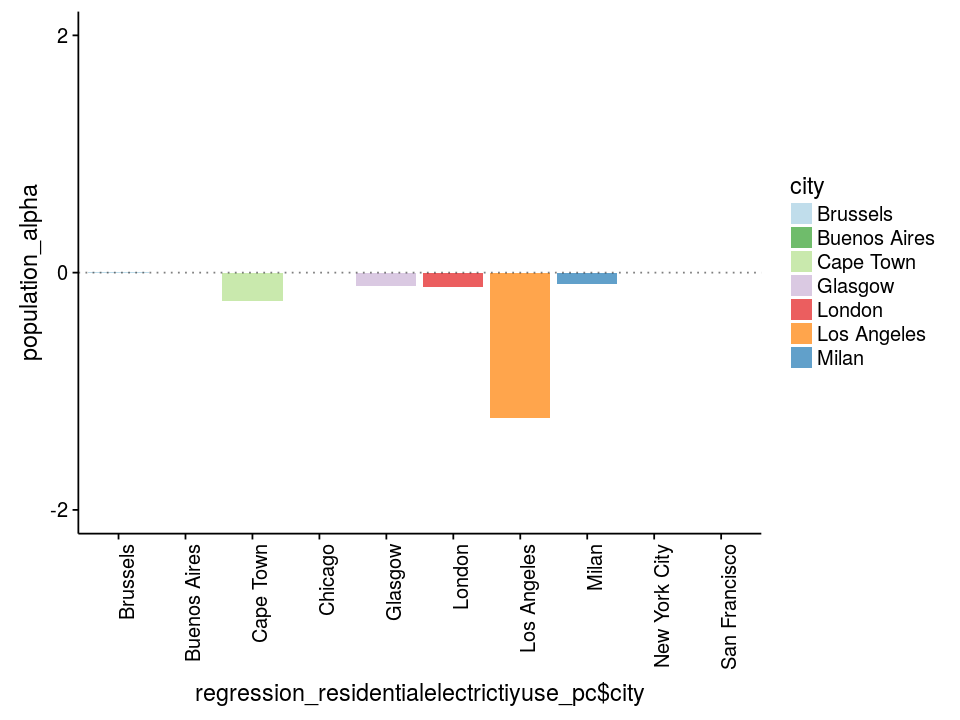

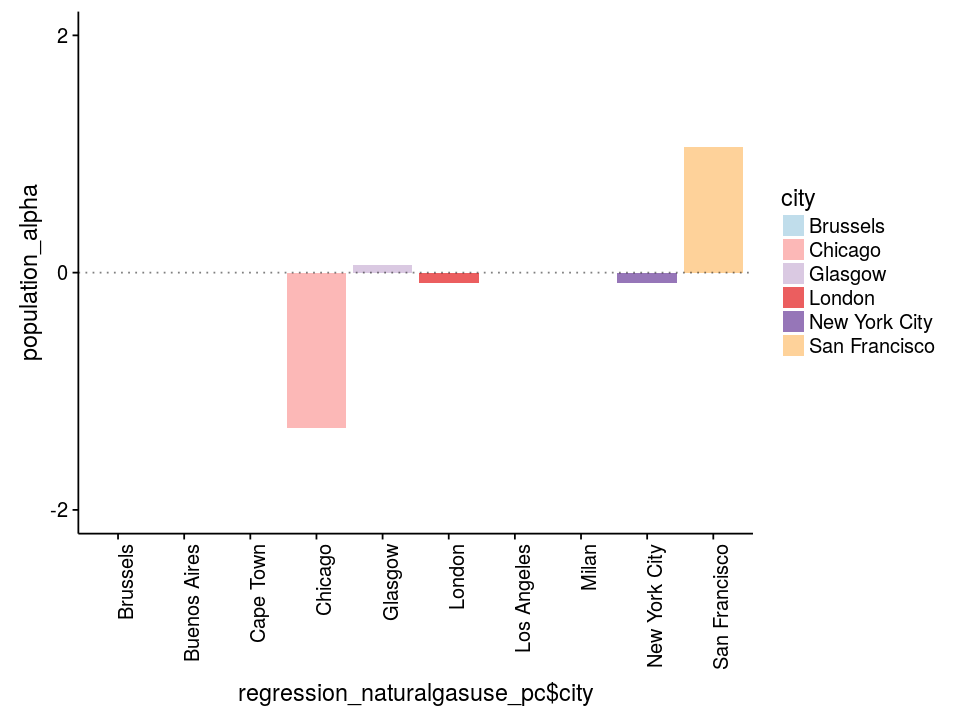

In [375]:
#population 

ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, population_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, population_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale
ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, population_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+ filScale


In [406]:
et_d_i <- ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, density_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
et_i_i <- ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, income_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
et_p_i <- ggplot(regression_electrictiyuse_pc, aes(regression_electrictiyuse_pc$city, population_alpha, group=regression_electrictiyuse_pc$city, fill=regression_electrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale

er_d_i <- ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, density_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
er_i_i <- ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, income_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
er_p_i <- ggplot(regression_residentialelectrictiyuse_pc, aes(regression_residentialelectrictiyuse_pc$city, population_alpha, group=regression_residentialelectrictiyuse_pc$city, fill=regression_residentialelectrictiyuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale

ng_d_i <- ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, density_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
ng_i_i <- ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, income_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale
ng_p_i <- ggplot(regression_naturalgasuse_pc, aes(regression_naturalgasuse_pc$city, population_alpha, group=regression_naturalgasuse_pc$city, fill=regression_naturalgasuse_pc$city))+geom_bar(stat = "identity", alpha=0.7)+ theme(legend.position="none",panel.background = element_rect(fill = alpha('lightgrey', 0.6), size=5),axis.title.y=element_blank(),axis.title.x=element_blank(), axis.text.y=element_text(size=8), axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.line.y = element_blank(), axis.line.x = element_blank())+geom_hline(yintercept=0, alpha=0.5,linetype="dotted") +scale_y_continuous(breaks=c(-2, 0, 2), limits=c(-2, 2))+ggtitle(expression(beta))+ filScale


Warning message:
“Removed 3 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 3 rows containing missing values (position_stack).”Warning message:
“Removed 3 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 3 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”

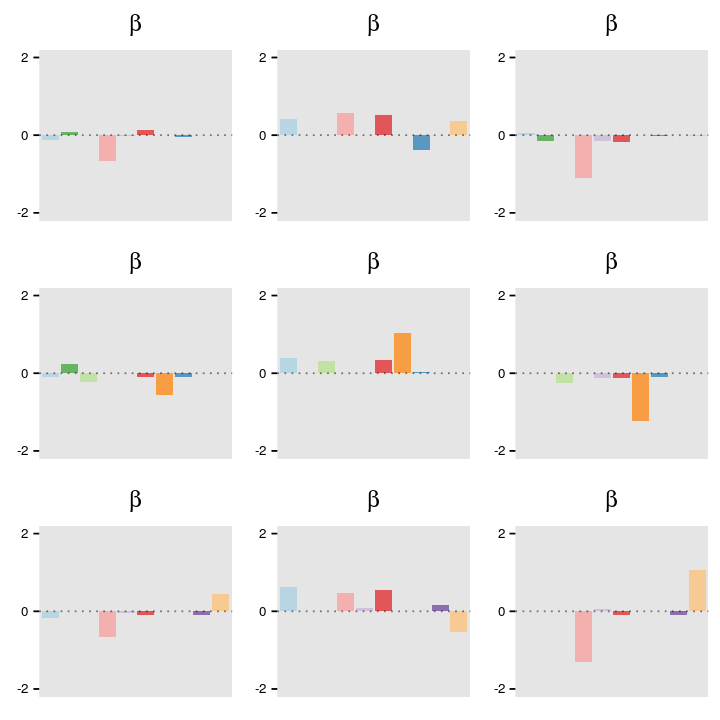

In [407]:
options(repr.plot.width=6, repr.plot.height=6)
plot_grid(et_d_i, et_i_i, et_p_i, er_d_i, er_i_i, er_p_i, ng_d_i, ng_i_i, ng_p_i, 
          align="hv",
          ncol = 3, nrow = 3)